In [4]:
import numpy as np
import pandas as pd
import json
import tqdm
from collections import Counter
import collections

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
import time
import gc
import os
import argparse

import numpy as np
from sklearn.externals import  joblib
import torch
from torch import nn
import torch.backends.cudnn as cudnn

from vocab import  VocabBuilder, GloveVocabBuilder
from dataloader import TextClassDataLoader
from model import RNN
from util import AverageMeter, accuracy
from util import adjust_learning_rate

np.random.seed(0)
torch.manual_seed(0)

/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [8]:
LABEL_TO_INDEX = {'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'Jazz': 4,
 'Latin': 5,
 'Metal': 6,
 'New Age': 7,
 'Pop': 8,
 'Punk': 9,
 'Rap': 10,
 'Reggae': 11,
 'RnB': 12,
 'Rock': 13,
 'World': 14}


# Create tsv file

In [56]:
from util import create_tsv_file

In [ ]:
create_tsv_file('../baseline/dataset_train.csv', 'data/train.tsv')

In [ ]:
create_tsv_file('../baseline/dataset_val.csv', 'data/test.tsv')

In [57]:
create_tsv_file('../baseline/dataset_test.csv', 'data/test_test.tsv')


100%|██████████| 1046/1046 [00:00<00:00, 62074.54it/s]

# Main

# Glove

In [9]:
end = time.time()

In [10]:
glove = 'glove/glove.6B.100d.txt'

In [11]:
v_builder, d_word_index, embed = None, None, None

In [12]:
v_builder = GloveVocabBuilder(path_glove=glove)

In [13]:
d_word_index, embed = v_builder.get_word_index()

In [20]:
len(d_word_index)

400002

In [21]:
embedding_size = embed.size(1)

In [22]:
embedding_size

100

In [23]:
if not os.path.exists('gen'):
    os.mkdir('gen')
joblib.dump(d_word_index, 'gen/d_word_index.pkl', compress=3)
print('===> vocab creatin: {t:.3f}'.format(t=time.time()-end))

===> vocab creatin: 141.411


In [24]:
batch_size = 200

In [25]:
batch_size

200

In [26]:
# create trainer
print("===> creating dataloaders ...")
end = time.time()
train_loader = TextClassDataLoader('data/train.tsv', d_word_index, batch_size=batch_size)
val_loader = TextClassDataLoader('data/test.tsv', d_word_index, batch_size=batch_size)
print('===> dataloader creatin: {t:.3f}'.format(t=time.time()-end))

===> creating dataloaders ...
# samples: 8331
max len: 1313
# vocab: 400002
# batches: 41 (batch_size = 200)
# samples: 1004
max len: 436
# vocab: 400002
# batches: 5 (batch_size = 200)
===> dataloader creatin: 0.813


In [27]:
len(LABEL_TO_INDEX)

15

In [58]:
test_loader = TextClassDataLoader('data/test_test.tsv', d_word_index, batch_size=batch_size)

# samples: 1046
max len: 624
# vocab: 400002
# batches: 5 (batch_size = 200)


# RNN

In [41]:
hidden_size = 64

In [42]:
layers = 2

In [43]:
# create model
print("===> creating rnn model ...")
vocab_size = len(d_word_index)
model = RNN(vocab_size=vocab_size, embed_size=embedding_size, num_output=len(LABEL_TO_INDEX), rnn_model='LSTM',
            use_last=False,
            hidden_size=hidden_size, embedding_tensor=embed, num_layers=layers, batch_first=True)
print(model)

===> creating rnn model ...
RNN(
  (encoder): Embedding(400002, 100, padding_idx=0)
  (drop_en): Dropout(p=0.6)
  (rnn): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=15, bias=True)
)


In [44]:
model = torch.nn.DataParallel(model).cuda()

In [46]:
lr = 0.1
weight_decay = 1e-4

In [47]:
# optimizer and loss
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=lr, weight_decay=weight_decay)

In [48]:
criterion = nn.CrossEntropyLoss()
print(optimizer)
print(criterion)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0.0001
)
CrossEntropyLoss()


In [49]:
torch.backends.cudnn.enabled = True
cudnn.benchmark = True
model.cuda()
criterion = criterion.cuda()

# Functions

In [51]:
from sklearn.metrics import classification_report


def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()
    
    total_preds = []
    total_labels = []

    end = time.time()
    for i, (input, target, seq_lengths) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        # measure data loading time
        data_time.update(time.time() - end)

        #if args.cuda:
        input = input.cuda(async=True)
        target = target.cuda(async=True)

        # compute output
        output = model(input, seq_lengths)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))
        losses.update(loss.data, input.size(0))
        top1.update(prec1[0][0], input.size(0))
        
        target_list = [int(x.item()) for x in target]
        #output_list = [x.item() for x in torch.nn.functional.softmax(output.data)]
        values, pred_indices = torch.max(torch.nn.functional.softmax(output.data), dim=1)
        output_list = [int(x.item()) for x in pred_indices]
                
        total_preds.extend(output_list)
        total_labels.extend(target_list)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        
        clip = 0.25
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        print_freq = 10
        if i != 0 and i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]  Time {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})  Loss {loss.val:.4f} ({loss.avg:.4f})  '
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time, loss=losses, top1=top1))
            gc.collect()
    
    report = classification_report(total_labels, total_preds)
    print ('--- Train ----')
    print (report)
    print ('-------')


def test(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    total_preds = []
    total_labels = []
    for i, (input, target,seq_lengths) in tqdm.tqdm(enumerate(val_loader), total=len(val_loader)):

        #if args.cuda:
        input = input.cuda(async=True)
        target = target.cuda(async=True)

        # compute output
        output = model(input,seq_lengths)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))
        losses.update(loss.data, input.size(0))
        top1.update(prec1[0][0], input.size(0))
        
        target_list = [int(x.item()) for x in target]
        #output_list = [x.item() for x in torch.nn.functional.softmax(output.data)]
        values, pred_indices = torch.max(torch.nn.functional.softmax(output.data), dim=1)
        output_list = [int(x.item()) for x in pred_indices]
        #print (target_list[:5])
        #print (output_list[:5])
        
        total_preds.extend(output_list)
        total_labels.extend(target_list)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        print_freq = 10
        if i!= 0 and i % print_freq == 0:
            print('Test: [{0}/{1}]  Time {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                  'Loss {loss.val:.4f} ({loss.avg:.4f})  Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses, top1=top1))
            gc.collect()

    print('Val * Prec@1 {top1.avg:.3f}'.format(top1=top1))
    
    report = classification_report(total_labels, total_preds)
    print (report)
    

    
    return top1.avg, total_labels, total_preds

# Training

In [38]:
epochs = 50
save_freq = 1

In [32]:
for epoch in range(1, epochs+1):
    adjust_learning_rate(lr, optimizer, epoch)
    train(train_loader, model, criterion, optimizer, epoch)
    test(val_loader, model, criterion)

    # save current model
    if epoch % save_freq == 0:
        name_model = 'rnn_4{}.pkl'.format(epoch)
        path_save_model = os.path.join('gen', name_model)
        joblib.dump(model.float(), path_save_model, compress=2)

  0%|          | 0/41 [00:00<?, ?it/s]/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:525: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.num_layers, self.dropout, self.training, self.bidirectional)
 27%|██▋       | 11/41 [00:13<00:23,  1.25it/s]

Epoch: [1][10/41]  Time 0.627 (1.207)  Data 0.007 (0.007)  Loss 2.4975 (2.6010)  Prec@1 21.500 (17.682)


 51%|█████     | 21/41 [00:19<00:12,  1.64it/s]

Epoch: [1][20/41]  Time 0.588 (0.902)  Data 0.009 (0.011)  Loss 2.2983 (2.4754)  Prec@1 29.500 (21.976)


 76%|███████▌  | 31/41 [00:24<00:06,  1.57it/s]

Epoch: [1][30/41]  Time 0.670 (0.804)  Data 0.010 (0.013)  Loss 2.0125 (2.3761)  Prec@1 34.000 (24.823)


 20%|██        | 1/5 [00:00<00:00,  6.01it/s]

Epoch: [1][40/41]  Time 0.435 (0.744)  Data 0.006 (0.013)  Loss 2.1333 (2.3178)  Prec@1 36.500 (26.732)


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]
/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 * Prec@1 9.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00         1
           6       1.00      0.01      0.02       100
           7       0.00      0.00      0.00        25
           8       0.29      0.11      0.15       208
           9       0.00      0.00      0.00        21
          10       0.06      0.75      0.11        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.20      0.20      0.20       137
          14       0.00      0.00      0.00         3

    accuracy                           0.10      1000
   macro avg       0.10      0.07      0.03      1000
weighted a

 27%|██▋       | 11/41 [00:06<00:20,  1.49it/s]

Epoch: [2][10/41]  Time 0.853 (0.557)  Data 0.007 (0.007)  Loss 2.0923 (2.1447)  Prec@1 30.500 (30.727)


 51%|█████     | 21/41 [00:11<00:12,  1.63it/s]

Epoch: [2][20/41]  Time 0.576 (0.564)  Data 0.011 (0.011)  Loss 2.0242 (2.1134)  Prec@1 33.500 (31.333)


 76%|███████▌  | 31/41 [00:17<00:05,  1.89it/s]

Epoch: [2][30/41]  Time 0.474 (0.564)  Data 0.008 (0.013)  Loss 2.1567 (2.1073)  Prec@1 34.000 (31.613)


 20%|██        | 1/5 [00:00<00:00,  5.64it/s]

Epoch: [2][40/41]  Time 0.459 (0.553)  Data 0.007 (0.014)  Loss 2.0734 (2.1040)  Prec@1 33.500 (31.622)


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


 * Prec@1 11.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.07      0.09      0.08        66
           2       0.00      0.00      0.00       101
           3       0.00      0.00      0.00        32
           4       0.12      0.88      0.20       105
           5       0.00      0.00      0.00         1
           6       0.21      0.09      0.13       100
           7       0.00      0.00      0.00        25
           8       0.14      0.00      0.01       209
           9       0.00      0.00      0.00        21
          10       0.15      0.11      0.13        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        77
          13       0.20      0.02      0.04       136
          14       0.00      0.00      0.00         3

    accuracy                           0.12      1000
   macro avg       0.06      0.08      0.04      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.76it/s]

Epoch: [3][10/41]  Time 0.632 (0.541)  Data 0.012 (0.010)  Loss 2.0405 (2.0393)  Prec@1 29.500 (34.455)


 51%|█████     | 21/41 [00:11<00:10,  1.95it/s]

Epoch: [3][20/41]  Time 0.458 (0.527)  Data 0.013 (0.015)  Loss 2.1687 (2.0531)  Prec@1 30.000 (34.214)


 76%|███████▌  | 31/41 [00:17<00:06,  1.61it/s]

Epoch: [3][30/41]  Time 0.548 (0.557)  Data 0.014 (0.016)  Loss 2.1526 (2.0680)  Prec@1 25.000 (33.016)


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Epoch: [3][40/41]  Time 0.555 (0.550)  Data 0.008 (0.016)  Loss 2.0064 (2.0765)  Prec@1 36.000 (32.915)


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


 * Prec@1 10.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        66
           2       0.08      0.39      0.14       101
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00       105
           5       0.00      0.00      0.00         1
           6       0.24      0.06      0.10        99
           7       0.00      0.00      0.00        25
           8       0.21      0.17      0.19       207
           9       0.00      0.00      0.00        21
          10       0.09      0.43      0.14        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.17      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.11      1000
   macro avg       0.05      0.07      0.04      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.76it/s]

Epoch: [4][10/41]  Time 0.492 (0.580)  Data 0.009 (0.010)  Loss 2.1485 (2.0754)  Prec@1 29.500 (31.955)


 51%|█████     | 21/41 [00:12<00:12,  1.58it/s]

Epoch: [4][20/41]  Time 0.639 (0.588)  Data 0.009 (0.013)  Loss 1.9252 (2.0569)  Prec@1 40.000 (32.905)


 76%|███████▌  | 31/41 [00:18<00:06,  1.66it/s]

Epoch: [4][30/41]  Time 0.581 (0.581)  Data 0.012 (0.014)  Loss 1.9601 (2.0473)  Prec@1 37.000 (33.242)


 20%|██        | 1/5 [00:00<00:00,  5.49it/s]

Epoch: [4][40/41]  Time 0.514 (0.572)  Data 0.008 (0.015)  Loss 2.2166 (2.0539)  Prec@1 31.500 (33.171)


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


 * Prec@1 12.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.05      0.02      0.02        65
           2       0.18      0.02      0.04       102
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00       105
           5       0.00      0.00      0.00         1
           6       0.22      0.09      0.13        99
           7       0.00      0.00      0.00        25
           8       0.23      0.16      0.19       207
           9       0.00      0.00      0.00        21
          10       0.08      0.60      0.14        63
          11       0.03      0.06      0.04        33
          12       0.14      0.38      0.21        78
          13       0.23      0.06      0.09       137
          14       0.00      0.00      0.00         3

    accuracy                           0.12      1000
   macro avg       0.08      0.09      0.06      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:19,  1.54it/s]

Epoch: [5][10/41]  Time 0.795 (0.581)  Data 0.007 (0.008)  Loss 1.8718 (2.0033)  Prec@1 34.500 (33.909)


 51%|█████     | 21/41 [00:12<00:11,  1.68it/s]

Epoch: [5][20/41]  Time 0.499 (0.587)  Data 0.013 (0.013)  Loss 2.1890 (2.0187)  Prec@1 27.000 (33.595)


 76%|███████▌  | 31/41 [00:18<00:06,  1.64it/s]

Epoch: [5][30/41]  Time 0.610 (0.593)  Data 0.011 (0.015)  Loss 2.1078 (2.0316)  Prec@1 30.500 (33.403)


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Epoch: [5][40/41]  Time 0.503 (0.585)  Data 0.011 (0.016)  Loss 2.1300 (2.0338)  Prec@1 33.000 (33.427)


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


 * Prec@1 12.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.11      0.29      0.16        66
           2       0.00      0.00      0.00       102
           3       0.12      0.03      0.05        33
           4       0.10      0.43      0.16       104
           5       0.00      0.00      0.00         1
           6       0.22      0.10      0.14       100
           7       0.00      0.00      0.00        24
           8       0.19      0.10      0.13       207
           9       0.00      0.00      0.00        21
          10       0.14      0.35      0.20        63
          11       0.00      0.00      0.00        33
          12       0.10      0.05      0.07        78
          13       0.20      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.13      1000
   macro avg       0.08      0.09      0.07      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.73it/s]

Epoch: [6][10/41]  Time 0.491 (0.593)  Data 0.009 (0.012)  Loss 2.0720 (1.9946)  Prec@1 30.500 (34.545)


 51%|█████     | 21/41 [00:12<00:11,  1.78it/s]

Epoch: [6][20/41]  Time 0.463 (0.572)  Data 0.011 (0.015)  Loss 2.0341 (2.0076)  Prec@1 41.500 (34.476)


 76%|███████▌  | 31/41 [00:17<00:05,  1.73it/s]

Epoch: [6][30/41]  Time 0.481 (0.570)  Data 0.008 (0.016)  Loss 1.9789 (2.0020)  Prec@1 32.000 (34.806)


 20%|██        | 1/5 [00:00<00:00,  5.84it/s]

Epoch: [6][40/41]  Time 0.528 (0.565)  Data 0.009 (0.016)  Loss 2.0966 (2.0136)  Prec@1 33.500 (34.720)


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


 * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.11      0.03      0.05        66
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        33
           4       0.27      0.08      0.12       105
           5       0.00      0.00      0.00         1
           6       0.24      0.05      0.08        99
           7       0.00      0.00      0.00        25
           8       0.23      0.49      0.31       208
           9       0.00      0.00      0.00        21
          10       0.22      0.24      0.23        63
          11       0.00      0.00      0.00        33
          12       0.11      0.51      0.18        78
          13       0.19      0.04      0.06       135
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.09      0.10      0.07      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.67it/s]

Epoch: [7][10/41]  Time 0.641 (0.586)  Data 0.009 (0.010)  Loss 1.9523 (1.9661)  Prec@1 38.000 (35.500)


 51%|█████     | 21/41 [00:12<00:11,  1.68it/s]

Epoch: [7][20/41]  Time 0.555 (0.574)  Data 0.008 (0.013)  Loss 2.0661 (1.9850)  Prec@1 33.000 (35.310)


 76%|███████▌  | 31/41 [00:17<00:05,  1.73it/s]

Epoch: [7][30/41]  Time 0.513 (0.567)  Data 0.015 (0.014)  Loss 1.9295 (2.0015)  Prec@1 35.500 (34.774)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [7][40/41]  Time 0.493 (0.556)  Data 0.014 (0.014)  Loss 2.1198 (2.0056)  Prec@1 30.500 (34.585)


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


 * Prec@1 15.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.16      0.06      0.09        66
           2       0.10      0.15      0.12       101
           3       0.11      0.06      0.08        33
           4       0.14      0.63      0.22       105
           5       0.00      0.00      0.00         1
           6       0.27      0.04      0.07        99
           7       0.00      0.00      0.00        24
           8       0.21      0.24      0.22       209
           9       0.00      0.00      0.00        21
          10       0.53      0.13      0.21        63
          11       0.00      0.00      0.00        33
          12       0.08      0.03      0.04        78
          13       0.17      0.01      0.01       136
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.12      0.09      0.07      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:15,  1.88it/s]

Epoch: [8][10/41]  Time 0.399 (0.552)  Data 0.008 (0.010)  Loss 1.9313 (1.9529)  Prec@1 34.500 (35.727)


 51%|█████     | 21/41 [00:11<00:11,  1.74it/s]

Epoch: [8][20/41]  Time 0.610 (0.562)  Data 0.011 (0.014)  Loss 1.9635 (1.9382)  Prec@1 31.500 (35.310)


 76%|███████▌  | 31/41 [00:17<00:06,  1.66it/s]

Epoch: [8][30/41]  Time 0.564 (0.568)  Data 0.008 (0.016)  Loss 1.9244 (1.9444)  Prec@1 41.000 (35.887)


 20%|██        | 1/5 [00:00<00:00,  5.84it/s]

Epoch: [8][40/41]  Time 0.580 (0.564)  Data 0.008 (0.015)  Loss 1.9187 (1.9469)  Prec@1 36.500 (35.768)


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


 * Prec@1 17.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.06      0.08        66
           2       0.13      0.06      0.08       102
           3       0.04      0.03      0.03        33
           4       0.14      0.30      0.19       105
           5       0.00      0.00      0.00         1
           6       0.18      0.08      0.11        98
           7       0.00      0.00      0.00        24
           8       0.23      0.33      0.27       208
           9       0.00      0.00      0.00        21
          10       0.33      0.22      0.27        63
          11       0.00      0.00      0.00        33
          12       0.13      0.46      0.20        78
          13       0.22      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.10      0.10      0.09      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:19,  1.56it/s]

Epoch: [9][10/41]  Time 0.579 (0.621)  Data 0.011 (0.012)  Loss 2.0653 (1.9221)  Prec@1 31.000 (35.136)


 51%|█████     | 21/41 [00:12<00:11,  1.69it/s]

Epoch: [9][20/41]  Time 0.623 (0.593)  Data 0.012 (0.016)  Loss 1.9108 (1.9420)  Prec@1 32.500 (35.238)


 76%|███████▌  | 31/41 [00:18<00:05,  1.69it/s]

Epoch: [9][30/41]  Time 0.557 (0.592)  Data 0.011 (0.017)  Loss 1.8542 (1.9307)  Prec@1 40.500 (35.919)


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Epoch: [9][40/41]  Time 0.515 (0.585)  Data 0.011 (0.018)  Loss 1.9220 (1.9333)  Prec@1 36.000 (36.024)


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


 * Prec@1 16.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.11      0.08      0.09        66
           2       0.09      0.10      0.10       101
           3       0.06      0.03      0.04        33
           4       0.15      0.48      0.23       103
           5       0.00      0.00      0.00         1
           6       0.21      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.23      0.25      0.24       208
           9       0.00      0.00      0.00        21
          10       0.31      0.27      0.29        63
          11       0.00      0.00      0.00        33
          12       0.11      0.26      0.15        78
          13       0.23      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.10      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:19,  1.55it/s]

Epoch: [10][10/41]  Time 0.757 (0.580)  Data 0.012 (0.010)  Loss 1.8546 (1.9189)  Prec@1 36.000 (35.636)


 51%|█████     | 21/41 [00:11<00:12,  1.63it/s]

Epoch: [10][20/41]  Time 0.682 (0.560)  Data 0.009 (0.014)  Loss 1.8828 (1.9128)  Prec@1 39.000 (36.810)


 76%|███████▌  | 31/41 [00:17<00:05,  1.83it/s]

Epoch: [10][30/41]  Time 0.477 (0.547)  Data 0.010 (0.014)  Loss 1.8960 (1.9215)  Prec@1 34.500 (36.839)


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Epoch: [10][40/41]  Time 0.537 (0.561)  Data 0.014 (0.015)  Loss 1.9566 (1.9296)  Prec@1 38.500 (36.707)


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


 * Prec@1 16.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.13      0.08      0.10        66
           2       0.14      0.03      0.05       102
           3       0.05      0.03      0.04        32
           4       0.14      0.33      0.19       105
           5       0.00      0.00      0.00         1
           6       0.22      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.23      0.29      0.26       208
           9       0.00      0.00      0.00        21
          10       0.31      0.32      0.31        63
          11       0.00      0.00      0.00        33
          12       0.10      0.40      0.16        77
          13       0.15      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.10      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.68it/s]

Epoch: [11][10/41]  Time 0.567 (0.573)  Data 0.007 (0.009)  Loss 1.8746 (1.9111)  Prec@1 40.500 (37.182)


 51%|█████     | 21/41 [00:12<00:14,  1.41it/s]

Epoch: [11][20/41]  Time 0.873 (0.605)  Data 0.010 (0.015)  Loss 1.8614 (1.9045)  Prec@1 37.500 (37.333)


 76%|███████▌  | 31/41 [00:18<00:05,  1.77it/s]

Epoch: [11][30/41]  Time 0.399 (0.594)  Data 0.007 (0.017)  Loss 1.9316 (1.9068)  Prec@1 40.500 (36.968)


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Epoch: [11][40/41]  Time 0.590 (0.584)  Data 0.010 (0.017)  Loss 1.9839 (1.9201)  Prec@1 34.500 (36.537)


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


 * Prec@1 14.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.15      0.15        66
           2       0.07      0.01      0.02       102
           3       0.06      0.06      0.06        33
           4       0.12      0.42      0.18       105
           5       0.00      0.00      0.00         1
           6       0.18      0.05      0.08        99
           7       0.00      0.00      0.00        25
           8       0.22      0.16      0.18       207
           9       0.00      0.00      0.00        21
          10       0.29      0.27      0.28        62
          11       0.00      0.00      0.00        33
          12       0.11      0.36      0.17        78
          13       0.08      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.08      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:19,  1.54it/s]

Epoch: [12][10/41]  Time 0.662 (0.593)  Data 0.007 (0.009)  Loss 1.8620 (1.9342)  Prec@1 35.500 (35.409)


 51%|█████     | 21/41 [00:12<00:13,  1.54it/s]

Epoch: [12][20/41]  Time 0.503 (0.610)  Data 0.009 (0.014)  Loss 1.9320 (1.9197)  Prec@1 37.000 (36.190)


 76%|███████▌  | 31/41 [00:18<00:06,  1.64it/s]

Epoch: [12][30/41]  Time 0.636 (0.598)  Data 0.011 (0.017)  Loss 1.8513 (1.9161)  Prec@1 35.000 (36.210)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [12][40/41]  Time 0.554 (0.586)  Data 0.009 (0.017)  Loss 1.9071 (1.9132)  Prec@1 37.500 (36.488)


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


 * Prec@1 14.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.08      0.10        66
           2       0.12      0.03      0.05       102
           3       0.05      0.03      0.04        33
           4       0.13      0.37      0.19       105
           5       0.00      0.00      0.00         1
           6       0.24      0.06      0.10       100
           7       0.00      0.00      0.00        25
           8       0.28      0.14      0.19       208
           9       0.00      0.00      0.00        21
          10       0.33      0.22      0.27        63
          11       0.00      0.00      0.00        32
          12       0.11      0.60      0.19        77
          13       0.16      0.02      0.04       136
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.10      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:19,  1.54it/s]

Epoch: [13][10/41]  Time 0.635 (0.600)  Data 0.011 (0.011)  Loss 2.0749 (1.9260)  Prec@1 35.000 (36.591)


 51%|█████     | 21/41 [00:12<00:11,  1.74it/s]

Epoch: [13][20/41]  Time 0.513 (0.575)  Data 0.008 (0.014)  Loss 1.9551 (1.9169)  Prec@1 41.000 (36.929)


 76%|███████▌  | 31/41 [00:18<00:05,  1.69it/s]

Epoch: [13][30/41]  Time 0.516 (0.579)  Data 0.008 (0.014)  Loss 1.8632 (1.9079)  Prec@1 33.000 (36.984)


 20%|██        | 1/5 [00:00<00:00,  5.70it/s]

Epoch: [13][40/41]  Time 0.515 (0.569)  Data 0.008 (0.014)  Loss 1.9496 (1.9070)  Prec@1 33.000 (37.049)


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


 * Prec@1 15.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.11      0.11        65
           2       0.11      0.13      0.12       102
           3       0.00      0.00      0.00        32
           4       0.16      0.35      0.22       104
           5       0.00      0.00      0.00         1
           6       0.21      0.07      0.10       100
           7       0.00      0.00      0.00        25
           8       0.23      0.22      0.22       208
           9       0.00      0.00      0.00        21
          10       0.28      0.27      0.27        63
          11       0.00      0.00      0.00        33
          12       0.11      0.36      0.17        78
          13       0.16      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:18,  1.59it/s]

Epoch: [14][10/41]  Time 0.766 (0.555)  Data 0.011 (0.012)  Loss 1.7807 (1.9038)  Prec@1 45.500 (38.045)


 51%|█████     | 21/41 [00:12<00:11,  1.68it/s]

Epoch: [14][20/41]  Time 0.530 (0.591)  Data 0.011 (0.015)  Loss 1.8843 (1.8666)  Prec@1 37.000 (38.548)


 76%|███████▌  | 31/41 [00:18<00:05,  1.83it/s]

Epoch: [14][30/41]  Time 0.486 (0.579)  Data 0.008 (0.015)  Loss 1.8843 (1.8871)  Prec@1 40.500 (37.726)


 20%|██        | 1/5 [00:00<00:00,  5.66it/s]

Epoch: [14][40/41]  Time 0.687 (0.576)  Data 0.012 (0.016)  Loss 1.9176 (1.9005)  Prec@1 33.500 (37.061)


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


 * Prec@1 15.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.10      0.03      0.05        66
           2       0.12      0.13      0.12       102
           3       0.00      0.00      0.00        33
           4       0.13      0.57      0.21       105
           5       0.00      0.00      0.00         1
           6       0.22      0.05      0.08        99
           7       0.00      0.00      0.00        25
           8       0.23      0.15      0.18       208
           9       0.00      0.00      0.00        21
          10       0.36      0.19      0.25        63
          11       0.00      0.00      0.00        33
          12       0.13      0.32      0.18        76
          13       0.18      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.10      0.10      0.07      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:16,  1.79it/s]

Epoch: [15][10/41]  Time 0.527 (0.549)  Data 0.008 (0.010)  Loss 1.8676 (1.8958)  Prec@1 39.000 (37.318)


 51%|█████     | 21/41 [00:11<00:11,  1.74it/s]

Epoch: [15][20/41]  Time 0.672 (0.562)  Data 0.012 (0.013)  Loss 1.9092 (1.9049)  Prec@1 38.000 (37.119)


 76%|███████▌  | 31/41 [00:17<00:05,  1.70it/s]

Epoch: [15][30/41]  Time 0.448 (0.577)  Data 0.008 (0.014)  Loss 1.9136 (1.8846)  Prec@1 38.000 (37.758)


 20%|██        | 1/5 [00:00<00:00,  5.71it/s]

Epoch: [15][40/41]  Time 0.617 (0.563)  Data 0.009 (0.015)  Loss 1.9083 (1.8993)  Prec@1 35.500 (37.317)


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


 * Prec@1 17.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.09      0.11        65
           2       0.06      0.07      0.07       102
           3       0.04      0.03      0.03        33
           4       0.20      0.32      0.25       104
           5       0.00      0.00      0.00         1
           6       0.23      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.22      0.38      0.28       208
           9       0.00      0.00      0.00        21
          10       0.30      0.21      0.25        62
          11       0.00      0.00      0.00        33
          12       0.10      0.28      0.15        78
          13       0.16      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.10      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.73it/s]

Epoch: [16][10/41]  Time 0.484 (0.610)  Data 0.012 (0.010)  Loss 1.8901 (1.9114)  Prec@1 37.500 (36.682)


 51%|█████     | 21/41 [00:12<00:10,  1.84it/s]

Epoch: [16][20/41]  Time 0.500 (0.570)  Data 0.013 (0.014)  Loss 1.8964 (1.8966)  Prec@1 34.500 (36.762)


 76%|███████▌  | 31/41 [00:18<00:06,  1.61it/s]

Epoch: [16][30/41]  Time 0.645 (0.583)  Data 0.011 (0.015)  Loss 1.8663 (1.8942)  Prec@1 40.000 (37.081)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [16][40/41]  Time 0.643 (0.583)  Data 0.011 (0.016)  Loss 1.8657 (1.8874)  Prec@1 35.500 (37.341)


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


 * Prec@1 15.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.16      0.11      0.13        66
           2       0.09      0.09      0.09       102
           3       0.04      0.03      0.03        33
           4       0.17      0.35      0.23       104
           5       0.00      0.00      0.00         1
           6       0.20      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.23      0.26      0.24       207
           9       0.00      0.00      0.00        21
          10       0.26      0.22      0.24        63
          11       0.00      0.00      0.00        33
          12       0.10      0.38      0.16        78
          13       0.11      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.73it/s]

Epoch: [17][10/41]  Time 0.545 (0.553)  Data 0.009 (0.009)  Loss 1.8728 (1.8573)  Prec@1 39.000 (38.409)


 51%|█████     | 21/41 [00:12<00:12,  1.65it/s]

Epoch: [17][20/41]  Time 0.462 (0.575)  Data 0.012 (0.013)  Loss 1.8544 (1.8604)  Prec@1 37.500 (38.405)


 76%|███████▌  | 31/41 [00:17<00:06,  1.66it/s]

Epoch: [17][30/41]  Time 0.623 (0.569)  Data 0.009 (0.014)  Loss 1.8169 (1.8787)  Prec@1 42.000 (37.935)


 20%|██        | 1/5 [00:00<00:00,  5.70it/s]

Epoch: [17][40/41]  Time 0.618 (0.577)  Data 0.007 (0.015)  Loss 1.9659 (1.8844)  Prec@1 39.000 (37.695)


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


 * Prec@1 14.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.08      0.09        65
           2       0.08      0.07      0.07       102
           3       0.03      0.03      0.03        32
           4       0.15      0.36      0.22       105
           5       0.00      0.00      0.00         1
           6       0.19      0.05      0.08        99
           7       0.00      0.00      0.00        25
           8       0.20      0.18      0.19       209
           9       0.00      0.00      0.00        21
          10       0.30      0.24      0.27        62
          11       0.00      0.00      0.00        33
          12       0.09      0.36      0.14        78
          13       0.16      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.09      0.09      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:18,  1.59it/s]

Epoch: [18][10/41]  Time 0.710 (0.581)  Data 0.013 (0.012)  Loss 1.9150 (1.9144)  Prec@1 35.000 (37.273)


 51%|█████     | 21/41 [00:11<00:12,  1.63it/s]

Epoch: [18][20/41]  Time 0.579 (0.560)  Data 0.012 (0.015)  Loss 1.8391 (1.8960)  Prec@1 39.500 (37.619)


 76%|███████▌  | 31/41 [00:17<00:05,  1.77it/s]

Epoch: [18][30/41]  Time 0.485 (0.556)  Data 0.008 (0.015)  Loss 1.9373 (1.8846)  Prec@1 35.500 (37.661)


 20%|██        | 1/5 [00:00<00:00,  5.95it/s]

Epoch: [18][40/41]  Time 0.460 (0.554)  Data 0.008 (0.015)  Loss 1.9260 (1.8853)  Prec@1 36.500 (37.622)


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


 * Prec@1 15.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.09      0.11        66
           2       0.07      0.06      0.06       100
           3       0.04      0.03      0.03        33
           4       0.16      0.41      0.23       105
           5       0.00      0.00      0.00         1
           6       0.20      0.06      0.09       100
           7       0.00      0.00      0.00        25
           8       0.21      0.24      0.22       208
           9       0.00      0.00      0.00        21
          10       0.32      0.22      0.26        63
          11       0.00      0.00      0.00        33
          12       0.10      0.32      0.15        78
          13       0.15      0.02      0.04       137
          14       0.00      0.00      0.00         2

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:18,  1.61it/s]

Epoch: [19][10/41]  Time 0.650 (0.588)  Data 0.009 (0.010)  Loss 1.7589 (1.8655)  Prec@1 43.500 (37.045)


 51%|█████     | 21/41 [00:12<00:10,  1.82it/s]

Epoch: [19][20/41]  Time 0.479 (0.579)  Data 0.009 (0.013)  Loss 1.7738 (1.8740)  Prec@1 38.500 (37.452)


 76%|███████▌  | 31/41 [00:17<00:05,  1.74it/s]

Epoch: [19][30/41]  Time 0.564 (0.574)  Data 0.010 (0.014)  Loss 1.8544 (1.8800)  Prec@1 41.000 (37.516)


 20%|██        | 1/5 [00:00<00:00,  5.46it/s]

Epoch: [19][40/41]  Time 0.442 (0.565)  Data 0.010 (0.015)  Loss 1.8555 (1.8835)  Prec@1 36.500 (37.524)


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


 * Prec@1 15.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.11      0.12        66
           2       0.07      0.06      0.06       102
           3       0.00      0.00      0.00        32
           4       0.16      0.36      0.22       105
           5       0.00      0.00      0.00         1
           6       0.17      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.23      0.24      0.23       208
           9       0.00      0.00      0.00        21
          10       0.29      0.24      0.26        63
          11       0.00      0.00      0.00        33
          12       0.10      0.35      0.16        78
          13       0.11      0.01      0.03       135
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.08      0.09      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.73it/s]

Epoch: [20][10/41]  Time 0.605 (0.566)  Data 0.009 (0.011)  Loss 1.8687 (1.8609)  Prec@1 36.500 (38.182)


 51%|█████     | 21/41 [00:11<00:11,  1.69it/s]

Epoch: [20][20/41]  Time 0.506 (0.555)  Data 0.008 (0.013)  Loss 1.8429 (1.8705)  Prec@1 39.000 (37.762)


 76%|███████▌  | 31/41 [00:17<00:06,  1.62it/s]

Epoch: [20][30/41]  Time 0.587 (0.571)  Data 0.008 (0.015)  Loss 1.9438 (1.8801)  Prec@1 34.500 (37.290)


 20%|██        | 1/5 [00:00<00:00,  5.60it/s]

Epoch: [20][40/41]  Time 0.523 (0.567)  Data 0.009 (0.015)  Loss 1.8621 (1.8827)  Prec@1 41.500 (37.341)


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


 * Prec@1 14.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.15      0.11      0.12        66
           2       0.08      0.07      0.07       102
           3       0.03      0.03      0.03        33
           4       0.14      0.38      0.21       104
           5       0.00      0.00      0.00         1
           6       0.19      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.23      0.21      0.22       209
           9       0.00      0.00      0.00        21
          10       0.27      0.24      0.25        63
          11       0.00      0.00      0.00        33
          12       0.10      0.34      0.15        76
          13       0.13      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:18,  1.64it/s]

Epoch: [21][10/41]  Time 0.677 (0.542)  Data 0.013 (0.010)  Loss 1.8263 (1.8794)  Prec@1 39.000 (37.727)


 51%|█████     | 21/41 [00:12<00:11,  1.69it/s]

Epoch: [21][20/41]  Time 0.638 (0.574)  Data 0.008 (0.013)  Loss 1.7998 (1.8649)  Prec@1 39.500 (37.976)


 76%|███████▌  | 31/41 [00:17<00:05,  1.78it/s]

Epoch: [21][30/41]  Time 0.539 (0.571)  Data 0.010 (0.015)  Loss 1.8922 (1.8584)  Prec@1 36.000 (38.290)


 20%|██        | 1/5 [00:00<00:00,  5.53it/s]

Epoch: [21][40/41]  Time 0.541 (0.573)  Data 0.008 (0.015)  Loss 1.8565 (1.8793)  Prec@1 35.500 (37.732)


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


 * Prec@1 14.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.16      0.09      0.12        65
           2       0.09      0.07      0.08       102
           3       0.03      0.03      0.03        33
           4       0.14      0.39      0.21       104
           5       0.00      0.00      0.00         1
           6       0.20      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.22      0.17      0.19       208
           9       0.00      0.00      0.00        21
          10       0.29      0.22      0.25        63
          11       0.00      0.00      0.00        33
          12       0.10      0.38      0.16        78
          13       0.08      0.01      0.01       136
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.09      0.09      0.07      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:16,  1.84it/s]

Epoch: [22][10/41]  Time 0.532 (0.548)  Data 0.013 (0.012)  Loss 1.8142 (1.8747)  Prec@1 38.500 (37.773)


 51%|█████     | 21/41 [00:11<00:10,  1.83it/s]

Epoch: [22][20/41]  Time 0.555 (0.561)  Data 0.009 (0.015)  Loss 1.9739 (1.8829)  Prec@1 35.000 (37.357)


 76%|███████▌  | 31/41 [00:17<00:06,  1.65it/s]

Epoch: [22][30/41]  Time 0.719 (0.569)  Data 0.013 (0.016)  Loss 1.8382 (1.8829)  Prec@1 41.000 (37.613)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [22][40/41]  Time 0.812 (0.579)  Data 0.013 (0.017)  Loss 1.8747 (1.8818)  Prec@1 39.000 (37.768)


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


 * Prec@1 14.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.15      0.09      0.11        66
           2       0.08      0.07      0.07       101
           3       0.03      0.03      0.03        33
           4       0.15      0.43      0.22       105
           5       0.00      0.00      0.00         1
           6       0.20      0.06      0.09       100
           7       0.00      0.00      0.00        25
           8       0.23      0.20      0.21       209
           9       0.00      0.00      0.00        21
          10       0.28      0.24      0.26        63
          11       0.00      0.00      0.00        32
          12       0.10      0.34      0.16        77
          13       0.12      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:19,  1.55it/s]

Epoch: [23][10/41]  Time 0.526 (0.622)  Data 0.008 (0.010)  Loss 1.8893 (1.8430)  Prec@1 37.000 (38.909)


 51%|█████     | 21/41 [00:12<00:12,  1.65it/s]

Epoch: [23][20/41]  Time 0.540 (0.604)  Data 0.010 (0.015)  Loss 1.9125 (1.8699)  Prec@1 37.000 (37.500)


 76%|███████▌  | 31/41 [00:18<00:06,  1.66it/s]

Epoch: [23][30/41]  Time 0.572 (0.600)  Data 0.012 (0.016)  Loss 1.8482 (1.8797)  Prec@1 41.500 (37.339)


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Epoch: [23][40/41]  Time 0.532 (0.597)  Data 0.013 (0.017)  Loss 1.8729 (1.8813)  Prec@1 37.000 (37.598)


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


 * Prec@1 14.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.09      0.11        66
           2       0.09      0.08      0.08       102
           3       0.03      0.03      0.03        33
           4       0.15      0.41      0.22       105
           5       0.00      0.00      0.00         1
           6       0.17      0.05      0.08       100
           7       0.00      0.00      0.00        24
           8       0.20      0.20      0.20       209
           9       0.00      0.00      0.00        21
          10       0.29      0.24      0.26        62
          11       0.00      0.00      0.00        33
          12       0.09      0.31      0.15        78
          13       0.17      0.02      0.04       135
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.72it/s]

Epoch: [24][10/41]  Time 0.559 (0.567)  Data 0.009 (0.011)  Loss 1.8732 (1.8699)  Prec@1 37.500 (37.227)


 51%|█████     | 21/41 [00:11<00:11,  1.68it/s]

Epoch: [24][20/41]  Time 0.686 (0.565)  Data 0.014 (0.016)  Loss 1.8438 (1.8603)  Prec@1 41.500 (37.214)


 76%|███████▌  | 31/41 [00:18<00:06,  1.63it/s]

Epoch: [24][30/41]  Time 0.586 (0.581)  Data 0.007 (0.017)  Loss 1.8813 (1.8796)  Prec@1 37.500 (36.935)


 20%|██        | 1/5 [00:00<00:00,  5.70it/s]

Epoch: [24][40/41]  Time 0.829 (0.592)  Data 0.009 (0.016)  Loss 1.8026 (1.8780)  Prec@1 40.500 (37.427)


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


 * Prec@1 14.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.18      0.11      0.14        65
           2       0.09      0.07      0.08       101
           3       0.05      0.06      0.05        33
           4       0.15      0.43      0.22       105
           5       0.00      0.00      0.00         1
           6       0.25      0.06      0.10       100
           7       0.00      0.00      0.00        25
           8       0.24      0.17      0.20       209
           9       0.00      0.00      0.00        20
          10       0.26      0.25      0.26        63
          11       0.00      0.00      0.00        33
          12       0.10      0.36      0.15        78
          13       0.25      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.10      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:05<00:17,  1.75it/s]

Epoch: [25][10/41]  Time 0.580 (0.533)  Data 0.011 (0.013)  Loss 1.7211 (1.8464)  Prec@1 44.000 (39.091)


 51%|█████     | 21/41 [00:11<00:11,  1.68it/s]

Epoch: [25][20/41]  Time 0.591 (0.552)  Data 0.009 (0.016)  Loss 1.8369 (1.8767)  Prec@1 41.000 (37.857)


 76%|███████▌  | 31/41 [00:17<00:06,  1.55it/s]

Epoch: [25][30/41]  Time 0.740 (0.574)  Data 0.008 (0.015)  Loss 1.8432 (1.8721)  Prec@1 45.500 (38.355)


 20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Epoch: [25][40/41]  Time 0.541 (0.560)  Data 0.015 (0.016)  Loss 1.9028 (1.8797)  Prec@1 36.500 (37.805)


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


 * Prec@1 16.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.14      0.09      0.11        66
           2       0.09      0.07      0.08       102
           3       0.03      0.03      0.03        33
           4       0.15      0.42      0.22       103
           5       0.00      0.00      0.00         1
           6       0.19      0.05      0.08       100
           7       0.00      0.00      0.00        24
           8       0.23      0.27      0.25       209
           9       0.00      0.00      0.00        21
          10       0.29      0.24      0.26        63
          11       0.00      0.00      0.00        33
          12       0.11      0.32      0.17        78
          13       0.19      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:20,  1.47it/s]

Epoch: [26][10/41]  Time 0.788 (0.608)  Data 0.009 (0.009)  Loss 2.0190 (1.8755)  Prec@1 36.000 (38.455)


 51%|█████     | 21/41 [00:12<00:11,  1.76it/s]

Epoch: [26][20/41]  Time 0.532 (0.580)  Data 0.009 (0.014)  Loss 2.0020 (1.8829)  Prec@1 34.000 (37.667)


 76%|███████▌  | 31/41 [00:18<00:05,  1.81it/s]

Epoch: [26][30/41]  Time 0.435 (0.581)  Data 0.008 (0.016)  Loss 1.9108 (1.8845)  Prec@1 38.500 (37.468)


 20%|██        | 1/5 [00:00<00:00,  5.55it/s]

Epoch: [26][40/41]  Time 0.610 (0.582)  Data 0.009 (0.017)  Loss 1.7689 (1.8792)  Prec@1 43.000 (38.012)


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


 * Prec@1 14.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.16      0.09      0.12        66
           2       0.08      0.07      0.07       100
           3       0.03      0.03      0.03        33
           4       0.15      0.40      0.22       104
           5       0.00      0.00      0.00         1
           6       0.21      0.06      0.09       100
           7       0.00      0.00      0.00        24
           8       0.21      0.19      0.20       209
           9       0.00      0.00      0.00        21
          10       0.31      0.25      0.28        63
          11       0.00      0.00      0.00        33
          12       0.10      0.35      0.16        78
          13       0.12      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:18,  1.63it/s]

Epoch: [27][10/41]  Time 0.650 (0.585)  Data 0.010 (0.010)  Loss 1.9493 (1.8743)  Prec@1 35.500 (37.591)


 51%|█████     | 21/41 [00:12<00:11,  1.77it/s]

Epoch: [27][20/41]  Time 0.464 (0.573)  Data 0.010 (0.015)  Loss 1.8470 (1.8674)  Prec@1 37.000 (37.738)


 76%|███████▌  | 31/41 [00:17<00:05,  1.79it/s]

Epoch: [27][30/41]  Time 0.579 (0.566)  Data 0.008 (0.016)  Loss 1.9119 (1.8830)  Prec@1 35.500 (37.081)


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Epoch: [27][40/41]  Time 0.575 (0.582)  Data 0.008 (0.016)  Loss 1.8093 (1.8803)  Prec@1 44.000 (37.451)


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


 * Prec@1 14.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.17      0.11      0.13        66
           2       0.09      0.08      0.09       102
           3       0.06      0.06      0.06        33
           4       0.14      0.40      0.21       103
           5       0.00      0.00      0.00         1
           6       0.21      0.05      0.08       100
           7       0.00      0.00      0.00        24
           8       0.22      0.18      0.20       209
           9       0.00      0.00      0.00        21
          10       0.28      0.24      0.26        62
          11       0.00      0.00      0.00        33
          12       0.10      0.36      0.15        78
          13       0.07      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:17,  1.71it/s]

Epoch: [28][10/41]  Time 0.521 (0.553)  Data 0.010 (0.011)  Loss 1.9403 (1.8687)  Prec@1 36.500 (38.545)


 51%|█████     | 21/41 [00:11<00:11,  1.80it/s]

Epoch: [28][20/41]  Time 0.584 (0.553)  Data 0.010 (0.015)  Loss 1.8626 (1.8587)  Prec@1 38.000 (38.952)


 76%|███████▌  | 31/41 [00:17<00:06,  1.53it/s]

Epoch: [28][30/41]  Time 0.663 (0.577)  Data 0.009 (0.016)  Loss 1.8158 (1.8634)  Prec@1 44.000 (39.065)


 20%|██        | 1/5 [00:00<00:00,  5.67it/s]

Epoch: [28][40/41]  Time 0.587 (0.570)  Data 0.009 (0.015)  Loss 1.9633 (1.8718)  Prec@1 34.000 (38.500)


100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


 * Prec@1 15.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.17      0.11      0.13        66
           2       0.09      0.07      0.08       102
           3       0.03      0.03      0.03        33
           4       0.15      0.41      0.22       105
           5       0.00      0.00      0.00         1
           6       0.19      0.06      0.09       100
           7       0.00      0.00      0.00        25
           8       0.23      0.21      0.22       209
           9       0.00      0.00      0.00        21
          10       0.29      0.24      0.27        62
          11       0.00      0.00      0.00        32
          12       0.11      0.36      0.17        77
          13       0.13      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:05<00:16,  1.79it/s]

Epoch: [29][10/41]  Time 0.524 (0.525)  Data 0.009 (0.009)  Loss 1.9243 (1.8894)  Prec@1 34.500 (37.455)


 51%|█████     | 21/41 [00:11<00:11,  1.71it/s]

Epoch: [29][20/41]  Time 0.538 (0.553)  Data 0.007 (0.012)  Loss 1.8678 (1.8932)  Prec@1 37.500 (36.976)


 76%|███████▌  | 31/41 [00:17<00:06,  1.54it/s]

Epoch: [29][30/41]  Time 0.629 (0.578)  Data 0.007 (0.012)  Loss 1.7742 (1.8794)  Prec@1 44.500 (37.597)


 20%|██        | 1/5 [00:00<00:00,  5.57it/s]

Epoch: [29][40/41]  Time 0.580 (0.577)  Data 0.008 (0.013)  Loss 1.9047 (1.8827)  Prec@1 36.500 (37.610)


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


 * Prec@1 15.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.09      0.12        65
           2       0.08      0.08      0.08       101
           3       0.03      0.03      0.03        33
           4       0.15      0.43      0.22       105
           5       0.00      0.00      0.00         1
           6       0.21      0.06      0.09       100
           7       0.00      0.00      0.00        25
           8       0.25      0.21      0.23       209
           9       0.00      0.00      0.00        21
          10       0.28      0.24      0.26        63
          11       0.00      0.00      0.00        33
          12       0.10      0.34      0.15        77
          13       0.13      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:16,  1.84it/s]

Epoch: [30][10/41]  Time 0.487 (0.562)  Data 0.015 (0.009)  Loss 1.9970 (1.9151)  Prec@1 37.000 (36.000)


 51%|█████     | 21/41 [00:11<00:11,  1.74it/s]

Epoch: [30][20/41]  Time 0.588 (0.560)  Data 0.012 (0.013)  Loss 1.8826 (1.8868)  Prec@1 34.000 (37.524)


 76%|███████▌  | 31/41 [00:17<00:06,  1.65it/s]

Epoch: [30][30/41]  Time 0.518 (0.573)  Data 0.008 (0.015)  Loss 1.7755 (1.8808)  Prec@1 40.500 (37.613)


 20%|██        | 1/5 [00:00<00:00,  5.73it/s]

Epoch: [30][40/41]  Time 0.574 (0.562)  Data 0.009 (0.015)  Loss 1.8816 (1.8803)  Prec@1 36.500 (37.805)


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


 * Prec@1 15.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.09      0.11        65
           2       0.09      0.08      0.08       102
           3       0.03      0.03      0.03        33
           4       0.15      0.40      0.22       104
           5       0.00      0.00      0.00         1
           6       0.17      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.21      0.23      0.22       208
           9       0.00      0.00      0.00        21
          10       0.33      0.24      0.28        62
          11       0.00      0.00      0.00        33
          12       0.10      0.31      0.15        78
          13       0.18      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:05<00:17,  1.74it/s]

Epoch: [31][10/41]  Time 0.591 (0.536)  Data 0.015 (0.010)  Loss 1.8330 (1.8911)  Prec@1 38.500 (37.227)


 51%|█████     | 21/41 [00:11<00:10,  1.91it/s]

Epoch: [31][20/41]  Time 0.488 (0.540)  Data 0.008 (0.014)  Loss 1.8021 (1.8756)  Prec@1 39.000 (37.762)


 76%|███████▌  | 31/41 [00:17<00:06,  1.64it/s]

Epoch: [31][30/41]  Time 0.608 (0.553)  Data 0.009 (0.014)  Loss 1.7532 (1.8804)  Prec@1 43.500 (37.710)


 20%|██        | 1/5 [00:00<00:00,  5.75it/s]

Epoch: [31][40/41]  Time 0.565 (0.562)  Data 0.008 (0.015)  Loss 1.8008 (1.8835)  Prec@1 38.500 (37.683)


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


 * Prec@1 15.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.16      0.09      0.12        66
           2       0.07      0.06      0.07       101
           3       0.03      0.03      0.03        32
           4       0.15      0.41      0.22       105
           5       0.00      0.00      0.00         1
           6       0.21      0.06      0.09       100
           7       0.00      0.00      0.00        25
           8       0.23      0.21      0.22       208
           9       0.00      0.00      0.00        20
          10       0.29      0.25      0.27        63
          11       0.00      0.00      0.00        33
          12       0.10      0.33      0.15        78
          13       0.17      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:19,  1.50it/s]

Epoch: [32][10/41]  Time 0.865 (0.593)  Data 0.009 (0.009)  Loss 1.7187 (1.8489)  Prec@1 43.500 (38.727)


 51%|█████     | 21/41 [00:12<00:12,  1.62it/s]

Epoch: [32][20/41]  Time 0.728 (0.576)  Data 0.009 (0.013)  Loss 1.9770 (1.8778)  Prec@1 34.500 (37.452)


 76%|███████▌  | 31/41 [00:17<00:06,  1.66it/s]

Epoch: [32][30/41]  Time 0.532 (0.573)  Data 0.011 (0.014)  Loss 1.8348 (1.8729)  Prec@1 40.500 (37.968)


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Epoch: [32][40/41]  Time 0.457 (0.571)  Data 0.008 (0.015)  Loss 1.9007 (1.8750)  Prec@1 35.000 (38.110)


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


 * Prec@1 15.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.19      0.11      0.14        66
           2       0.09      0.08      0.08       102
           3       0.03      0.03      0.03        33
           4       0.15      0.41      0.22       105
           5       0.00      0.00      0.00         1
           6       0.18      0.05      0.08       100
           7       0.00      0.00      0.00        24
           8       0.23      0.20      0.21       208
           9       0.00      0.00      0.00        21
          10       0.31      0.25      0.28        63
          11       0.00      0.00      0.00        33
          12       0.10      0.35      0.15        78
          13       0.12      0.01      0.03       135
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.09      0.10      0.08      1000
weighted 

 27%|██▋       | 11/41 [00:06<00:16,  1.77it/s]

Epoch: [33][10/41]  Time 0.531 (0.565)  Data 0.009 (0.010)  Loss 1.8328 (1.8496)  Prec@1 35.500 (38.955)


 29%|██▉       | 12/41 [00:06<00:15,  1.85it/s]


KeyboardInterrupt: 

In [53]:
for epoch in range(1, epochs+1):
    adjust_learning_rate(lr, optimizer, epoch)
    train(train_loader, model, criterion, optimizer, epoch)
    test(val_loader, model, criterion)

    # save current model
    if epoch % save_freq == 0:
        name_model = 'rnn_4_256{}.pkl'.format(epoch)
        path_save_model = os.path.join('gen', name_model)
        joblib.dump(model.float(), path_save_model, compress=2)

 27%|██▋       | 11/41 [00:08<00:23,  1.30it/s]

Epoch: [1][10/41]  Time 0.723 (0.743)  Data 0.006 (0.008)  Loss 2.0711 (2.0768)  Prec@1 31.000 (32.682)


 51%|█████     | 21/41 [00:16<00:17,  1.17it/s]

Epoch: [1][20/41]  Time 0.844 (0.794)  Data 0.006 (0.010)  Loss 2.1309 (2.0854)  Prec@1 31.000 (32.357)


 76%|███████▌  | 31/41 [00:25<00:08,  1.11it/s]

Epoch: [1][30/41]  Time 0.683 (0.833)  Data 0.006 (0.012)  Loss 2.1142 (2.0818)  Prec@1 29.500 (32.000)


 20%|██        | 1/5 [00:00<00:00,  5.57it/s]

Epoch: [1][40/41]  Time 0.806 (0.819)  Data 0.006 (0.012)  Loss 2.0124 (2.0732)  Prec@1 36.000 (32.366)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.19      0.06      0.09       617
           2       0.16      0.04      0.07       677
           3       0.17      0.02      0.03       299
           4       0.17      0.14      0.15       535
           5       0.45      0.39      0.42        71
           6       0.45      0.33      0.38       714
           7       0.00      0.00      0.00        42
           8       0.18      0.16      0.17      1136
           9       0.00      0.00      0.00       200
          10       0.54      0.24      0.33       635
          11       0.11      0.01      0.02       306
          12       0.20      0.03      0.06       548
          13       0.35      0.84      0.50      2255
          14       0.00      0.00      0.00        31

    accuracy   

100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Val * Prec@1 13.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       1.00      0.02      0.03        66
           2       1.00      0.01      0.02       102
           3       0.00      0.00      0.00        33
           4       0.12      0.81      0.21       104
           5       0.00      0.00      0.00         1
           6       0.25      0.16      0.20        99
           7       0.00      0.00      0.00        25
           8       0.29      0.05      0.09       208
           9       0.00      0.00      0.00        20
          10       0.13      0.40      0.19        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.17      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.20      0.10      0.05      1000
weight

 27%|██▋       | 11/41 [00:09<00:24,  1.23it/s]

Epoch: [2][10/41]  Time 0.732 (0.819)  Data 0.009 (0.010)  Loss 2.0221 (2.0377)  Prec@1 34.000 (34.000)


 51%|█████     | 21/41 [00:17<00:18,  1.06it/s]

Epoch: [2][20/41]  Time 1.157 (0.853)  Data 0.009 (0.014)  Loss 2.0174 (2.0427)  Prec@1 38.500 (34.119)


 76%|███████▌  | 31/41 [00:26<00:08,  1.13it/s]

Epoch: [2][30/41]  Time 0.935 (0.849)  Data 0.009 (0.015)  Loss 2.0024 (2.0424)  Prec@1 34.500 (33.887)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [2][40/41]  Time 0.853 (0.831)  Data 0.009 (0.016)  Loss 1.9666 (2.0423)  Prec@1 37.000 (33.963)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       137
           1       0.22      0.05      0.08       614
           2       0.17      0.10      0.12       675
           3       0.26      0.03      0.05       299
           4       0.19      0.19      0.19       530
           5       0.47      0.38      0.42        72
           6       0.49      0.38      0.43       712
           7       0.00      0.00      0.00        41
           8       0.22      0.19      0.20      1131
           9       0.50      0.00      0.01       203
          10       0.58      0.30      0.40       634
          11       0.00      0.00      0.00       304
          12       0.16      0.05      0.08       549
          13       0.37      0.81      0.51      2268
          14       0.00      0.00      0.00        31

    accuracy   

100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Val * Prec@1 12.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.25      0.02      0.03        66
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        32
           4       0.12      0.48      0.19       105
           5       0.00      0.00      0.00         1
           6       0.25      0.04      0.07        99
           7       0.00      0.00      0.00        24
           8       0.32      0.04      0.08       209
           9       0.00      0.00      0.00        21
          10       0.13      0.18      0.15        62
          11       0.06      0.09      0.07        33
          12       0.11      0.50      0.18        78
          13       0.20      0.07      0.10       137
          14       0.00      0.00      0.00         3

    accuracy                           0.13      1000
   macro avg       0.10      0.09      0.06      1000
weight

 27%|██▋       | 11/41 [00:09<00:25,  1.17it/s]

Epoch: [3][10/41]  Time 0.783 (0.884)  Data 0.010 (0.012)  Loss 2.1059 (2.0416)  Prec@1 33.000 (33.045)


 51%|█████     | 21/41 [00:17<00:18,  1.09it/s]

Epoch: [3][20/41]  Time 1.092 (0.854)  Data 0.009 (0.015)  Loss 2.0571 (2.0449)  Prec@1 32.500 (33.095)


 76%|███████▌  | 31/41 [00:26<00:09,  1.09it/s]

Epoch: [3][30/41]  Time 0.880 (0.862)  Data 0.011 (0.016)  Loss 1.9459 (2.0216)  Prec@1 35.000 (33.758)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [3][40/41]  Time 0.781 (0.851)  Data 0.009 (0.016)  Loss 2.0998 (2.0301)  Prec@1 28.500 (33.402)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       136
           1       0.21      0.06      0.09       616
           2       0.13      0.04      0.06       673
           3       0.21      0.03      0.06       301
           4       0.16      0.18      0.17       532
           5       0.51      0.39      0.44        72
           6       0.47      0.36      0.41       713
           7       0.00      0.00      0.00        41
           8       0.18      0.16      0.17      1137
           9       0.00      0.00      0.00       199
          10       0.61      0.29      0.39       635
          11       0.04      0.00      0.01       308
          12       0.18      0.04      0.06       545
          13       0.37      0.84      0.51      2261
          14       0.00      0.00      0.00        31

    accuracy   

100%|██████████| 5/5 [00:00<00:00,  4.98it/s]


Val * Prec@1 13.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.08      0.09        66
           2       0.12      0.40      0.19       102
           3       0.00      0.00      0.00        32
           4       0.19      0.30      0.23       105
           5       0.00      0.00      0.00         1
           6       0.43      0.03      0.06       100
           7       0.00      0.00      0.00        25
           8       0.22      0.01      0.02       208
           9       0.00      0.00      0.00        21
          10       0.18      0.15      0.16        62
          11       0.00      0.00      0.00        33
          12       0.10      0.38      0.15        78
          13       0.20      0.12      0.15       136
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.10      0.10      0.07      1000
weight

 27%|██▋       | 11/41 [00:09<00:27,  1.08it/s]

Epoch: [4][10/41]  Time 0.749 (0.896)  Data 0.007 (0.009)  Loss 1.8745 (2.0231)  Prec@1 43.000 (33.909)


 51%|█████     | 21/41 [00:17<00:17,  1.17it/s]

Epoch: [4][20/41]  Time 0.916 (0.844)  Data 0.007 (0.012)  Loss 1.8475 (1.9971)  Prec@1 37.500 (34.905)


 76%|███████▌  | 31/41 [00:25<00:08,  1.13it/s]

Epoch: [4][30/41]  Time 0.957 (0.829)  Data 0.008 (0.013)  Loss 2.0124 (2.0057)  Prec@1 32.000 (34.339)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [4][40/41]  Time 1.108 (0.833)  Data 0.008 (0.014)  Loss 2.0133 (2.0186)  Prec@1 33.500 (34.073)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.22      0.10      0.14       618
           2       0.15      0.05      0.08       672
           3       0.09      0.01      0.02       298
           4       0.18      0.15      0.17       536
           5       0.52      0.49      0.51        71
           6       0.48      0.36      0.41       715
           7       0.00      0.00      0.00        42
           8       0.20      0.18      0.19      1132
           9       0.33      0.01      0.01       199
          10       0.64      0.31      0.42       632
          11       0.22      0.01      0.01       305
          12       0.19      0.07      0.10       543
          13       0.37      0.83      0.51      2272
          14       0.00      0.00      0.00        30

    accuracy   

100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Val * Prec@1 11.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.09      0.08      0.08        66
           2       0.06      0.02      0.03       101
           3       0.06      0.06      0.06        33
           4       0.11      0.49      0.19       105
           5       0.00      0.00      0.00         1
           6       0.23      0.10      0.14        99
           7       0.00      0.00      0.00        25
           8       0.00      0.00      0.00       208
           9       0.00      0.00      0.00        21
          10       0.10      0.56      0.17        63
          11       0.00      0.00      0.00        33
          12       0.33      0.01      0.02        78
          13       0.28      0.06      0.10       136
          14       0.00      0.00      0.00         3

    accuracy                           0.11      1000
   macro avg       0.08      0.09      0.05      1000
weight

 27%|██▋       | 11/41 [00:09<00:25,  1.17it/s]

Epoch: [5][10/41]  Time 0.688 (0.842)  Data 0.009 (0.010)  Loss 1.9392 (1.9706)  Prec@1 38.500 (36.636)


 51%|█████     | 21/41 [00:17<00:16,  1.22it/s]

Epoch: [5][20/41]  Time 0.676 (0.834)  Data 0.009 (0.014)  Loss 1.9085 (1.9884)  Prec@1 36.500 (35.333)


 76%|███████▌  | 31/41 [00:25<00:08,  1.24it/s]

Epoch: [5][30/41]  Time 0.753 (0.828)  Data 0.010 (0.016)  Loss 1.9966 (1.9961)  Prec@1 36.000 (34.855)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [5][40/41]  Time 1.228 (0.842)  Data 0.008 (0.016)  Loss 2.0977 (2.0050)  Prec@1 28.500 (34.439)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       135
           1       0.19      0.06      0.09       618
           2       0.19      0.12      0.14       675
           3       0.25      0.03      0.06       299
           4       0.22      0.17      0.20       534
           5       0.42      0.37      0.39        71
           6       0.50      0.38      0.43       711
           7       0.00      0.00      0.00        42
           8       0.20      0.18      0.19      1132
           9       0.00      0.00      0.00       200
          10       0.61      0.32      0.42       639
          11       0.00      0.00      0.00       308
          12       0.18      0.07      0.11       549
          13       0.37      0.82      0.51      2255
          14       0.00      0.00      0.00        32

    accuracy   

100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Val * Prec@1 9.000
              precision    recall  f1-score   support

           0       0.09      0.18      0.12        28
           1       0.08      0.47      0.14        66
           2       0.00      0.00      0.00       102
           3       0.12      0.03      0.05        33
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00         1
           6       0.28      0.07      0.11       100
           7       0.00      0.00      0.00        25
           8       0.50      0.01      0.02       207
           9       0.00      0.00      0.00        21
          10       0.14      0.37      0.21        63
          11       0.03      0.27      0.06        33
          12       0.12      0.13      0.12        78
          13       0.18      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.09      1000
   macro avg       0.10      0.10      0.06      1000
weighte

 27%|██▋       | 11/41 [00:08<00:23,  1.29it/s]

Epoch: [6][10/41]  Time 0.702 (0.776)  Data 0.007 (0.007)  Loss 1.9623 (1.9946)  Prec@1 38.000 (35.455)


 51%|█████     | 21/41 [00:17<00:16,  1.19it/s]

Epoch: [6][20/41]  Time 0.729 (0.812)  Data 0.007 (0.012)  Loss 2.0272 (1.9878)  Prec@1 32.000 (34.976)


 76%|███████▌  | 31/41 [00:25<00:09,  1.10it/s]

Epoch: [6][30/41]  Time 0.844 (0.828)  Data 0.006 (0.013)  Loss 1.9650 (1.9829)  Prec@1 35.000 (34.661)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [6][40/41]  Time 0.726 (0.830)  Data 0.009 (0.013)  Loss 2.0070 (1.9982)  Prec@1 32.000 (34.610)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       132
           1       0.18      0.09      0.12       623
           2       0.15      0.08      0.10       678
           3       0.25      0.03      0.05       300
           4       0.19      0.17      0.18       535
           5       0.45      0.36      0.40        70
           6       0.51      0.39      0.44       709
           7       0.00      0.00      0.00        41
           8       0.21      0.21      0.21      1134
           9       0.14      0.01      0.01       200
          10       0.65      0.33      0.44       637
          11       0.12      0.00      0.01       308
          12       0.20      0.07      0.10       546
          13       0.38      0.82      0.52      2257
          14       0.00      0.00      0.00        30

    accuracy   

100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Val * Prec@1 12.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.67      0.03      0.06        66
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        33
           4       0.13      0.36      0.20       105
           5       0.00      0.00      0.00         1
           6       0.36      0.05      0.09       100
           7       0.00      0.00      0.00        25
           8       0.17      0.10      0.12       208
           9       0.00      0.00      0.00        21
          10       0.33      0.05      0.08        63
          11       0.00      0.00      0.00        33
          12       0.09      0.63      0.16        75
          13       0.22      0.10      0.14       137
          14       0.00      0.00      0.00         3

    accuracy                           0.13      1000
   macro avg       0.13      0.09      0.06      1000
weight

 27%|██▋       | 11/41 [00:08<00:24,  1.23it/s]

Epoch: [7][10/41]  Time 0.863 (0.793)  Data 0.006 (0.012)  Loss 1.9437 (1.9363)  Prec@1 34.500 (36.318)


 51%|█████     | 21/41 [00:17<00:18,  1.08it/s]

Epoch: [7][20/41]  Time 1.066 (0.830)  Data 0.007 (0.013)  Loss 2.0148 (1.9754)  Prec@1 35.500 (35.214)


 76%|███████▌  | 31/41 [00:25<00:08,  1.21it/s]

Epoch: [7][30/41]  Time 0.748 (0.824)  Data 0.010 (0.013)  Loss 1.9704 (1.9860)  Prec@1 42.000 (34.887)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [7][40/41]  Time 0.770 (0.841)  Data 0.008 (0.014)  Loss 1.9975 (1.9884)  Prec@1 36.000 (34.329)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.19      0.09      0.12       611
           2       0.18      0.09      0.12       675
           3       0.31      0.04      0.07       298
           4       0.20      0.20      0.20       534
           5       0.50      0.47      0.49        72
           6       0.50      0.37      0.42       709
           7       0.00      0.00      0.00        42
           8       0.18      0.15      0.16      1140
           9       0.40      0.01      0.02       202
          10       0.65      0.33      0.44       631
          11       0.12      0.01      0.02       309
          12       0.19      0.09      0.12       549
          13       0.38      0.82      0.52      2261
          14       0.00      0.00      0.00        32

    accuracy   

100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.27      0.17        66
           2       0.33      0.03      0.05       101
           3       0.17      0.03      0.05        33
           4       0.00      0.00      0.00       105
           5       0.00      0.00      0.00         1
           6       0.40      0.04      0.07       100
           7       0.00      0.00      0.00        25
           8       0.24      0.44      0.31       209
           9       0.00      0.00      0.00        20
          10       0.17      0.33      0.23        63
          11       0.00      0.00      0.00        33
          12       0.09      0.28      0.13        76
          13       0.19      0.11      0.14       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.11      0.10      0.08      1000
weight

 27%|██▋       | 11/41 [00:09<00:26,  1.12it/s]

Epoch: [8][10/41]  Time 0.964 (0.838)  Data 0.006 (0.007)  Loss 2.0275 (1.9794)  Prec@1 29.000 (34.727)


 51%|█████     | 21/41 [00:16<00:14,  1.35it/s]

Epoch: [8][20/41]  Time 0.671 (0.791)  Data 0.006 (0.010)  Loss 2.0134 (1.9685)  Prec@1 33.500 (35.500)


 76%|███████▌  | 31/41 [00:24<00:07,  1.29it/s]

Epoch: [8][30/41]  Time 0.712 (0.796)  Data 0.006 (0.011)  Loss 1.8185 (1.9508)  Prec@1 41.000 (35.984)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [8][40/41]  Time 0.779 (0.811)  Data 0.010 (0.012)  Loss 2.0215 (1.9530)  Prec@1 36.000 (35.963)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.33      0.05      0.09       620
           2       0.18      0.12      0.14       672
           3       0.22      0.05      0.08       298
           4       0.22      0.24      0.23       535
           5       0.49      0.46      0.48        71
           6       0.53      0.39      0.45       714
           7       0.00      0.00      0.00        41
           8       0.20      0.23      0.21      1133
           9       0.71      0.02      0.05       201
          10       0.68      0.37      0.48       632
          11       0.00      0.00      0.00       303
          12       0.31      0.03      0.06       553
          13       0.40      0.82      0.54      2262
          14       1.00      0.03      0.06        31

    accuracy   

100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Val * Prec@1 15.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.16      0.18      0.17        66
           2       0.14      0.15      0.14       101
           3       0.08      0.06      0.07        33
           4       0.14      0.18      0.16       104
           5       0.00      0.00      0.00         1
           6       0.24      0.12      0.16        99
           7       0.00      0.00      0.00        24
           8       0.27      0.13      0.17       209
           9       0.00      0.00      0.00        21
          10       0.22      0.29      0.25        63
          11       0.00      0.00      0.00        33
          12       0.11      0.45      0.17        78
          13       0.15      0.10      0.12       137
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.10      0.11      0.09      1000
weight

 27%|██▋       | 11/41 [00:08<00:26,  1.14it/s]

Epoch: [9][10/41]  Time 0.791 (0.805)  Data 0.010 (0.010)  Loss 1.9275 (1.9518)  Prec@1 36.000 (36.636)


 51%|█████     | 21/41 [00:16<00:15,  1.28it/s]

Epoch: [9][20/41]  Time 0.665 (0.788)  Data 0.010 (0.014)  Loss 1.9204 (1.9543)  Prec@1 36.500 (36.190)


 76%|███████▌  | 31/41 [00:25<00:09,  1.10it/s]

Epoch: [9][30/41]  Time 0.976 (0.807)  Data 0.010 (0.015)  Loss 1.9413 (1.9392)  Prec@1 34.000 (36.161)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [9][40/41]  Time 0.668 (0.809)  Data 0.008 (0.016)  Loss 1.9908 (1.9340)  Prec@1 32.000 (36.659)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.28      0.10      0.15       623
           2       0.19      0.12      0.14       669
           3       0.30      0.04      0.08       299
           4       0.22      0.23      0.23       532
           5       0.50      0.51      0.51        70
           6       0.52      0.42      0.47       716
           7       0.00      0.00      0.00        42
           8       0.21      0.20      0.20      1132
           9       0.00      0.00      0.00       195
          10       0.71      0.34      0.46       635
          11       0.00      0.00      0.00       306
          12       0.24      0.10      0.14       546
          13       0.40      0.84      0.54      2267
          14       0.00      0.00      0.00        32

    accuracy   

100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Val * Prec@1 16.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.20      0.17        66
           2       0.11      0.12      0.11       102
           3       0.07      0.06      0.07        33
           4       0.14      0.29      0.19       105
           5       0.00      0.00      0.00         1
           6       0.23      0.10      0.14        98
           7       0.00      0.00      0.00        25
           8       0.28      0.17      0.21       209
           9       0.00      0.00      0.00        21
          10       0.24      0.27      0.26        63
          11       0.00      0.00      0.00        33
          12       0.11      0.33      0.17        78
          13       0.15      0.11      0.13       136
          14       0.00      0.00      0.00         2

    accuracy                           0.16      1000
   macro avg       0.10      0.11      0.10      1000
weight

 27%|██▋       | 11/41 [00:08<00:25,  1.18it/s]

Epoch: [10][10/41]  Time 0.973 (0.793)  Data 0.010 (0.010)  Loss 1.7753 (1.9204)  Prec@1 40.000 (37.136)


 51%|█████     | 21/41 [00:17<00:16,  1.21it/s]

Epoch: [10][20/41]  Time 0.752 (0.826)  Data 0.011 (0.015)  Loss 1.8990 (1.9304)  Prec@1 35.500 (36.571)


 76%|███████▌  | 31/41 [00:25<00:08,  1.21it/s]

Epoch: [10][30/41]  Time 0.766 (0.825)  Data 0.008 (0.016)  Loss 1.9724 (1.9270)  Prec@1 35.000 (36.726)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [10][40/41]  Time 0.970 (0.833)  Data 0.009 (0.016)  Loss 1.8962 (1.9312)  Prec@1 34.500 (36.280)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.26      0.13      0.17       620
           2       0.17      0.07      0.10       672
           3       0.26      0.04      0.07       302
           4       0.19      0.21      0.20       537
           5       0.61      0.51      0.56        72
           6       0.51      0.40      0.45       710
           7       0.00      0.00      0.00        42
           8       0.22      0.24      0.23      1135
           9       0.25      0.01      0.01       200
          10       0.69      0.38      0.49       635
          11       0.20      0.00      0.01       309
          12       0.21      0.07      0.11       538
          13       0.40      0.82      0.54      2260
          14       0.00      0.00      0.00        32

    accuracy  

100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Val * Prec@1 15.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.21      0.16        66
           2       0.15      0.21      0.18       101
           3       0.07      0.09      0.08        33
           4       0.17      0.20      0.19       105
           5       0.00      0.00      0.00         1
           6       0.22      0.08      0.12       100
           7       0.00      0.00      0.00        25
           8       0.22      0.11      0.14       209
           9       0.00      0.00      0.00        21
          10       0.22      0.37      0.27        63
          11       0.00      0.00      0.00        31
          12       0.12      0.36      0.18        78
          13       0.15      0.12      0.14       136
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.10      0.12      0.10      1000
weight

 27%|██▋       | 11/41 [00:09<00:25,  1.18it/s]

Epoch: [11][10/41]  Time 0.766 (0.827)  Data 0.010 (0.011)  Loss 1.8829 (1.9105)  Prec@1 39.000 (37.455)


 51%|█████     | 21/41 [00:17<00:16,  1.18it/s]

Epoch: [11][20/41]  Time 0.801 (0.845)  Data 0.009 (0.015)  Loss 1.8872 (1.9145)  Prec@1 36.000 (36.786)


 76%|███████▌  | 31/41 [00:26<00:08,  1.21it/s]

Epoch: [11][30/41]  Time 0.908 (0.837)  Data 0.007 (0.015)  Loss 1.8949 (1.9162)  Prec@1 40.500 (37.161)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [11][40/41]  Time 0.713 (0.837)  Data 0.010 (0.016)  Loss 1.7900 (1.9235)  Prec@1 44.000 (36.720)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.26      0.12      0.17       620
           2       0.18      0.11      0.14       672
           3       0.30      0.04      0.08       299
           4       0.24      0.26      0.25       538
           5       0.46      0.47      0.47        70
           6       0.49      0.38      0.43       710
           7       0.00      0.00      0.00        41
           8       0.23      0.21      0.22      1134
           9       0.33      0.01      0.03       202
          10       0.73      0.36      0.48       636
          11       0.00      0.00      0.00       304
          12       0.26      0.11      0.15       544
          13       0.41      0.83      0.54      2265
          14       0.00      0.00      0.00        31

    accuracy  

100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Val * Prec@1 15.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.11      0.23      0.15        66
           2       0.22      0.08      0.12       102
           3       0.06      0.06      0.06        33
           4       0.16      0.17      0.17       105
           5       0.00      0.00      0.00         1
           6       0.27      0.10      0.15        99
           7       0.00      0.00      0.00        25
           8       0.24      0.18      0.20       208
           9       0.00      0.00      0.00        21
          10       0.17      0.38      0.24        63
          11       0.00      0.00      0.00        33
          12       0.12      0.37      0.18        78
          13       0.13      0.10      0.12       135
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.10      0.11      0.09      1000
weight

 27%|██▋       | 11/41 [00:09<00:26,  1.15it/s]

Epoch: [12][10/41]  Time 0.883 (0.822)  Data 0.009 (0.010)  Loss 1.8733 (1.9197)  Prec@1 40.000 (36.909)


 51%|█████     | 21/41 [00:17<00:16,  1.21it/s]

Epoch: [12][20/41]  Time 0.681 (0.842)  Data 0.007 (0.014)  Loss 2.0010 (1.9181)  Prec@1 33.500 (37.881)


 76%|███████▌  | 31/41 [00:25<00:08,  1.24it/s]

Epoch: [12][30/41]  Time 0.700 (0.833)  Data 0.008 (0.014)  Loss 1.8917 (1.9287)  Prec@1 36.000 (37.097)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [12][40/41]  Time 0.697 (0.825)  Data 0.008 (0.015)  Loss 1.9316 (1.9241)  Prec@1 33.500 (37.073)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.29      0.12      0.17       616
           2       0.23      0.11      0.15       676
           3       0.22      0.03      0.05       301
           4       0.21      0.26      0.23       537
           5       0.58      0.55      0.57        71
           6       0.53      0.39      0.45       708
           7       0.00      0.00      0.00        41
           8       0.21      0.21      0.21      1138
           9       0.42      0.02      0.05       202
          10       0.69      0.40      0.51       635
          11       0.00      0.00      0.00       310
          12       0.28      0.11      0.16       544
          13       0.41      0.83      0.55      2254
          14       0.00      0.00      0.00        32

    accuracy  

100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


Val * Prec@1 18.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.17      0.21      0.19        66
           2       0.14      0.19      0.16       101
           3       0.08      0.09      0.08        33
           4       0.19      0.22      0.20       105
           5       0.00      0.00      0.00         1
           6       0.22      0.12      0.15       100
           7       0.00      0.00      0.00        25
           8       0.27      0.32      0.29       209
           9       0.00      0.00      0.00        21
          10       0.23      0.25      0.24        63
          11       0.00      0.00      0.00        33
          12       0.12      0.21      0.15        76
          13       0.17      0.13      0.15       136
          14       0.00      0.00      0.00         3

    accuracy                           0.19      1000
   macro avg       0.11      0.12      0.11      1000
weight

 27%|██▋       | 11/41 [00:09<00:28,  1.04it/s]

Epoch: [13][10/41]  Time 1.212 (0.828)  Data 0.007 (0.009)  Loss 2.0028 (1.9413)  Prec@1 30.500 (35.545)


 51%|█████     | 21/41 [00:16<00:16,  1.22it/s]

Epoch: [13][20/41]  Time 0.890 (0.803)  Data 0.007 (0.012)  Loss 1.9065 (1.9680)  Prec@1 41.000 (34.857)


 76%|███████▌  | 31/41 [00:25<00:08,  1.18it/s]

Epoch: [13][30/41]  Time 0.696 (0.815)  Data 0.030 (0.014)  Loss 1.8970 (1.9410)  Prec@1 37.500 (35.677)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [13][40/41]  Time 0.870 (0.839)  Data 0.012 (0.015)  Loss 1.8561 (1.9191)  Prec@1 45.500 (36.512)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.25      0.10      0.14       612
           2       0.17      0.10      0.13       675
           3       0.27      0.05      0.08       301
           4       0.21      0.22      0.22       536
           5       0.48      0.49      0.48        72
           6       0.50      0.42      0.46       709
           7       0.00      0.00      0.00        42
           8       0.21      0.22      0.21      1132
           9       0.50      0.02      0.04       200
          10       0.70      0.37      0.49       636
          11       0.00      0.00      0.00       308
          12       0.25      0.10      0.14       546
          13       0.41      0.82      0.55      2264
          14       1.00      0.03      0.06        32

    accuracy  

100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Val * Prec@1 15.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.18      0.14        66
           2       0.20      0.11      0.14       101
           3       0.09      0.12      0.10        33
           4       0.17      0.27      0.21       105
           5       0.00      0.00      0.00         1
           6       0.28      0.13      0.18        99
           7       0.00      0.00      0.00        25
           8       0.23      0.15      0.19       207
           9       0.00      0.00      0.00        21
          10       0.14      0.40      0.21        63
          11       0.00      0.00      0.00        33
          12       0.12      0.27      0.17        78
          13       0.14      0.09      0.11       137
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.10      0.12      0.10      1000
weight

 27%|██▋       | 11/41 [00:10<00:29,  1.03it/s]

Epoch: [14][10/41]  Time 1.076 (0.914)  Data 0.011 (0.011)  Loss 1.9245 (1.8860)  Prec@1 35.000 (38.500)


 51%|█████     | 21/41 [00:18<00:17,  1.13it/s]

Epoch: [14][20/41]  Time 0.891 (0.876)  Data 0.011 (0.014)  Loss 1.8368 (1.9018)  Prec@1 38.500 (37.000)


 76%|███████▌  | 31/41 [00:26<00:08,  1.24it/s]

Epoch: [14][30/41]  Time 0.838 (0.853)  Data 0.009 (0.015)  Loss 1.9168 (1.8978)  Prec@1 34.500 (37.081)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [14][40/41]  Time 0.751 (0.846)  Data 0.008 (0.015)  Loss 1.9748 (1.9155)  Prec@1 34.500 (36.439)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.28      0.13      0.18       613
           2       0.20      0.14      0.17       679
           3       0.23      0.04      0.07       300
           4       0.21      0.24      0.23       538
           5       0.62      0.60      0.61        70
           6       0.49      0.39      0.43       712
           7       0.00      0.00      0.00        41
           8       0.21      0.20      0.21      1133
           9       0.45      0.02      0.05       201
          10       0.71      0.38      0.50       639
          11       0.09      0.00      0.01       307
          12       0.28      0.09      0.14       543
          13       0.40      0.80      0.54      2261
          14       0.00      0.00      0.00        30

    accuracy  

100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Val * Prec@1 18.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.20      0.12      0.15        66
           2       0.15      0.20      0.17       102
           3       0.11      0.16      0.13        32
           4       0.17      0.25      0.20       105
           5       0.00      0.00      0.00         1
           6       0.23      0.10      0.14       100
           7       0.00      0.00      0.00        25
           8       0.27      0.28      0.28       208
           9       0.00      0.00      0.00        21
          10       0.21      0.33      0.25        61
          11       0.00      0.00      0.00        33
          12       0.12      0.24      0.16        78
          13       0.14      0.12      0.13       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.11      0.12      0.11      1000
weight

 27%|██▋       | 11/41 [00:09<00:25,  1.16it/s]

Epoch: [15][10/41]  Time 0.737 (0.834)  Data 0.009 (0.010)  Loss 1.9740 (1.9249)  Prec@1 36.500 (36.545)


 51%|█████     | 21/41 [00:17<00:17,  1.17it/s]

Epoch: [15][20/41]  Time 0.887 (0.838)  Data 0.009 (0.014)  Loss 1.8948 (1.9082)  Prec@1 37.000 (36.905)


 76%|███████▌  | 31/41 [00:25<00:08,  1.16it/s]

Epoch: [15][30/41]  Time 0.828 (0.830)  Data 0.011 (0.015)  Loss 1.8934 (1.9103)  Prec@1 35.500 (36.435)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [15][40/41]  Time 0.709 (0.828)  Data 0.009 (0.016)  Loss 1.9123 (1.9121)  Prec@1 41.000 (36.622)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.25      0.13      0.17       617
           2       0.20      0.12      0.15       665
           3       0.26      0.04      0.06       301
           4       0.22      0.24      0.23       539
           5       0.49      0.47      0.48        72
           6       0.54      0.41      0.47       714
           7       0.00      0.00      0.00        42
           8       0.21      0.21      0.21      1133
           9       0.50      0.02      0.04       202
          10       0.72      0.37      0.49       635
          11       0.11      0.01      0.01       307
          12       0.24      0.10      0.14       546
          13       0.41      0.81      0.54      2263
          14       0.00      0.00      0.00        31

    accuracy  

100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.12      0.14      0.13        66
           2       0.16      0.25      0.19       102
           3       0.06      0.06      0.06        33
           4       0.17      0.23      0.19       104
           5       0.00      0.00      0.00         1
           6       0.23      0.09      0.13        99
           7       0.00      0.00      0.00        25
           8       0.28      0.27      0.28       208
           9       0.00      0.00      0.00        21
          10       0.19      0.35      0.25        63
          11       0.00      0.00      0.00        33
          12       0.12      0.22      0.15        78
          13       0.14      0.09      0.11       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.10      0.11      0.10      1000
weight

 27%|██▋       | 11/41 [00:09<00:28,  1.05it/s]

Epoch: [16][10/41]  Time 1.191 (0.866)  Data 0.010 (0.009)  Loss 1.8991 (1.8854)  Prec@1 39.500 (37.864)


 51%|█████     | 21/41 [00:17<00:17,  1.17it/s]

Epoch: [16][20/41]  Time 0.862 (0.838)  Data 0.009 (0.014)  Loss 1.9879 (1.9020)  Prec@1 38.000 (37.476)


 76%|███████▌  | 31/41 [00:26<00:09,  1.10it/s]

Epoch: [16][30/41]  Time 0.913 (0.846)  Data 0.009 (0.015)  Loss 1.8025 (1.8941)  Prec@1 40.500 (37.677)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [16][40/41]  Time 0.962 (0.836)  Data 0.011 (0.016)  Loss 1.9624 (1.9040)  Prec@1 36.500 (37.024)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       137
           1       0.28      0.13      0.17       620
           2       0.20      0.12      0.16       672
           3       0.26      0.03      0.05       295
           4       0.21      0.24      0.22       532
           5       0.52      0.46      0.49        71
           6       0.55      0.39      0.46       715
           7       0.00      0.00      0.00        40
           8       0.23      0.22      0.22      1138
           9       0.80      0.02      0.04       201
          10       0.70      0.39      0.51       633
          11       0.12      0.00      0.01       305
          12       0.22      0.09      0.13       544
          13       0.41      0.82      0.54      2267
          14       0.00      0.00      0.00        30

    accuracy  

100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.14      0.13        65
           2       0.14      0.21      0.17       102
           3       0.08      0.09      0.08        33
           4       0.18      0.28      0.22       105
           5       0.00      0.00      0.00         1
           6       0.24      0.11      0.15       100
           7       0.00      0.00      0.00        25
           8       0.28      0.26      0.27       209
           9       0.00      0.00      0.00        21
          10       0.19      0.32      0.24        62
          11       0.00      0.00      0.00        32
          12       0.12      0.25      0.16        77
          13       0.15      0.07      0.10       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.10      0.12      0.10      1000
weight

 27%|██▋       | 11/41 [00:08<00:25,  1.17it/s]

Epoch: [17][10/41]  Time 0.885 (0.796)  Data 0.009 (0.010)  Loss 1.9073 (1.9039)  Prec@1 37.000 (36.409)


 51%|█████     | 21/41 [00:17<00:17,  1.13it/s]

Epoch: [17][20/41]  Time 0.730 (0.830)  Data 0.009 (0.014)  Loss 1.7789 (1.8904)  Prec@1 39.000 (37.524)


 76%|███████▌  | 31/41 [00:25<00:09,  1.01it/s]

Epoch: [17][30/41]  Time 1.234 (0.835)  Data 0.009 (0.015)  Loss 1.9010 (1.9045)  Prec@1 38.500 (37.290)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [17][40/41]  Time 0.669 (0.824)  Data 0.009 (0.016)  Loss 1.9558 (1.9064)  Prec@1 33.500 (37.098)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       136
           1       0.31      0.13      0.19       613
           2       0.23      0.15      0.18       676
           3       0.22      0.04      0.06       294
           4       0.24      0.26      0.25       536
           5       0.57      0.54      0.55        71
           6       0.51      0.40      0.45       715
           7       0.00      0.00      0.00        42
           8       0.21      0.21      0.21      1137
           9       0.44      0.02      0.04       202
          10       0.72      0.38      0.50       634
          11       0.00      0.00      0.00       307
          12       0.26      0.12      0.16       545
          13       0.41      0.81      0.54      2261
          14       0.00      0.00      0.00        31

    accuracy  

100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Val * Prec@1 18.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.11      0.11      0.11        65
           2       0.16      0.24      0.19       101
           3       0.09      0.12      0.10        33
           4       0.17      0.25      0.20       104
           5       0.00      0.00      0.00         1
           6       0.21      0.10      0.14       100
           7       0.00      0.00      0.00        25
           8       0.29      0.31      0.30       209
           9       0.00      0.00      0.00        21
          10       0.24      0.29      0.26        63
          11       0.00      0.00      0.00        32
          12       0.11      0.18      0.13        78
          13       0.17      0.13      0.15       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.10      0.11      0.11      1000
weight

 27%|██▋       | 11/41 [00:09<00:29,  1.03it/s]

Epoch: [18][10/41]  Time 1.160 (0.884)  Data 0.013 (0.011)  Loss 1.8659 (1.9065)  Prec@1 35.500 (37.409)


 51%|█████     | 21/41 [00:17<00:17,  1.15it/s]

Epoch: [18][20/41]  Time 0.889 (0.853)  Data 0.012 (0.016)  Loss 1.9393 (1.9006)  Prec@1 38.000 (38.214)


 76%|███████▌  | 31/41 [00:26<00:08,  1.18it/s]

Epoch: [18][30/41]  Time 0.898 (0.843)  Data 0.011 (0.017)  Loss 1.8195 (1.9037)  Prec@1 40.000 (37.887)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [18][40/41]  Time 0.934 (0.843)  Data 0.010 (0.018)  Loss 1.9186 (1.9021)  Prec@1 33.500 (37.610)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       137
           1       0.30      0.14      0.19       619
           2       0.22      0.14      0.17       673
           3       0.27      0.04      0.07       298
           4       0.22      0.25      0.24       535
           5       0.54      0.54      0.54        72
           6       0.54      0.43      0.48       711
           7       0.00      0.00      0.00        41
           8       0.23      0.22      0.23      1127
           9       0.45      0.02      0.05       201
          10       0.72      0.39      0.51       639
          11       0.00      0.00      0.00       309
          12       0.28      0.11      0.16       548
          13       0.41      0.82      0.55      2258
          14       0.00      0.00      0.00        32

    accuracy  

100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Val * Prec@1 16.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.13      0.12      0.13        66
           2       0.13      0.24      0.17       102
           3       0.08      0.09      0.09        32
           4       0.18      0.28      0.21       105
           5       0.00      0.00      0.00         1
           6       0.23      0.10      0.14       100
           7       0.00      0.00      0.00        25
           8       0.26      0.18      0.21       207
           9       0.00      0.00      0.00        21
          10       0.21      0.33      0.26        63
          11       0.00      0.00      0.00        33
          12       0.10      0.24      0.15        78
          13       0.20      0.11      0.14       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.10      0.11      0.10      1000
weight

KeyboardInterrupt: 

In [39]:
for epoch in range(1, epochs+1):
    adjust_learning_rate(lr, optimizer, epoch)
    train(train_loader, model, criterion, optimizer, epoch)
    test(val_loader, model, criterion)

    # save current model
    save_freq=50
    if epoch % save_freq == 0:
        name_model = 'rnn_8{}.pkl'.format(epoch)
        path_save_model = os.path.join('gen', name_model)
        joblib.dump(model.float(), path_save_model, compress=2)

  0%|          | 0/41 [00:00<?, ?it/s]/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:525: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.num_layers, self.dropout, self.training, self.bidirectional)
/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
 27%|██▋       | 11/41 [00:23<00:53,  1.78s/it]

Epoch: [1][10/41]  Time 1.716 (2.158)  Data 0.008 (0.009)  Loss 2.5975 (2.6706)  Prec@1 22.500 (17.091)


 51%|█████     | 21/41 [00:39<00:33,  1.68s/it]

Epoch: [1][20/41]  Time 1.721 (1.891)  Data 0.010 (0.014)  Loss 2.5496 (2.6180)  Prec@1 22.000 (18.810)


 76%|███████▌  | 31/41 [00:56<00:17,  1.72s/it]

Epoch: [1][30/41]  Time 1.840 (1.814)  Data 0.009 (0.015)  Loss 2.3574 (2.5763)  Prec@1 30.000 (20.984)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [1][40/41]  Time 1.367 (1.764)  Data 0.009 (0.016)  Loss 2.3942 (2.5348)  Prec@1 29.000 (22.915)
--- Train ----
              precision    recall  f1-score   support

           0       0.04      0.01      0.01       133
           1       0.10      0.03      0.05       615
           2       0.13      0.06      0.08       671
           3       0.04      0.01      0.01       298
           4       0.13      0.16      0.15       535
           5       0.14      0.01      0.03        72
           6       0.13      0.09      0.11       716
           7       0.06      0.02      0.03        42
           8       0.16      0.10      0.12      1132
           9       0.00      0.00      0.00       202
          10       0.17      0.36      0.23       639
          11       0.05      0.04      0.04       307
          12       0.09      0.06      0.07       546
          13       0.35      0.56      0.43      2260
          14       0.00      0.00      0.00        32

    accuracy   

/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 5/5 [00:01<00:00,  3.55it/s]
/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 13.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00        25
           8       0.20      0.19      0.19       208
           9       0.00      0.00      0.00        21
          10       0.04      0.11      0.06        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.15      0.67      0.24       137
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.03      0.06      0.03      1000
weight

 27%|██▋       | 11/41 [00:18<00:58,  1.94s/it]

Epoch: [2][10/41]  Time 2.391 (1.691)  Data 0.010 (0.008)  Loss 2.3135 (2.3387)  Prec@1 30.500 (28.318)


 51%|█████     | 21/41 [00:35<00:35,  1.76s/it]

Epoch: [2][20/41]  Time 1.653 (1.681)  Data 0.009 (0.013)  Loss 2.0829 (2.2716)  Prec@1 36.000 (30.333)


 76%|███████▌  | 31/41 [00:51<00:15,  1.51s/it]

Epoch: [2][30/41]  Time 1.456 (1.660)  Data 0.009 (0.015)  Loss 2.1972 (2.2450)  Prec@1 30.000 (30.742)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [2][40/41]  Time 1.328 (1.619)  Data 0.009 (0.016)  Loss 2.1303 (2.2222)  Prec@1 32.000 (30.951)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.08      0.01      0.02       617
           2       0.13      0.02      0.04       675
           3       0.00      0.00      0.00       299
           4       0.14      0.18      0.16       532
           5       0.24      0.06      0.09        71
           6       0.39      0.26      0.31       717
           7       0.00      0.00      0.00        42
           8       0.17      0.19      0.18      1129
           9       0.00      0.00      0.00       201
          10       0.41      0.25      0.31       638
          11       0.08      0.02      0.03       307
          12       0.08      0.02      0.03       546
          13       0.37      0.82      0.51      2260
          14       0.00      0.00      0.00        32

    accuracy   

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 10.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.07      0.70      0.13        66
           2       0.00      0.00      0.00       101
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00       105
           5       0.00      0.00      0.00         1
           6       0.31      0.08      0.13       100
           7       0.00      0.00      0.00        25
           8       0.00      0.00      0.00       209
           9       0.00      0.00      0.00        21
          10       0.12      0.13      0.12        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        77
          13       0.15      0.32      0.21       136
          14       0.00      0.00      0.00         3

    accuracy                           0.11      1000
   macro avg       0.04      0.08      0.04      1000
weight

 27%|██▋       | 11/41 [00:17<00:49,  1.66s/it]

Epoch: [3][10/41]  Time 1.876 (1.604)  Data 0.009 (0.010)  Loss 2.1295 (2.1014)  Prec@1 28.500 (32.864)


 51%|█████     | 21/41 [00:33<00:30,  1.55s/it]

Epoch: [3][20/41]  Time 1.398 (1.579)  Data 0.013 (0.014)  Loss 2.2178 (2.0988)  Prec@1 28.000 (32.857)


 76%|███████▌  | 31/41 [00:51<00:17,  1.77s/it]

Epoch: [3][30/41]  Time 1.552 (1.646)  Data 0.009 (0.015)  Loss 2.1483 (2.1095)  Prec@1 29.000 (32.145)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [3][40/41]  Time 1.604 (1.609)  Data 0.011 (0.016)  Loss 2.0833 (2.1157)  Prec@1 34.500 (32.012)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       137
           1       0.14      0.02      0.03       615
           2       0.16      0.05      0.08       673
           3       0.00      0.00      0.00       297
           4       0.16      0.14      0.15       533
           5       0.47      0.32      0.38        71
           6       0.45      0.31      0.37       711
           7       0.00      0.00      0.00        41
           8       0.16      0.17      0.17      1138
           9       0.00      0.00      0.00       199
          10       0.59      0.20      0.30       637
          11       0.00      0.00      0.00       308
          12       0.16      0.02      0.04       548
          13       0.36      0.85      0.50      2262
          14       0.00      0.00      0.00        30

    accuracy   

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 9.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        66
           2       1.00      0.01      0.02       101
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00       105
           5       0.00      0.00      0.00         1
           6       1.00      0.04      0.08        99
           7       0.00      0.00      0.00        25
           8       0.21      0.02      0.04       207
           9       0.00      0.00      0.00        21
          10       0.06      0.71      0.11        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.16      0.28      0.20       137
          14       0.00      0.00      0.00         3

    accuracy                           0.09      1000
   macro avg       0.16      0.07      0.03      1000
weighte

 27%|██▋       | 11/41 [00:18<00:47,  1.58s/it]

Epoch: [4][10/41]  Time 1.418 (1.657)  Data 0.009 (0.010)  Loss 2.1908 (2.1263)  Prec@1 29.500 (31.500)


 51%|█████     | 21/41 [00:35<00:35,  1.79s/it]

Epoch: [4][20/41]  Time 1.772 (1.682)  Data 0.011 (0.013)  Loss 1.9765 (2.1128)  Prec@1 41.500 (31.952)


 76%|███████▌  | 31/41 [00:51<00:16,  1.66s/it]

Epoch: [4][30/41]  Time 1.636 (1.659)  Data 0.011 (0.015)  Loss 2.0450 (2.1037)  Prec@1 35.500 (32.113)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [4][40/41]  Time 1.552 (1.640)  Data 0.009 (0.016)  Loss 2.2659 (2.1083)  Prec@1 30.500 (32.134)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.12      0.01      0.02       613
           2       0.16      0.06      0.08       676
           3       0.00      0.00      0.00       301
           4       0.14      0.10      0.11       529
           5       0.33      0.19      0.24        70
           6       0.47      0.29      0.36       712
           7       0.00      0.00      0.00        40
           8       0.18      0.18      0.18      1132
           9       0.00      0.00      0.00       201
          10       0.55      0.22      0.32       636
          11       0.00      0.00      0.00       305
          12       0.14      0.04      0.06       550
          13       0.36      0.86      0.50      2268
          14       0.00      0.00      0.00        31

    accuracy   

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 10.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00       105
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        99
           7       0.00      0.00      0.00        25
           8       0.26      0.13      0.17       207
           9       0.00      0.00      0.00        21
          10       0.06      0.62      0.11        63
          11       0.00      0.00      0.00        33
          12       0.16      0.35      0.22        78
          13       0.19      0.11      0.14       137
          14       0.00      0.00      0.00         3

    accuracy                           0.11      1000
   macro avg       0.04      0.08      0.04      1000
weight

 27%|██▋       | 11/41 [00:18<00:52,  1.76s/it]

Epoch: [5][10/41]  Time 2.070 (1.685)  Data 0.009 (0.010)  Loss 1.9441 (2.0560)  Prec@1 38.500 (34.045)


 51%|█████     | 21/41 [00:35<00:33,  1.66s/it]

Epoch: [5][20/41]  Time 1.398 (1.695)  Data 0.009 (0.014)  Loss 2.1920 (2.0651)  Prec@1 26.500 (33.500)


 76%|███████▌  | 31/41 [00:52<00:16,  1.65s/it]

Epoch: [5][30/41]  Time 1.652 (1.692)  Data 0.010 (0.015)  Loss 2.0998 (2.0858)  Prec@1 33.000 (32.774)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [5][40/41]  Time 1.506 (1.658)  Data 0.013 (0.016)  Loss 2.1701 (2.0898)  Prec@1 32.000 (32.622)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.15      0.01      0.02       620
           2       0.13      0.04      0.06       670
           3       0.00      0.00      0.00       302
           4       0.17      0.14      0.15       528
           5       0.29      0.13      0.18        70
           6       0.50      0.34      0.40       713
           7       0.00      0.00      0.00        42
           8       0.18      0.20      0.19      1132
           9       0.00      0.00      0.00       202
          10       0.60      0.23      0.33       635
          11       0.00      0.00      0.00       304
          12       0.14      0.07      0.09       548
          13       0.36      0.84      0.51      2267
          14       0.00      0.00      0.00        31

    accuracy   

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 10.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.10      0.03      0.05        66
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        33
           4       0.09      0.12      0.10       104
           5       0.00      0.00      0.00         1
           6       0.14      0.05      0.07       100
           7       0.00      0.00      0.00        24
           8       0.25      0.14      0.18       207
           9       0.00      0.00      0.00        21
          10       0.07      0.70      0.13        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.19      0.08      0.11       137
          14       0.00      0.00      0.00         3

    accuracy                           0.10      1000
   macro avg       0.06      0.07      0.04      1000
weight

 27%|██▋       | 11/41 [00:18<00:48,  1.62s/it]

Epoch: [6][10/41]  Time 1.399 (1.712)  Data 0.014 (0.014)  Loss 2.0820 (2.0736)  Prec@1 30.000 (33.000)


 51%|█████     | 21/41 [00:34<00:32,  1.60s/it]

Epoch: [6][20/41]  Time 1.337 (1.654)  Data 0.012 (0.016)  Loss 2.1508 (2.0785)  Prec@1 33.500 (32.357)


 76%|███████▌  | 31/41 [00:51<00:16,  1.65s/it]

Epoch: [6][30/41]  Time 1.368 (1.654)  Data 0.010 (0.017)  Loss 2.0881 (2.0759)  Prec@1 29.500 (32.806)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [6][40/41]  Time 1.542 (1.633)  Data 0.012 (0.017)  Loss 2.1191 (2.0796)  Prec@1 30.500 (32.780)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.15      0.05      0.08       615
           2       0.12      0.03      0.05       678
           3       0.00      0.00      0.00       298
           4       0.17      0.15      0.16       535
           5       0.46      0.38      0.42        71
           6       0.48      0.35      0.41       714
           7       0.00      0.00      0.00        41
           8       0.18      0.19      0.19      1138
           9       0.00      0.00      0.00       203
          10       0.59      0.24      0.35       629
          11       0.00      0.00      0.00       304
          12       0.15      0.03      0.05       543
          13       0.37      0.83      0.51      2266
          14       0.00      0.00      0.00        31

    accuracy   

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.09      0.15      0.11        66
           2       0.18      0.02      0.04       102
           3       0.00      0.00      0.00        33
           4       0.16      0.26      0.20       105
           5       0.00      0.00      0.00         1
           6       0.24      0.16      0.19        99
           7       0.00      0.00      0.00        25
           8       0.23      0.48      0.31       208
           9       0.00      0.00      0.00        21
          10       0.09      0.19      0.12        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.14      0.10      0.12       135
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.08      0.09      0.07      1000
weight

 27%|██▋       | 11/41 [00:18<00:51,  1.71s/it]

Epoch: [7][10/41]  Time 1.921 (1.691)  Data 0.010 (0.010)  Loss 1.9921 (2.0296)  Prec@1 38.500 (34.318)


 51%|█████     | 21/41 [00:35<00:34,  1.72s/it]

Epoch: [7][20/41]  Time 1.606 (1.672)  Data 0.011 (0.013)  Loss 2.1018 (2.0455)  Prec@1 32.500 (34.119)


 76%|███████▌  | 31/41 [00:51<00:17,  1.70s/it]

Epoch: [7][30/41]  Time 1.504 (1.657)  Data 0.010 (0.015)  Loss 1.9941 (2.0573)  Prec@1 33.000 (33.468)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [7][40/41]  Time 1.432 (1.617)  Data 0.012 (0.016)  Loss 2.1509 (2.0618)  Prec@1 26.500 (33.134)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.21      0.06      0.09       616
           2       0.14      0.05      0.08       678
           3       0.00      0.00      0.00       300
           4       0.17      0.18      0.18       536
           5       0.53      0.30      0.38        70
           6       0.49      0.37      0.42       713
           7       0.00      0.00      0.00        40
           8       0.17      0.18      0.17      1127
           9       0.00      0.00      0.00       199
          10       0.60      0.24      0.34       638
          11       0.00      0.00      0.00       309
          12       0.12      0.01      0.02       548
          13       0.37      0.84      0.52      2259
          14       0.00      0.00      0.00        32

    accuracy   

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 11.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.08      0.06      0.07        66
           2       0.25      0.01      0.02       101
           3       0.00      0.00      0.00        33
           4       0.12      0.63      0.20       105
           5       0.00      0.00      0.00         1
           6       0.60      0.03      0.06        99
           7       0.00      0.00      0.00        24
           8       0.14      0.02      0.03       209
           9       0.00      0.00      0.00        21
          10       0.11      0.19      0.14        63
          11       0.00      0.00      0.00        33
          12       0.10      0.27      0.14        78
          13       0.15      0.03      0.05       136
          14       0.00      0.00      0.00         3

    accuracy                           0.12      1000
   macro avg       0.10      0.08      0.05      1000
weight

 27%|██▋       | 11/41 [00:17<00:46,  1.55s/it]

Epoch: [8][10/41]  Time 1.338 (1.613)  Data 0.009 (0.010)  Loss 2.0243 (2.0284)  Prec@1 31.500 (33.318)


 51%|█████     | 21/41 [00:34<00:32,  1.62s/it]

Epoch: [8][20/41]  Time 1.753 (1.633)  Data 0.009 (0.013)  Loss 2.0296 (2.0196)  Prec@1 31.000 (33.405)


 76%|███████▌  | 31/41 [00:51<00:17,  1.71s/it]

Epoch: [8][30/41]  Time 1.651 (1.646)  Data 0.010 (0.014)  Loss 2.0040 (2.0285)  Prec@1 37.500 (33.581)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [8][40/41]  Time 1.603 (1.637)  Data 0.009 (0.015)  Loss 2.0262 (2.0298)  Prec@1 34.000 (33.598)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.17      0.05      0.08       613
           2       0.24      0.03      0.06       668
           3       0.00      0.00      0.00       296
           4       0.16      0.21      0.18       534
           5       0.52      0.39      0.44        70
           6       0.52      0.38      0.44       714
           7       0.00      0.00      0.00        41
           8       0.18      0.19      0.19      1139
           9       0.00      0.00      0.00       202
          10       0.67      0.26      0.37       636
          11       0.00      0.00      0.00       309
          12       0.08      0.01      0.01       546
          13       0.37      0.84      0.52      2265
          14       0.00      0.00      0.00        32

    accuracy   

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 13.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.11      0.12        66
           2       0.07      0.03      0.04       102
           3       0.00      0.00      0.00        33
           4       0.13      0.47      0.20       105
           5       0.00      0.00      0.00         1
           6       0.21      0.06      0.09        98
           7       0.00      0.00      0.00        24
           8       0.22      0.17      0.19       208
           9       0.00      0.00      0.00        21
          10       0.09      0.40      0.15        63
          11       0.00      0.00      0.00        33
          12       0.03      0.01      0.02        78
          13       0.14      0.04      0.07       137
          14       0.00      0.00      0.00         3

    accuracy                           0.13      1000
   macro avg       0.07      0.09      0.06      1000
weight

 27%|██▋       | 11/41 [00:19<00:51,  1.71s/it]

Epoch: [9][10/41]  Time 1.453 (1.731)  Data 0.012 (0.010)  Loss 2.1591 (2.0185)  Prec@1 25.500 (32.909)


 51%|█████     | 21/41 [00:34<00:33,  1.65s/it]

Epoch: [9][20/41]  Time 1.780 (1.657)  Data 0.017 (0.014)  Loss 2.0073 (2.0307)  Prec@1 31.000 (32.810)


 76%|███████▌  | 31/41 [00:51<00:17,  1.72s/it]

Epoch: [9][30/41]  Time 1.675 (1.673)  Data 0.009 (0.016)  Loss 1.9293 (2.0182)  Prec@1 35.000 (33.694)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [9][40/41]  Time 1.432 (1.652)  Data 0.010 (0.016)  Loss 1.9835 (2.0224)  Prec@1 33.500 (33.902)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.19      0.06      0.09       620
           2       0.17      0.07      0.10       676
           3       0.00      0.00      0.00       301
           4       0.17      0.18      0.18       533
           5       0.52      0.44      0.48        72
           6       0.46      0.41      0.43       712
           7       0.00      0.00      0.00        41
           8       0.18      0.20      0.19      1131
           9       0.00      0.00      0.00       199
          10       0.70      0.26      0.37       637
          11       0.00      0.00      0.00       310
          12       0.00      0.00      0.00       547
          13       0.38      0.83      0.52      2254
          14       0.00      0.00      0.00        32

    accuracy   

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 15.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.09      0.05      0.06        66
           2       0.10      0.18      0.13       101
           3       0.00      0.00      0.00        33
           4       0.14      0.42      0.21       103
           5       0.00      0.00      0.00         1
           6       0.21      0.06      0.09       100
           7       0.00      0.00      0.00        25
           8       0.24      0.26      0.25       208
           9       0.00      0.00      0.00        21
          10       0.12      0.35      0.18        63
          11       0.00      0.00      0.00        33
          12       0.08      0.01      0.02        78
          13       0.17      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.15      1000
   macro avg       0.08      0.09      0.07      1000
weight

 27%|██▋       | 11/41 [00:18<00:53,  1.79s/it]

Epoch: [10][10/41]  Time 2.183 (1.678)  Data 0.014 (0.010)  Loss 1.9690 (2.0268)  Prec@1 34.500 (32.409)


 51%|█████     | 21/41 [00:34<00:35,  1.80s/it]

Epoch: [10][20/41]  Time 1.977 (1.645)  Data 0.012 (0.015)  Loss 1.9853 (2.0157)  Prec@1 39.500 (34.286)


 76%|███████▌  | 31/41 [00:50<00:15,  1.56s/it]

Epoch: [10][30/41]  Time 1.368 (1.611)  Data 0.007 (0.017)  Loss 1.9699 (2.0170)  Prec@1 34.000 (34.194)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [10][40/41]  Time 1.538 (1.640)  Data 0.009 (0.018)  Loss 2.0287 (2.0239)  Prec@1 35.000 (34.195)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.24      0.07      0.11       617
           2       0.20      0.06      0.09       678
           3       0.00      0.00      0.00       301
           4       0.17      0.17      0.17       534
           5       0.49      0.36      0.42        72
           6       0.51      0.37      0.43       713
           7       0.00      0.00      0.00        42
           8       0.19      0.26      0.22      1130
           9       0.00      0.00      0.00       204
          10       0.67      0.28      0.39       637
          11       0.00      0.00      0.00       310
          12       0.14      0.01      0.01       547
          13       0.38      0.83      0.52      2249
          14       0.00      0.00      0.00        31

    accuracy  

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 12.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.12      0.11      0.11        66
           2       0.08      0.02      0.03       102
           3       0.00      0.00      0.00        32
           4       0.11      0.60      0.19       105
           5       0.00      0.00      0.00         1
           6       0.21      0.04      0.07       100
           7       0.00      0.00      0.00        25
           8       0.25      0.09      0.13       208
           9       0.00      0.00      0.00        21
          10       0.11      0.38      0.17        63
          11       0.00      0.00      0.00        33
          12       0.18      0.04      0.06        77
          13       0.13      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.12      1000
   macro avg       0.08      0.09      0.05      1000
weight

 27%|██▋       | 11/41 [00:17<00:47,  1.60s/it]

Epoch: [11][10/41]  Time 1.535 (1.609)  Data 0.012 (0.010)  Loss 1.9693 (2.0156)  Prec@1 34.500 (33.727)


 51%|█████     | 21/41 [00:35<00:37,  1.88s/it]

Epoch: [11][20/41]  Time 2.391 (1.675)  Data 0.011 (0.014)  Loss 1.9737 (2.0067)  Prec@1 33.000 (34.476)


 76%|███████▌  | 31/41 [00:51<00:16,  1.63s/it]

Epoch: [11][30/41]  Time 1.343 (1.665)  Data 0.010 (0.015)  Loss 1.9844 (2.0114)  Prec@1 38.500 (33.984)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [11][40/41]  Time 1.636 (1.647)  Data 0.009 (0.016)  Loss 2.0191 (2.0207)  Prec@1 39.500 (33.927)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.17      0.05      0.08       617
           2       0.20      0.05      0.08       669
           3       0.00      0.00      0.00       302
           4       0.18      0.21      0.19       538
           5       0.47      0.45      0.46        71
           6       0.45      0.39      0.42       714
           7       0.00      0.00      0.00        42
           8       0.19      0.26      0.22      1140
           9       0.00      0.00      0.00       200
          10       0.71      0.26      0.38       638
          11       0.00      0.00      0.00       304
          12       0.14      0.00      0.00       544
          13       0.38      0.81      0.52      2254
          14       0.00      0.00      0.00        32

    accuracy  

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 11.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.06      0.05      0.05        66
           2       0.04      0.01      0.02       102
           3       0.00      0.00      0.00        33
           4       0.11      0.74      0.20       105
           5       0.00      0.00      0.00         1
           6       0.21      0.06      0.09        99
           7       0.00      0.00      0.00        25
           8       0.24      0.02      0.04       207
           9       0.00      0.00      0.00        21
          10       0.13      0.31      0.18        62
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.12      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.12      1000
   macro avg       0.06      0.08      0.04      1000
weight

 27%|██▋       | 11/41 [00:18<00:50,  1.70s/it]

Epoch: [12][10/41]  Time 1.769 (1.657)  Data 0.010 (0.010)  Loss 1.9741 (2.0354)  Prec@1 31.000 (32.545)


 51%|█████     | 21/41 [00:35<00:34,  1.75s/it]

Epoch: [12][20/41]  Time 1.444 (1.687)  Data 0.009 (0.013)  Loss 2.0375 (2.0166)  Prec@1 37.000 (34.286)


 76%|███████▌  | 31/41 [00:51<00:17,  1.71s/it]

Epoch: [12][30/41]  Time 1.885 (1.653)  Data 0.009 (0.015)  Loss 1.9633 (2.0146)  Prec@1 33.500 (34.065)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [12][40/41]  Time 1.586 (1.634)  Data 0.009 (0.015)  Loss 2.0014 (2.0109)  Prec@1 33.000 (34.183)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.17      0.05      0.07       618
           2       0.16      0.05      0.07       673
           3       0.00      0.00      0.00       295
           4       0.17      0.26      0.20       532
           5       0.46      0.43      0.45        72
           6       0.48      0.40      0.44       711
           7       0.00      0.00      0.00        42
           8       0.20      0.21      0.20      1143
           9       0.00      0.00      0.00       203
          10       0.69      0.26      0.38       634
          11       0.00      0.00      0.00       302
          12       0.23      0.02      0.03       549
          13       0.38      0.83      0.52      2258
          14       0.00      0.00      0.00        32

    accuracy  

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 11.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.06      0.08      0.07        66
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        33
           4       0.10      0.68      0.18       105
           5       0.00      0.00      0.00         1
           6       0.21      0.06      0.09       100
           7       0.00      0.00      0.00        25
           8       0.25      0.03      0.05       208
           9       0.00      0.00      0.00        21
          10       0.17      0.24      0.20        63
          11       0.00      0.00      0.00        32
          12       0.13      0.08      0.10        77
          13       0.13      0.04      0.06       136
          14       0.00      0.00      0.00         3

    accuracy                           0.11      1000
   macro avg       0.07      0.08      0.05      1000
weight

 27%|██▋       | 11/41 [00:18<00:51,  1.73s/it]

Epoch: [13][10/41]  Time 1.793 (1.658)  Data 0.011 (0.010)  Loss 2.1414 (2.0272)  Prec@1 25.500 (33.455)


 51%|█████     | 21/41 [00:33<00:32,  1.63s/it]

Epoch: [13][20/41]  Time 1.495 (1.604)  Data 0.008 (0.015)  Loss 2.1007 (2.0240)  Prec@1 34.000 (33.714)


 76%|███████▌  | 31/41 [00:50<00:17,  1.71s/it]

Epoch: [13][30/41]  Time 1.587 (1.635)  Data 0.009 (0.015)  Loss 1.9961 (2.0147)  Prec@1 34.000 (33.919)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [13][40/41]  Time 1.480 (1.615)  Data 0.009 (0.016)  Loss 2.0335 (2.0130)  Prec@1 31.000 (34.049)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.21      0.06      0.09       616
           2       0.16      0.02      0.04       670
           3       0.00      0.00      0.00       296
           4       0.16      0.22      0.19       534
           5       0.49      0.47      0.48        72
           6       0.47      0.40      0.43       715
           7       0.00      0.00      0.00        41
           8       0.18      0.22      0.20      1140
           9       0.00      0.00      0.00       201
          10       0.71      0.26      0.38       637
          11       0.00      0.00      0.00       308
          12       0.11      0.01      0.01       545
          13       0.39      0.83      0.53      2257
          14       0.00      0.00      0.00        32

    accuracy  

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 13.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.03      0.05        65
           2       0.12      0.34      0.18       102
           3       0.00      0.00      0.00        32
           4       0.17      0.38      0.24       104
           5       0.00      0.00      0.00         1
           6       0.22      0.11      0.15       100
           7       0.00      0.00      0.00        25
           8       0.21      0.06      0.09       208
           9       0.00      0.00      0.00        21
          10       0.10      0.43      0.16        63
          11       0.00      0.00      0.00        33
          12       0.13      0.05      0.07        78
          13       0.16      0.05      0.08       137
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.08      0.10      0.07      1000
weight

 27%|██▋       | 11/41 [00:18<00:53,  1.77s/it]

Epoch: [14][10/41]  Time 2.095 (1.635)  Data 0.012 (0.009)  Loss 1.8560 (2.0116)  Prec@1 43.000 (34.455)


 51%|█████     | 21/41 [00:35<00:33,  1.66s/it]

Epoch: [14][20/41]  Time 1.493 (1.705)  Data 0.010 (0.014)  Loss 1.9681 (1.9758)  Prec@1 31.500 (35.619)


 76%|███████▌  | 31/41 [00:51<00:14,  1.50s/it]

Epoch: [14][30/41]  Time 1.366 (1.665)  Data 0.009 (0.015)  Loss 1.9861 (1.9916)  Prec@1 38.500 (35.242)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [14][40/41]  Time 1.975 (1.648)  Data 0.007 (0.015)  Loss 2.0339 (2.0073)  Prec@1 32.000 (34.463)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.18      0.07      0.10       616
           2       0.18      0.08      0.11       674
           3       0.20      0.00      0.01       299
           4       0.17      0.19      0.18       533
           5       0.54      0.46      0.50        71
           6       0.49      0.40      0.44       712
           7       0.00      0.00      0.00        42
           8       0.19      0.21      0.20      1133
           9       0.00      0.00      0.00       198
          10       0.71      0.26      0.38       641
          11       0.00      0.00      0.00       307
          12       0.17      0.01      0.02       549
          13       0.39      0.84      0.53      2259
          14       0.00      0.00      0.00        32

    accuracy  

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 13.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        66
           2       0.09      0.05      0.06       102
           3       0.00      0.00      0.00        33
           4       0.12      0.71      0.21       105
           5       0.00      0.00      0.00         1
           6       0.18      0.06      0.09        99
           7       0.00      0.00      0.00        25
           8       0.22      0.10      0.14       208
           9       0.00      0.00      0.00        21
          10       0.14      0.32      0.20        63
          11       0.00      0.00      0.00        33
          12       0.18      0.07      0.10        76
          13       0.19      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.07      0.09      0.06      1000
weight

 27%|██▋       | 11/41 [00:18<00:49,  1.67s/it]

Epoch: [15][10/41]  Time 1.616 (1.643)  Data 0.010 (0.010)  Loss 2.0312 (2.0070)  Prec@1 32.500 (34.455)


 51%|█████     | 21/41 [00:34<00:32,  1.65s/it]

Epoch: [15][20/41]  Time 1.926 (1.663)  Data 0.013 (0.014)  Loss 2.0117 (2.0100)  Prec@1 33.000 (34.095)


 76%|███████▌  | 31/41 [00:52<00:16,  1.70s/it]

Epoch: [15][30/41]  Time 1.389 (1.700)  Data 0.008 (0.015)  Loss 1.9873 (1.9899)  Prec@1 37.500 (34.952)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [15][40/41]  Time 1.622 (1.644)  Data 0.007 (0.015)  Loss 1.9715 (2.0011)  Prec@1 33.500 (34.646)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.25      0.07      0.11       610
           2       0.23      0.08      0.11       674
           3       0.00      0.00      0.00       301
           4       0.17      0.25      0.21       534
           5       0.53      0.47      0.50        72
           6       0.51      0.39      0.44       712
           7       0.00      0.00      0.00        41
           8       0.19      0.20      0.19      1134
           9       0.00      0.00      0.00       203
          10       0.71      0.27      0.39       640
          11       0.00      0.00      0.00       306
          12       0.11      0.01      0.02       549
          13       0.39      0.84      0.53      2257
          14       0.00      0.00      0.00        31

    accuracy  

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.16      0.12      0.14        65
           2       0.13      0.19      0.15       102
           3       0.00      0.00      0.00        33
           4       0.20      0.21      0.21       104
           5       0.00      0.00      0.00         1
           6       0.22      0.05      0.08       100
           7       0.00      0.00      0.00        25
           8       0.26      0.32      0.29       208
           9       0.00      0.00      0.00        21
          10       0.14      0.32      0.19        62
          11       0.00      0.00      0.00        33
          12       0.10      0.28      0.15        78
          13       0.17      0.08      0.11       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.09      0.10      0.09      1000
weight

 27%|██▋       | 11/41 [00:19<00:47,  1.59s/it]

Epoch: [16][10/41]  Time 1.302 (1.734)  Data 0.009 (0.010)  Loss 2.0375 (2.0285)  Prec@1 32.000 (33.091)


 51%|█████     | 21/41 [00:34<00:30,  1.52s/it]

Epoch: [16][20/41]  Time 1.434 (1.617)  Data 0.011 (0.014)  Loss 2.0229 (2.0055)  Prec@1 34.000 (33.714)


 76%|███████▌  | 31/41 [00:50<00:16,  1.64s/it]

Epoch: [16][30/41]  Time 1.746 (1.631)  Data 0.009 (0.015)  Loss 1.9853 (2.0043)  Prec@1 35.500 (34.177)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [16][40/41]  Time 1.918 (1.638)  Data 0.010 (0.016)  Loss 1.9620 (1.9964)  Prec@1 34.000 (34.463)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.20      0.07      0.10       615
           2       0.16      0.10      0.13       672
           3       0.00      0.00      0.00       297
           4       0.16      0.14      0.15       528
           5       0.48      0.50      0.49        72
           6       0.52      0.42      0.46       711
           7       0.00      0.00      0.00        42
           8       0.19      0.23      0.21      1137
           9       0.00      0.00      0.00       198
          10       0.74      0.27      0.40       642
          11       0.00      0.00      0.00       303
          12       0.25      0.03      0.06       547
          13       0.39      0.82      0.53      2270
          14       0.00      0.00      0.00        32

    accuracy  

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 14.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.11      0.08      0.09        66
           2       0.13      0.14      0.13       102
           3       0.00      0.00      0.00        33
           4       0.13      0.42      0.20       104
           5       0.00      0.00      0.00         1
           6       0.22      0.06      0.09       100
           7       0.00      0.00      0.00        25
           8       0.23      0.14      0.17       207
           9       0.00      0.00      0.00        21
          10       0.11      0.40      0.17        63
          11       0.00      0.00      0.00        33
          12       0.16      0.19      0.18        78
          13       0.16      0.05      0.08       136
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.08      0.10      0.07      1000
weight

 27%|██▋       | 11/41 [00:17<00:47,  1.59s/it]

Epoch: [17][10/41]  Time 1.459 (1.604)  Data 0.008 (0.009)  Loss 1.9622 (1.9674)  Prec@1 34.000 (36.318)


 51%|█████     | 21/41 [00:34<00:34,  1.71s/it]

Epoch: [17][20/41]  Time 1.390 (1.656)  Data 0.011 (0.014)  Loss 2.0051 (1.9754)  Prec@1 34.500 (36.214)


 76%|███████▌  | 31/41 [00:50<00:17,  1.71s/it]

Epoch: [17][30/41]  Time 1.779 (1.640)  Data 0.010 (0.015)  Loss 1.9573 (1.9880)  Prec@1 36.000 (35.645)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [17][40/41]  Time 1.773 (1.657)  Data 0.010 (0.016)  Loss 2.0665 (1.9951)  Prec@1 35.000 (35.280)
--- Train ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.22      0.08      0.12       621
           2       0.19      0.11      0.14       673
           3       0.00      0.00      0.00       298
           4       0.19      0.19      0.19       530
           5       0.50      0.50      0.50        70
           6       0.51      0.41      0.46       714
           7       0.00      0.00      0.00        41
           8       0.21      0.25      0.23      1130
           9       0.00      0.00      0.00       203
          10       0.75      0.28      0.41       642
          11       0.00      0.00      0.00       307
          12       0.20      0.02      0.04       551
          13       0.39      0.83      0.53      2253
          14       0.00      0.00      0.00        32

    accuracy  

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 13.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.11      0.12        65
           2       0.11      0.09      0.10       102
           3       0.00      0.00      0.00        32
           4       0.13      0.47      0.21       105
           5       0.00      0.00      0.00         1
           6       0.20      0.05      0.08        99
           7       0.00      0.00      0.00        25
           8       0.21      0.11      0.14       209
           9       0.00      0.00      0.00        21
          10       0.11      0.42      0.17        62
          11       0.00      0.00      0.00        33
          12       0.14      0.15      0.15        78
          13       0.20      0.07      0.10       137
          14       0.00      0.00      0.00         3

    accuracy                           0.14      1000
   macro avg       0.08      0.10      0.07      1000
weight

 27%|██▋       | 11/41 [00:18<00:54,  1.81s/it]

Epoch: [18][10/41]  Time 2.161 (1.683)  Data 0.010 (0.010)  Loss 1.9938 (2.0280)  Prec@1 34.500 (33.955)


 51%|█████     | 21/41 [00:34<00:35,  1.75s/it]

Epoch: [18][20/41]  Time 1.590 (1.657)  Data 0.010 (0.013)  Loss 1.9169 (2.0001)  Prec@1 36.000 (34.738)


 76%|███████▌  | 31/41 [00:50<00:16,  1.64s/it]

Epoch: [18][30/41]  Time 1.435 (1.640)  Data 0.010 (0.015)  Loss 2.0697 (1.9974)  Prec@1 33.000 (34.661)


 95%|█████████▌| 39/41 [01:03<00:03,  1.76s/it]

KeyboardInterrupt: 

In [61]:
for epoch in range(epoch, 3 * epochs+1):
    adjust_learning_rate(lr, optimizer, epoch)
    train(train_loader, model, criterion, optimizer, epoch)
    test(val_loader, model, criterion)

    # save current model
    save_freq=50
    if epoch % save_freq == 0:
        name_model = 'rnn_8{}.pkl'.format(epoch)
        path_save_model = os.path.join('gen', name_model)
        joblib.dump(model.float(), path_save_model, compress=2)


  0%|          | 0/41 [00:00<?, ?it/s]/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

 27%|██▋       | 11/41 [00:04<00:11,  2.57it/s]

Epoch: [50][10/41]  Time 0.368 (0.356)  Data 0.014 (0.012)  Loss 1.7861 (1.8102)  Prec@1 40.000 (39.227)



 51%|█████     | 21/41 [00:07<00:07,  2.80it/s]

Epoch: [50][20/41]  Time 0.309 (0.363)  Data 0.010 (0.017)  Loss 1.8828 (1.8200)  Prec@1 37.000 (39.167)



 76%|███████▌  | 31/41 [00:11<00:03,  2.66it/s]

Epoch: [50][30/41]  Time 0.338 (0.360)  Data 0.010 (0.017)  Loss 1.7684 (1.8220)  Prec@1 42.500 (39.290)



100%|██████████| 41/41 [00:14<00:00,  2.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

 20%|██        | 1/5 [00:00<00:00,  7.25it/s]

Epoch: [50][40/41]  Time 0.325 (0.356)  Data 0.011 (0.017)  Loss 1.7953 (1.8295)  Prec@1 40.000 (39.232)
--- Train ----
              precision    recall  f1-score   support

           0       0.30      0.05      0.09       134
           1       0.32      0.21      0.25       624
           2       0.20      0.16      0.18       675
           3       0.40      0.07      0.12       297
           4       0.26      0.32      0.29       533
           5       0.59      0.61      0.60        71
           6       0.56      0.45      0.50       714
           7       0.00      0.00      0.00        42
           8       0.22      0.23      0.23      1135
           9       0.19      0.01      0.03       201
          10       0.75      0.43      0.54       631
          11       0.09      0.00      0.01       308
          12       0.29      0.16      0.20       542
          13       0.45      0.79      0.57      2261
          14       0.50      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Val * Prec@1 17.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.12      0.06      0.08       102
           3       0.20      0.03      0.05        33
           4       0.22      0.20      0.21       104
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.35      0.26       208
           9       0.00      0.00      0.00        21
          10       0.48      0.21      0.29        63
          11       0.50      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.00      0.00      0.00       135
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.15      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.45it/s]

Epoch: [51][10/41]  Time 0.483 (0.360)  Data 0.012 (0.012)  Loss 1.9347 (1.8225)  Prec@1 37.000 (39.773)



 51%|█████     | 21/41 [00:07<00:07,  2.85it/s]

Epoch: [51][20/41]  Time 0.309 (0.349)  Data 0.010 (0.015)  Loss 1.8164 (1.8392)  Prec@1 39.000 (38.690)



 76%|███████▌  | 31/41 [00:10<00:03,  2.64it/s]

Epoch: [51][30/41]  Time 0.329 (0.350)  Data 0.008 (0.016)  Loss 1.8019 (1.8358)  Prec@1 39.500 (38.806)



100%|██████████| 41/41 [00:14<00:00,  2.75it/s]

 20%|██        | 1/5 [00:00<00:00,  5.98it/s]

Epoch: [51][40/41]  Time 0.330 (0.353)  Data 0.013 (0.017)  Loss 1.7270 (1.8355)  Prec@1 39.000 (39.049)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.08      0.13       133
           1       0.31      0.19      0.24       619
           2       0.20      0.16      0.18       675
           3       0.38      0.06      0.10       296
           4       0.26      0.32      0.29       537
           5       0.53      0.54      0.53        72
           6       0.56      0.44      0.49       712
           7       0.00      0.00      0.00        40
           8       0.25      0.25      0.25      1139
           9       0.35      0.04      0.06       199
          10       0.70      0.40      0.51       628
          11       0.12      0.01      0.01       306
          12       0.30      0.15      0.20       546
          13       0.44      0.79      0.57      2266
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.300
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        28
           1       0.14      0.20      0.16        66
           2       0.13      0.08      0.10       101
           3       0.17      0.03      0.05        33
           4       0.21      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.20      0.35      0.26       209
           9       0.00      0.00      0.00        21
          10       0.57      0.19      0.29        63
          11       1.00      0.03      0.06        33
          12       0.11      0.38      0.17        77
          13       0.30      0.05      0.09       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.22      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.67it/s]

Epoch: [52][10/41]  Time 0.321 (0.368)  Data 0.011 (0.011)  Loss 1.8955 (1.8536)  Prec@1 36.500 (38.000)



 51%|█████     | 21/41 [00:07<00:07,  2.63it/s]

Epoch: [52][20/41]  Time 0.356 (0.364)  Data 0.010 (0.015)  Loss 1.7985 (1.8270)  Prec@1 36.500 (38.786)



 76%|███████▌  | 31/41 [00:11<00:03,  2.58it/s]

Epoch: [52][30/41]  Time 0.373 (0.365)  Data 0.011 (0.016)  Loss 1.7183 (1.8318)  Prec@1 43.000 (39.355)



100%|██████████| 41/41 [00:15<00:00,  2.71it/s]

 20%|██        | 1/5 [00:00<00:00,  6.59it/s]

Epoch: [52][40/41]  Time 0.351 (0.365)  Data 0.009 (0.017)  Loss 1.7792 (1.8372)  Prec@1 42.500 (39.159)
--- Train ----
              precision    recall  f1-score   support

           0       0.37      0.08      0.13       135
           1       0.31      0.20      0.25       618
           2       0.19      0.15      0.17       671
           3       0.31      0.05      0.09       302
           4       0.25      0.30      0.27       535
           5       0.58      0.58      0.58        72
           6       0.56      0.46      0.51       712
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.25      1134
           9       0.55      0.06      0.10       200
          10       0.72      0.41      0.52       630
          11       0.25      0.01      0.01       308
          12       0.31      0.15      0.20       548
          13       0.44      0.79      0.57      2262
          14       1.00      0.06      0.12        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
           1       0.13      0.18      0.15        65
           2       0.10      0.06      0.07       102
           3       0.17      0.03      0.05        33
           4       0.19      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.23      0.33      0.27       208
           9       0.00      0.00      0.00        21
          10       0.40      0.23      0.29        62
          11       1.00      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.14      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.21      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:10,  2.75it/s]

Epoch: [53][10/41]  Time 0.320 (0.358)  Data 0.013 (0.011)  Loss 1.7713 (1.8481)  Prec@1 37.500 (38.636)



 51%|█████     | 21/41 [00:07<00:07,  2.66it/s]

Epoch: [53][20/41]  Time 0.349 (0.357)  Data 0.011 (0.015)  Loss 1.7548 (1.8469)  Prec@1 45.000 (38.357)



 76%|███████▌  | 31/41 [00:11<00:03,  2.68it/s]

Epoch: [53][30/41]  Time 0.333 (0.356)  Data 0.011 (0.016)  Loss 1.8170 (1.8445)  Prec@1 41.000 (38.758)



100%|██████████| 41/41 [00:14<00:00,  2.81it/s]

 20%|██        | 1/5 [00:00<00:00,  7.24it/s]

Epoch: [53][40/41]  Time 0.324 (0.357)  Data 0.011 (0.016)  Loss 1.9963 (1.8371)  Prec@1 34.500 (39.012)
--- Train ----
              precision    recall  f1-score   support

           0       0.38      0.07      0.11       136
           1       0.32      0.22      0.26       620
           2       0.19      0.15      0.16       669
           3       0.30      0.06      0.09       303
           4       0.24      0.29      0.26       535
           5       0.59      0.64      0.61        69
           6       0.54      0.45      0.49       710
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.23      1138
           9       0.44      0.03      0.06       203
          10       0.72      0.43      0.54       636
          11       0.00      0.00      0.00       309
          12       0.31      0.16      0.21       544
          13       0.44      0.79      0.57      2254
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        65
           2       0.12      0.07      0.09       102
           3       0.17      0.03      0.05        33
           4       0.21      0.21      0.21       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        24
           8       0.21      0.32      0.26       208
           9       0.00      0.00      0.00        21
          10       0.43      0.19      0.26        63
          11       1.00      0.03      0.06        33
          12       0.10      0.42      0.16        78
          13       0.11      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.19      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.79it/s]

Epoch: [54][10/41]  Time 0.318 (0.343)  Data 0.010 (0.010)  Loss 1.6644 (1.8289)  Prec@1 39.500 (37.545)



 51%|█████     | 21/41 [00:07<00:07,  2.74it/s]

Epoch: [54][20/41]  Time 0.307 (0.358)  Data 0.010 (0.013)  Loss 1.9815 (1.8309)  Prec@1 35.000 (38.190)



 76%|███████▌  | 31/41 [00:11<00:03,  2.67it/s]

Epoch: [54][30/41]  Time 0.374 (0.355)  Data 0.010 (0.015)  Loss 1.8258 (1.8342)  Prec@1 37.000 (38.500)



100%|██████████| 41/41 [00:14<00:00,  2.79it/s]

 20%|██        | 1/5 [00:00<00:00,  6.93it/s]

Epoch: [54][40/41]  Time 0.370 (0.351)  Data 0.012 (0.015)  Loss 1.7697 (1.8312)  Prec@1 40.500 (38.939)
--- Train ----
              precision    recall  f1-score   support

           0       0.37      0.08      0.13       133
           1       0.31      0.21      0.25       619
           2       0.18      0.14      0.16       675
           3       0.38      0.07      0.11       299
           4       0.24      0.29      0.26       534
           5       0.54      0.56      0.55        72
           6       0.56      0.46      0.51       709
           7       0.00      0.00      0.00        42
           8       0.22      0.23      0.23      1133
           9       0.47      0.05      0.08       199
          10       0.71      0.42      0.53       638
          11       0.11      0.00      0.01       311
          12       0.28      0.13      0.18       544
          13       0.44      0.80      0.57      2260
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.17      0.15        66
           2       0.11      0.06      0.08       102
           3       0.20      0.03      0.05        33
           4       0.19      0.23      0.21       104
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21        98
           7       0.00      0.00      0.00        25
           8       0.22      0.34      0.27       209
           9       0.00      0.00      0.00        21
          10       0.45      0.21      0.28        63
          11       0.00      0.00      0.00        32
          12       0.11      0.42      0.17        78
          13       0.13      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.12      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.77it/s]

Epoch: [55][10/41]  Time 0.306 (0.337)  Data 0.010 (0.011)  Loss 1.8865 (1.8337)  Prec@1 40.500 (38.909)



 51%|█████     | 21/41 [00:07<00:07,  2.73it/s]

Epoch: [55][20/41]  Time 0.324 (0.347)  Data 0.011 (0.015)  Loss 1.7756 (1.8332)  Prec@1 41.000 (39.024)



 76%|███████▌  | 31/41 [00:11<00:04,  2.46it/s]

Epoch: [55][30/41]  Time 0.394 (0.356)  Data 0.011 (0.016)  Loss 1.7556 (1.8302)  Prec@1 40.500 (38.952)



100%|██████████| 41/41 [00:14<00:00,  2.63it/s]

 20%|██        | 1/5 [00:00<00:00,  6.17it/s]

Epoch: [55][40/41]  Time 0.400 (0.356)  Data 0.010 (0.016)  Loss 1.8130 (1.8290)  Prec@1 40.500 (39.402)
--- Train ----
              precision    recall  f1-score   support

           0       0.26      0.05      0.08       130
           1       0.29      0.19      0.23       618
           2       0.22      0.17      0.19       673
           3       0.35      0.06      0.10       298
           4       0.25      0.30      0.27       540
           5       0.59      0.54      0.56        71
           6       0.56      0.46      0.51       712
           7       0.00      0.00      0.00        42
           8       0.23      0.23      0.23      1137
           9       0.33      0.04      0.07       201
          10       0.74      0.44      0.55       637
          11       0.09      0.01      0.01       309
          12       0.30      0.16      0.21       545
          13       0.45      0.80      0.58      2257
          14       0.00      0.00      0.00        30

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.09      0.05      0.06       102
           3       0.20      0.03      0.05        33
           4       0.18      0.21      0.19       104
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       208
           9       0.00      0.00      0.00        21
          10       0.48      0.21      0.29        63
          11       0.00      0.00      0.00        33
          12       0.10      0.42      0.17        78
          13       0.13      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.13      0.11      0.09      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.54it/s]

Epoch: [56][10/41]  Time 0.325 (0.381)  Data 0.011 (0.010)  Loss 1.8823 (1.8593)  Prec@1 36.500 (37.727)



 51%|█████     | 21/41 [00:07<00:07,  2.82it/s]

Epoch: [56][20/41]  Time 0.335 (0.359)  Data 0.010 (0.013)  Loss 1.9665 (1.8233)  Prec@1 31.000 (39.810)



 76%|███████▌  | 31/41 [00:11<00:03,  2.80it/s]

Epoch: [56][30/41]  Time 0.309 (0.360)  Data 0.011 (0.014)  Loss 1.8664 (1.8279)  Prec@1 38.500 (39.694)



100%|██████████| 41/41 [00:14<00:00,  2.65it/s]

 20%|██        | 1/5 [00:00<00:00,  6.24it/s]

Epoch: [56][40/41]  Time 0.389 (0.356)  Data 0.011 (0.015)  Loss 1.8255 (1.8331)  Prec@1 42.500 (39.524)
--- Train ----
              precision    recall  f1-score   support

           0       0.30      0.07      0.12       136
           1       0.31      0.20      0.25       613
           2       0.22      0.17      0.19       672
           3       0.26      0.04      0.07       299
           4       0.28      0.33      0.30       534
           5       0.57      0.57      0.57        69
           6       0.57      0.47      0.51       712
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.24      1138
           9       0.43      0.05      0.09       204
          10       0.76      0.41      0.54       635
          11       0.20      0.01      0.02       306
          12       0.31      0.15      0.20       549
          13       0.44      0.79      0.57      2262
          14       0.67      0.07      0.12        30

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.71it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.13      0.18      0.15        66
           2       0.11      0.07      0.09       102
           3       0.20      0.03      0.05        33
           4       0.23      0.22      0.22       105
           6       0.33      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.20      0.36      0.26       208
           9       0.00      0.00      0.00        21
          10       0.50      0.19      0.28        63
          11       1.00      0.03      0.06        33
          12       0.10      0.33      0.15        78
          13       0.22      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.22      0.11      0.11      1000
weighted avg       0.23      0.18      0.16      1000




 27%|██▋       | 11/41 [00:03<00:11,  2.52it/s]

Epoch: [57][10/41]  Time 0.488 (0.344)  Data 0.011 (0.011)  Loss 1.7473 (1.8418)  Prec@1 43.000 (40.136)



 51%|█████     | 21/41 [00:07<00:07,  2.75it/s]

Epoch: [57][20/41]  Time 0.328 (0.351)  Data 0.012 (0.015)  Loss 1.7484 (1.8325)  Prec@1 38.000 (39.119)



 76%|███████▌  | 31/41 [00:10<00:03,  2.69it/s]

Epoch: [57][30/41]  Time 0.372 (0.352)  Data 0.010 (0.016)  Loss 1.7329 (1.8379)  Prec@1 46.000 (39.000)



100%|██████████| 41/41 [00:14<00:00,  2.37it/s]

 20%|██        | 1/5 [00:00<00:00,  7.01it/s]

Epoch: [57][40/41]  Time 0.499 (0.364)  Data 0.011 (0.016)  Loss 1.8026 (1.8311)  Prec@1 39.000 (38.817)
--- Train ----
              precision    recall  f1-score   support

           0       0.31      0.04      0.07       133
           1       0.31      0.20      0.24       615
           2       0.18      0.14      0.16       673
           3       0.25      0.05      0.08       301
           4       0.24      0.29      0.26       536
           5       0.55      0.58      0.56        72
           6       0.57      0.46      0.51       709
           7       0.00      0.00      0.00        41
           8       0.22      0.23      0.23      1139
           9       0.47      0.04      0.08       201
          10       0.69      0.42      0.53       636
          11       0.06      0.00      0.01       308
          12       0.34      0.15      0.21       552
          13       0.44      0.79      0.57      2252
          14       0.67      0.06      0.11        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.16        66
           2       0.11      0.06      0.08       101
           3       0.17      0.03      0.05        32
           4       0.20      0.23      0.21       105
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.31      0.25       209
           9       0.00      0.00      0.00        20
          10       0.47      0.25      0.33        63
          11       0.50      0.03      0.06        33
          12       0.10      0.42      0.16        78
          13       0.15      0.01      0.03       137
          14       0.00      0.00      0.00         2

    accuracy                           0.17      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.81it/s]

Epoch: [58][10/41]  Time 0.334 (0.343)  Data 0.011 (0.011)  Loss 1.7515 (1.7972)  Prec@1 41.000 (39.682)



 51%|█████     | 21/41 [00:07<00:08,  2.43it/s]

Epoch: [58][20/41]  Time 0.337 (0.364)  Data 0.011 (0.014)  Loss 1.7739 (1.8045)  Prec@1 42.000 (39.833)



 76%|███████▌  | 31/41 [00:11<00:03,  2.58it/s]

Epoch: [58][30/41]  Time 0.346 (0.364)  Data 0.011 (0.015)  Loss 1.9081 (1.8182)  Prec@1 39.000 (39.774)



100%|██████████| 41/41 [00:14<00:00,  2.82it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [58][40/41]  Time 0.318 (0.361)  Data 0.012 (0.016)  Loss 1.8389 (1.8231)  Prec@1 40.500 (39.732)
--- Train ----
              precision    recall  f1-score   support

           0       0.14      0.03      0.05       132
           1       0.33      0.20      0.25       620
           2       0.20      0.16      0.18       672
           3       0.37      0.06      0.10       295
           4       0.24      0.29      0.27       536
           5       0.58      0.60      0.59        68
           6       0.58      0.47      0.52       714
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.24      1141
           9       0.40      0.04      0.07       201
          10       0.73      0.43      0.54       637
          11       0.09      0.00      0.01       308
          12       0.31      0.16      0.21       544
          13       0.45      0.80      0.58      2259
          14       0.75      0.09      0.17        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.93it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.17      0.15        66
           2       0.11      0.07      0.09       101
           3       0.20      0.03      0.05        33
           4       0.19      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       207
           9       0.00      0.00      0.00        21
          10       0.45      0.21      0.28        63
          11       0.50      0.03      0.06        33
          12       0.09      0.36      0.15        77
          13       0.15      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.38it/s]

Epoch: [59][10/41]  Time 0.512 (0.367)  Data 0.010 (0.011)  Loss 1.7801 (1.8342)  Prec@1 37.000 (39.091)



 51%|█████     | 21/41 [00:07<00:06,  2.87it/s]

Epoch: [59][20/41]  Time 0.305 (0.354)  Data 0.012 (0.014)  Loss 1.9695 (1.8520)  Prec@1 37.500 (38.452)



 76%|███████▌  | 31/41 [00:10<00:03,  2.73it/s]

Epoch: [59][30/41]  Time 0.357 (0.351)  Data 0.011 (0.016)  Loss 1.7618 (1.8376)  Prec@1 41.000 (38.919)



100%|██████████| 41/41 [00:15<00:00,  2.35it/s]

 20%|██        | 1/5 [00:00<00:00,  6.19it/s]

Epoch: [59][40/41]  Time 0.371 (0.367)  Data 0.011 (0.016)  Loss 1.8895 (1.8339)  Prec@1 35.500 (38.915)
--- Train ----
              precision    recall  f1-score   support

           0       0.29      0.08      0.12       133
           1       0.29      0.21      0.24       614
           2       0.20      0.15      0.17       674
           3       0.27      0.05      0.08       301
           4       0.25      0.29      0.27       534
           5       0.53      0.51      0.52        72
           6       0.54      0.45      0.49       706
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.25      1134
           9       0.38      0.03      0.06       200
          10       0.71      0.42      0.53       635
          11       0.00      0.00      0.00       309
          12       0.30      0.15      0.20       546
          13       0.44      0.79      0.57      2269
          14       1.00      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.21      0.16        63
           2       0.10      0.05      0.07       102
           3       0.17      0.03      0.05        33
           4       0.20      0.23      0.21       104
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.26      0.23       209
           9       0.00      0.00      0.00        21
          10       0.42      0.27      0.33        63
          11       0.50      0.03      0.06        33
          12       0.09      0.44      0.15        78
          13       0.00      0.00      0.00       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.15      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.90it/s]

Epoch: [60][10/41]  Time 0.328 (0.345)  Data 0.010 (0.010)  Loss 1.7189 (1.8272)  Prec@1 43.000 (40.000)



 51%|█████     | 21/41 [00:07<00:07,  2.70it/s]

Epoch: [60][20/41]  Time 0.356 (0.352)  Data 0.011 (0.014)  Loss 1.7507 (1.8328)  Prec@1 38.500 (39.476)



 76%|███████▌  | 31/41 [00:11<00:03,  2.81it/s]

Epoch: [60][30/41]  Time 0.323 (0.355)  Data 0.010 (0.016)  Loss 1.7207 (1.8352)  Prec@1 49.000 (39.484)



100%|██████████| 41/41 [00:14<00:00,  2.78it/s]

 20%|██        | 1/5 [00:00<00:00,  6.86it/s]

Epoch: [60][40/41]  Time 0.323 (0.358)  Data 0.010 (0.016)  Loss 1.8890 (1.8352)  Prec@1 36.000 (39.073)
--- Train ----
              precision    recall  f1-score   support

           0       0.26      0.04      0.08       136
           1       0.27      0.18      0.22       618
           2       0.21      0.16      0.18       677
           3       0.46      0.08      0.13       301
           4       0.25      0.29      0.27       532
           5       0.59      0.59      0.59        70
           6       0.56      0.46      0.50       715
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.23      1128
           9       0.44      0.06      0.11       200
          10       0.73      0.43      0.54       640
          11       0.00      0.00      0.00       311
          12       0.29      0.15      0.20       542
          13       0.44      0.79      0.57      2256
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        66
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21        99
           7       0.00      0.00      0.00        25
           8       0.22      0.35      0.27       207
           9       0.00      0.00      0.00        21
          10       0.50      0.21      0.29        63
          11       1.00      0.03      0.06        33
          12       0.10      0.40      0.16        78
          13       0.19      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.55it/s]

Epoch: [61][10/41]  Time 0.364 (0.361)  Data 0.011 (0.011)  Loss 1.7457 (1.8044)  Prec@1 42.500 (41.273)



 51%|█████     | 21/41 [00:07<00:07,  2.55it/s]

Epoch: [61][20/41]  Time 0.339 (0.371)  Data 0.011 (0.015)  Loss 2.0248 (1.8324)  Prec@1 35.000 (40.214)



 76%|███████▌  | 31/41 [00:11<00:03,  2.58it/s]

Epoch: [61][30/41]  Time 0.353 (0.373)  Data 0.010 (0.016)  Loss 1.8204 (1.8367)  Prec@1 40.000 (39.677)



100%|██████████| 41/41 [00:15<00:00,  2.80it/s]

 20%|██        | 1/5 [00:00<00:00,  6.99it/s]

Epoch: [61][40/41]  Time 0.336 (0.368)  Data 0.011 (0.016)  Loss 1.8039 (1.8329)  Prec@1 43.000 (39.646)
--- Train ----
              precision    recall  f1-score   support

           0       0.31      0.06      0.10       136
           1       0.35      0.23      0.28       612
           2       0.20      0.15      0.17       675
           3       0.35      0.06      0.11       300
           4       0.24      0.30      0.27       531
           5       0.56      0.56      0.56        72
           6       0.56      0.46      0.51       709
           7       0.00      0.00      0.00        40
           8       0.22      0.23      0.23      1142
           9       0.50      0.04      0.08       204
          10       0.73      0.43      0.54       637
          11       0.10      0.00      0.01       307
          12       0.31      0.17      0.22       547
          13       0.45      0.81      0.58      2257
          14       1.00      0.03      0.06        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        66
           2       0.11      0.06      0.08       101
           3       0.17      0.03      0.05        33
           4       0.23      0.21      0.22       105
           5       0.00      0.00      0.00         1
           6       0.33      0.16      0.22       100
           7       0.00      0.00      0.00        25
           8       0.21      0.37      0.27       208
           9       0.00      0.00      0.00        21
          10       0.48      0.16      0.24        63
          11       1.00      0.03      0.06        33
          12       0.11      0.42      0.17        76
          13       0.21      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.83it/s]

Epoch: [62][10/41]  Time 0.330 (0.343)  Data 0.010 (0.010)  Loss 1.7369 (1.8176)  Prec@1 46.000 (39.773)



 51%|█████     | 21/41 [00:07<00:07,  2.77it/s]

Epoch: [62][20/41]  Time 0.337 (0.351)  Data 0.011 (0.014)  Loss 1.8148 (1.8072)  Prec@1 37.000 (40.429)



 76%|███████▌  | 31/41 [00:11<00:04,  2.43it/s]

Epoch: [62][30/41]  Time 0.467 (0.357)  Data 0.012 (0.015)  Loss 1.9787 (1.8274)  Prec@1 32.000 (39.758)



100%|██████████| 41/41 [00:14<00:00,  2.83it/s]

 20%|██        | 1/5 [00:00<00:00,  7.09it/s]

Epoch: [62][40/41]  Time 0.324 (0.353)  Data 0.008 (0.016)  Loss 1.9131 (1.8331)  Prec@1 35.500 (39.244)
--- Train ----
              precision    recall  f1-score   support

           0       0.47      0.06      0.10       136
           1       0.30      0.21      0.24       614
           2       0.20      0.15      0.17       669
           3       0.40      0.07      0.12       300
           4       0.26      0.32      0.28       538
           5       0.58      0.56      0.57        70
           6       0.56      0.46      0.51       709
           7       0.00      0.00      0.00        41
           8       0.22      0.23      0.23      1134
           9       0.38      0.03      0.05       204
          10       0.73      0.43      0.54       640
          11       0.00      0.00      0.00       302
          12       0.30      0.15      0.20       550
          13       0.44      0.80      0.57      2261
          14       1.00      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.93it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.10      0.05      0.07       101
           3       0.17      0.03      0.05        33
           4       0.20      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.35      0.16      0.22       100
           7       0.00      0.00      0.00        24
           8       0.21      0.34      0.26       209
           9       0.00      0.00      0.00        21
          10       0.48      0.19      0.28        62
          11       1.00      0.03      0.06        33
          12       0.10      0.42      0.17        77
          13       0.12      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.19      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.64it/s]

Epoch: [63][10/41]  Time 0.309 (0.355)  Data 0.009 (0.011)  Loss 1.6686 (1.8287)  Prec@1 49.000 (39.636)



 51%|█████     | 21/41 [00:07<00:06,  2.92it/s]

Epoch: [63][20/41]  Time 0.306 (0.342)  Data 0.012 (0.015)  Loss 1.7670 (1.8275)  Prec@1 43.000 (39.000)



 76%|███████▌  | 31/41 [00:10<00:03,  2.68it/s]

Epoch: [63][30/41]  Time 0.367 (0.348)  Data 0.014 (0.016)  Loss 1.9258 (1.8320)  Prec@1 30.500 (39.048)



100%|██████████| 41/41 [00:14<00:00,  2.37it/s]

 20%|██        | 1/5 [00:00<00:00,  6.98it/s]

Epoch: [63][40/41]  Time 0.348 (0.362)  Data 0.014 (0.017)  Loss 1.8354 (1.8359)  Prec@1 44.500 (39.134)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.06      0.10       136
           1       0.31      0.21      0.25       617
           2       0.18      0.13      0.15       675
           3       0.35      0.07      0.11       300
           4       0.25      0.31      0.28       534
           5       0.60      0.67      0.63        69
           6       0.56      0.46      0.50       713
           7       0.00      0.00      0.00        42
           8       0.25      0.26      0.25      1129
           9       0.47      0.04      0.08       203
          10       0.72      0.41      0.52       634
          11       0.09      0.00      0.01       311
          12       0.28      0.15      0.19       544
          13       0.44      0.79      0.57      2261
          14       1.00      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.53it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.16        66
           2       0.11      0.07      0.09       102
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        24
           8       0.20      0.29      0.24       208
           9       0.00      0.00      0.00        20
          10       0.45      0.21      0.28        63
          11       0.50      0.03      0.06        33
          12       0.10      0.42      0.16        78
          13       0.09      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.76it/s]

Epoch: [64][10/41]  Time 0.349 (0.350)  Data 0.013 (0.013)  Loss 1.9700 (1.8306)  Prec@1 36.500 (40.045)



 51%|█████     | 21/41 [00:07<00:08,  2.42it/s]

Epoch: [64][20/41]  Time 0.539 (0.353)  Data 0.011 (0.015)  Loss 1.9173 (1.8454)  Prec@1 34.000 (38.810)



 76%|███████▌  | 31/41 [00:11<00:03,  2.54it/s]

Epoch: [64][30/41]  Time 0.477 (0.358)  Data 0.010 (0.016)  Loss 1.7250 (1.8387)  Prec@1 43.500 (38.935)



100%|██████████| 41/41 [00:14<00:00,  2.82it/s]

 20%|██        | 1/5 [00:00<00:00,  6.95it/s]

Epoch: [64][40/41]  Time 0.334 (0.355)  Data 0.010 (0.016)  Loss 1.8939 (1.8324)  Prec@1 35.500 (39.463)
--- Train ----
              precision    recall  f1-score   support

           0       0.32      0.07      0.12       137
           1       0.31      0.20      0.24       619
           2       0.22      0.15      0.18       674
           3       0.43      0.07      0.12       300
           4       0.26      0.32      0.29       536
           5       0.53      0.51      0.52        70
           6       0.55      0.44      0.49       713
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.24      1125
           9       0.40      0.05      0.09       201
          10       0.75      0.42      0.53       636
          11       0.06      0.00      0.01       310
          12       0.34      0.19      0.24       550
          13       0.44      0.80      0.57      2255
          14       0.67      0.06      0.11        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.10      0.06      0.07       101
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.38      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.22      0.35      0.27       207
           9       0.00      0.00      0.00        21
          10       0.48      0.21      0.29        63
          11       1.00      0.03      0.06        33
          12       0.11      0.42      0.17        78
          13       0.18      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.76it/s]

Epoch: [65][10/41]  Time 0.329 (0.344)  Data 0.013 (0.013)  Loss 1.8942 (1.8245)  Prec@1 41.500 (40.364)



 51%|█████     | 21/41 [00:07<00:07,  2.74it/s]

Epoch: [65][20/41]  Time 0.333 (0.352)  Data 0.010 (0.018)  Loss 1.7854 (1.8325)  Prec@1 42.000 (38.905)



 76%|███████▌  | 31/41 [00:11<00:03,  2.74it/s]

Epoch: [65][30/41]  Time 0.323 (0.356)  Data 0.010 (0.018)  Loss 1.8300 (1.8417)  Prec@1 38.500 (38.500)



100%|██████████| 41/41 [00:14<00:00,  2.49it/s]

 20%|██        | 1/5 [00:00<00:00,  7.16it/s]

Epoch: [65][40/41]  Time 0.413 (0.358)  Data 0.011 (0.018)  Loss 1.8491 (1.8412)  Prec@1 40.500 (38.976)
--- Train ----
              precision    recall  f1-score   support

           0       0.29      0.07      0.12       135
           1       0.28      0.17      0.21       621
           2       0.19      0.15      0.17       678
           3       0.32      0.06      0.11       298
           4       0.26      0.33      0.29       533
           5       0.58      0.60      0.59        72
           6       0.56      0.44      0.49       711
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.24      1134
           9       0.29      0.03      0.06       203
          10       0.71      0.42      0.52       636
          11       0.07      0.00      0.01       307
          12       0.33      0.15      0.21       547
          13       0.44      0.80      0.57      2251
          14       0.50      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.17      0.14        66
           2       0.11      0.06      0.08       101
           3       0.20      0.03      0.05        32
           4       0.21      0.22      0.22       105
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.22      0.30      0.25       209
           9       0.00      0.00      0.00        21
          10       0.43      0.24      0.31        62
          11       1.00      0.03      0.06        32
          12       0.09      0.41      0.15        78
          13       0.08      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.19      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.79it/s]

Epoch: [66][10/41]  Time 0.332 (0.343)  Data 0.010 (0.011)  Loss 1.8101 (1.8194)  Prec@1 35.000 (38.045)



 51%|█████     | 21/41 [00:07<00:07,  2.71it/s]

Epoch: [66][20/41]  Time 0.326 (0.353)  Data 0.011 (0.014)  Loss 1.8872 (1.8233)  Prec@1 37.000 (38.524)



 76%|███████▌  | 31/41 [00:10<00:03,  2.84it/s]

Epoch: [66][30/41]  Time 0.320 (0.352)  Data 0.010 (0.015)  Loss 1.7477 (1.8280)  Prec@1 39.000 (38.435)



100%|██████████| 41/41 [00:14<00:00,  2.75it/s]

 20%|██        | 1/5 [00:00<00:00,  6.86it/s]

Epoch: [66][40/41]  Time 0.312 (0.352)  Data 0.010 (0.016)  Loss 1.7998 (1.8321)  Prec@1 42.500 (38.671)
--- Train ----
              precision    recall  f1-score   support

           0       0.43      0.09      0.16       137
           1       0.32      0.21      0.26       622
           2       0.20      0.15      0.17       674
           3       0.29      0.05      0.09       299
           4       0.24      0.29      0.26       535
           5       0.61      0.62      0.62        71
           6       0.55      0.45      0.49       708
           7       0.00      0.00      0.00        41
           8       0.21      0.23      0.22      1128
           9       0.43      0.04      0.08       201
          10       0.72      0.41      0.52       638
          11       0.08      0.00      0.01       307
          12       0.27      0.12      0.17       548
          13       0.45      0.79      0.57      2260
          14       1.00      0.06      0.12        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.20      0.17        66
           2       0.11      0.07      0.08       102
           3       0.20      0.03      0.05        32
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       207
           9       0.00      0.00      0.00        21
          10       0.50      0.19      0.28        63
          11       0.00      0.00      0.00        32
          12       0.10      0.42      0.17        78
          13       0.24      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.14      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.70it/s]

Epoch: [67][10/41]  Time 0.376 (0.360)  Data 0.010 (0.011)  Loss 1.9650 (1.8431)  Prec@1 34.500 (39.864)



 51%|█████     | 21/41 [00:07<00:07,  2.75it/s]

Epoch: [67][20/41]  Time 0.354 (0.354)  Data 0.011 (0.014)  Loss 1.8898 (1.8327)  Prec@1 40.500 (39.929)



 76%|███████▌  | 31/41 [00:11<00:03,  2.65it/s]

Epoch: [67][30/41]  Time 0.311 (0.353)  Data 0.012 (0.015)  Loss 1.8490 (1.8394)  Prec@1 38.500 (39.597)



100%|██████████| 41/41 [00:14<00:00,  2.92it/s]

 20%|██        | 1/5 [00:00<00:00,  6.13it/s]

Epoch: [67][40/41]  Time 0.308 (0.347)  Data 0.013 (0.017)  Loss 1.7531 (1.8339)  Prec@1 39.000 (39.695)
--- Train ----
              precision    recall  f1-score   support

           0       0.24      0.05      0.08       136
           1       0.32      0.21      0.25       610
           2       0.22      0.17      0.19       675
           3       0.35      0.07      0.11       302
           4       0.25      0.30      0.27       536
           5       0.58      0.61      0.59        72
           6       0.57      0.48      0.52       714
           7       0.00      0.00      0.00        39
           8       0.24      0.25      0.24      1135
           9       0.57      0.06      0.11       200
          10       0.72      0.40      0.51       635
          11       0.00      0.00      0.00       305
          12       0.35      0.16      0.22       547
          13       0.45      0.80      0.57      2262
          14       1.00      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.24it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        66
           2       0.11      0.06      0.08       101
           3       0.20      0.03      0.05        33
           4       0.20      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.37      0.27       209
           9       0.00      0.00      0.00        21
          10       0.50      0.16      0.24        63
          11       0.00      0.00      0.00        33
          12       0.11      0.40      0.17        77
          13       0.22      0.03      0.05       135
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.13      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.80it/s]

Epoch: [68][10/41]  Time 0.340 (0.341)  Data 0.011 (0.011)  Loss 1.8966 (1.8698)  Prec@1 38.000 (38.000)



 51%|█████     | 21/41 [00:07<00:07,  2.71it/s]

Epoch: [68][20/41]  Time 0.321 (0.349)  Data 0.011 (0.014)  Loss 1.8845 (1.8482)  Prec@1 33.500 (38.286)



 76%|███████▌  | 31/41 [00:11<00:03,  2.79it/s]

Epoch: [68][30/41]  Time 0.336 (0.353)  Data 0.011 (0.015)  Loss 1.7706 (1.8515)  Prec@1 40.500 (38.484)



100%|██████████| 41/41 [00:14<00:00,  2.71it/s]

 20%|██        | 1/5 [00:00<00:00,  6.98it/s]

Epoch: [68][40/41]  Time 0.320 (0.355)  Data 0.016 (0.016)  Loss 1.6692 (1.8368)  Prec@1 42.500 (39.024)
--- Train ----
              precision    recall  f1-score   support

           0       0.26      0.05      0.09       135
           1       0.29      0.19      0.23       611
           2       0.19      0.15      0.17       674
           3       0.33      0.07      0.11       303
           4       0.25      0.32      0.28       537
           5       0.49      0.51      0.50        69
           6       0.56      0.48      0.52       712
           7       0.00      0.00      0.00        41
           8       0.23      0.23      0.23      1137
           9       0.53      0.04      0.08       198
          10       0.72      0.42      0.53       637
          11       0.00      0.00      0.00       309
          12       0.27      0.15      0.19       551
          13       0.45      0.80      0.57      2254
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.800
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        28
           1       0.12      0.17      0.14        66
           2       0.09      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.18      0.23      0.20       105
           5       0.00      0.00      0.00         1
           6       0.33      0.13      0.19       100
           7       0.00      0.00      0.00        25
           8       0.20      0.31      0.24       205
           9       0.00      0.00      0.00        21
          10       0.45      0.22      0.30        63
          11       1.00      0.03      0.06        33
          12       0.10      0.40      0.17        78
          13       0.17      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.77it/s]

Epoch: [69][10/41]  Time 0.342 (0.335)  Data 0.012 (0.011)  Loss 1.9588 (1.8591)  Prec@1 35.000 (39.545)



 51%|█████     | 21/41 [00:07<00:07,  2.55it/s]

Epoch: [69][20/41]  Time 0.362 (0.361)  Data 0.011 (0.014)  Loss 1.7436 (1.8499)  Prec@1 43.500 (39.452)



 76%|███████▌  | 31/41 [00:11<00:03,  2.76it/s]

Epoch: [69][30/41]  Time 0.332 (0.360)  Data 0.011 (0.015)  Loss 1.8797 (1.8361)  Prec@1 37.000 (39.758)



100%|██████████| 41/41 [00:14<00:00,  2.48it/s]

 20%|██        | 1/5 [00:00<00:00,  6.36it/s]

Epoch: [69][40/41]  Time 0.349 (0.363)  Data 0.011 (0.016)  Loss 1.7993 (1.8373)  Prec@1 39.000 (39.646)
--- Train ----
              precision    recall  f1-score   support

           0       0.23      0.04      0.06       136
           1       0.34      0.22      0.27       617
           2       0.21      0.16      0.18       670
           3       0.37      0.06      0.11       297
           4       0.25      0.31      0.27       533
           5       0.56      0.50      0.53        72
           6       0.55      0.46      0.50       712
           7       0.00      0.00      0.00        40
           8       0.24      0.25      0.25      1135
           9       0.40      0.04      0.07       200
          10       0.71      0.43      0.53       641
          11       0.15      0.01      0.01       305
          12       0.31      0.16      0.21       548
          13       0.45      0.79      0.57      2262
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.900
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
           1       0.14      0.20      0.17        65
           2       0.11      0.06      0.08       102
           3       0.20      0.03      0.05        32
           4       0.19      0.22      0.20       105
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21        99
           7       0.00      0.00      0.00        25
           8       0.20      0.29      0.24       209
           9       0.00      0.00      0.00        21
          10       0.41      0.22      0.29        63
          11       1.00      0.03      0.06        33
          12       0.10      0.42      0.16        78
          13       0.15      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.21      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.59it/s]

Epoch: [70][10/41]  Time 0.369 (0.368)  Data 0.013 (0.012)  Loss 1.6793 (1.8582)  Prec@1 44.500 (38.955)



 51%|█████     | 21/41 [00:08<00:07,  2.61it/s]

Epoch: [70][20/41]  Time 0.357 (0.380)  Data 0.013 (0.016)  Loss 1.9794 (1.8611)  Prec@1 37.000 (38.119)



 76%|███████▌  | 31/41 [00:11<00:03,  2.79it/s]

Epoch: [70][30/41]  Time 0.326 (0.375)  Data 0.013 (0.017)  Loss 1.9809 (1.8448)  Prec@1 31.500 (38.613)



100%|██████████| 41/41 [00:15<00:00,  2.86it/s]

 20%|██        | 1/5 [00:00<00:00,  7.17it/s]

Epoch: [70][40/41]  Time 0.349 (0.365)  Data 0.011 (0.018)  Loss 1.7796 (1.8329)  Prec@1 45.000 (39.415)
--- Train ----
              precision    recall  f1-score   support

           0       0.32      0.06      0.10       136
           1       0.33      0.21      0.25       618
           2       0.20      0.16      0.18       669
           3       0.30      0.06      0.10       295
           4       0.25      0.30      0.27       535
           5       0.57      0.54      0.56        72
           6       0.56      0.45      0.50       714
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.25      1135
           9       0.61      0.05      0.10       201
          10       0.73      0.43      0.54       634
          11       0.09      0.00      0.01       303
          12       0.27      0.14      0.19       546
          13       0.44      0.79      0.57      2270
          14       1.00      0.07      0.12        30

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.11      0.08      0.09       100
           3       0.20      0.03      0.05        33
           4       0.20      0.23      0.21       105
           5       0.00      0.00      0.00         1
           6       0.32      0.12      0.17       100
           7       0.00      0.00      0.00        25
           8       0.21      0.36      0.26       208
           9       0.00      0.00      0.00        21
          10       0.53      0.16      0.24        63
          11       0.00      0.00      0.00        32
          12       0.10      0.36      0.16        78
          13       0.24      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.14      0.10      0.09      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.80it/s]

Epoch: [71][10/41]  Time 0.343 (0.333)  Data 0.011 (0.012)  Loss 1.8715 (1.8728)  Prec@1 38.500 (38.045)



 51%|█████     | 21/41 [00:07<00:06,  2.93it/s]

Epoch: [71][20/41]  Time 0.291 (0.342)  Data 0.010 (0.015)  Loss 1.7540 (1.8381)  Prec@1 43.000 (39.310)



 76%|███████▌  | 31/41 [00:10<00:03,  2.54it/s]

Epoch: [71][30/41]  Time 0.374 (0.346)  Data 0.012 (0.016)  Loss 1.7838 (1.8453)  Prec@1 38.500 (38.774)



100%|██████████| 41/41 [00:14<00:00,  2.62it/s]

 20%|██        | 1/5 [00:00<00:00,  6.99it/s]

Epoch: [71][40/41]  Time 0.381 (0.349)  Data 0.012 (0.016)  Loss 1.9789 (1.8381)  Prec@1 37.500 (39.122)
--- Train ----
              precision    recall  f1-score   support

           0       0.48      0.10      0.16       134
           1       0.30      0.20      0.24       618
           2       0.21      0.15      0.18       681
           3       0.35      0.06      0.10       297
           4       0.27      0.32      0.29       533
           5       0.58      0.52      0.55        71
           6       0.55      0.45      0.50       712
           7       0.00      0.00      0.00        41
           8       0.22      0.22      0.22      1134
           9       0.25      0.02      0.04       202
          10       0.72      0.42      0.53       633
          11       0.13      0.01      0.01       311
          12       0.28      0.15      0.19       546
          13       0.44      0.80      0.57      2256
          14       1.00      0.06      0.12        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.12      0.07      0.09       102
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       207
           9       0.00      0.00      0.00        20
          10       0.47      0.24      0.32        63
          11       1.00      0.03      0.06        33
          12       0.10      0.41      0.16        78
          13       0.22      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.77it/s]

Epoch: [72][10/41]  Time 0.365 (0.343)  Data 0.011 (0.011)  Loss 1.7234 (1.7979)  Prec@1 40.500 (41.182)



 51%|█████     | 21/41 [00:07<00:06,  2.91it/s]

Epoch: [72][20/41]  Time 0.325 (0.336)  Data 0.011 (0.014)  Loss 1.7735 (1.8180)  Prec@1 43.500 (40.381)



 76%|███████▌  | 31/41 [00:10<00:03,  2.77it/s]

Epoch: [72][30/41]  Time 0.344 (0.339)  Data 0.014 (0.015)  Loss 1.7720 (1.8299)  Prec@1 42.500 (39.790)



100%|██████████| 41/41 [00:14<00:00,  2.54it/s]

 20%|██        | 1/5 [00:00<00:00,  6.96it/s]

Epoch: [72][40/41]  Time 0.334 (0.353)  Data 0.010 (0.016)  Loss 1.7560 (1.8326)  Prec@1 44.500 (39.780)
--- Train ----
              precision    recall  f1-score   support

           0       0.38      0.08      0.13       137
           1       0.33      0.22      0.26       620
           2       0.19      0.13      0.15       672
           3       0.40      0.08      0.13       296
           4       0.26      0.32      0.29       532
           5       0.55      0.56      0.55        68
           6       0.57      0.46      0.51       716
           7       0.00      0.00      0.00        42
           8       0.25      0.26      0.25      1130
           9       0.50      0.06      0.11       199
          10       0.72      0.41      0.52       641
          11       0.00      0.00      0.00       306
          12       0.30      0.16      0.21       546
          13       0.45      0.80      0.57      2265
          14       1.00      0.07      0.12        30

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.800
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
           1       0.12      0.18      0.15        66
           2       0.09      0.05      0.06       102
           3       0.17      0.03      0.05        33
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.31      0.25       207
           9       0.00      0.00      0.00        21
          10       0.43      0.25      0.32        63
          11       0.50      0.03      0.06        33
          12       0.09      0.39      0.15        77
          13       0.11      0.01      0.01       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.73it/s]

Epoch: [73][10/41]  Time 0.376 (0.343)  Data 0.010 (0.011)  Loss 1.9820 (1.8392)  Prec@1 34.500 (38.591)



 51%|█████     | 21/41 [00:07<00:07,  2.53it/s]

Epoch: [73][20/41]  Time 0.340 (0.358)  Data 0.012 (0.014)  Loss 1.8688 (1.8451)  Prec@1 36.500 (38.881)



 76%|███████▌  | 31/41 [00:10<00:03,  2.85it/s]

Epoch: [73][30/41]  Time 0.325 (0.350)  Data 0.010 (0.015)  Loss 1.7848 (1.8382)  Prec@1 40.500 (39.048)



100%|██████████| 41/41 [00:14<00:00,  2.42it/s]

 20%|██        | 1/5 [00:00<00:00,  6.95it/s]

Epoch: [73][40/41]  Time 0.485 (0.354)  Data 0.010 (0.016)  Loss 1.9406 (1.8369)  Prec@1 38.000 (39.195)
--- Train ----
              precision    recall  f1-score   support

           0       0.37      0.05      0.09       136
           1       0.30      0.21      0.25       615
           2       0.21      0.15      0.17       677
           3       0.32      0.05      0.09       302
           4       0.24      0.29      0.26       537
           5       0.62      0.56      0.59        71
           6       0.56      0.45      0.50       717
           7       0.00      0.00      0.00        41
           8       0.23      0.24      0.23      1132
           9       0.53      0.05      0.09       201
          10       0.71      0.42      0.53       632
          11       0.00      0.00      0.00       309
          12       0.31      0.16      0.21       547
          13       0.45      0.80      0.57      2251
          14       1.00      0.09      0.17        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.17      0.15        66
           2       0.08      0.05      0.06       101
           3       0.20      0.03      0.05        32
           4       0.20      0.23      0.21       104
           5       0.00      0.00      0.00         1
           6       0.37      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.31      0.25       209
           9       0.00      0.00      0.00        20
          10       0.48      0.21      0.29        63
          11       1.00      0.03      0.06        33
          12       0.10      0.44      0.16        78
          13       0.15      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:10,  2.73it/s]

Epoch: [74][10/41]  Time 0.356 (0.363)  Data 0.010 (0.011)  Loss 1.7790 (1.8639)  Prec@1 44.000 (39.000)



 51%|█████     | 21/41 [00:07<00:07,  2.70it/s]

Epoch: [74][20/41]  Time 0.335 (0.365)  Data 0.014 (0.015)  Loss 1.8688 (1.8385)  Prec@1 37.500 (39.048)



 76%|███████▌  | 31/41 [00:11<00:03,  2.80it/s]

Epoch: [74][30/41]  Time 0.336 (0.358)  Data 0.011 (0.016)  Loss 1.7829 (1.8383)  Prec@1 44.500 (39.065)



100%|██████████| 41/41 [00:14<00:00,  2.74it/s]

 20%|██        | 1/5 [00:00<00:00,  7.20it/s]

Epoch: [74][40/41]  Time 0.377 (0.355)  Data 0.011 (0.016)  Loss 1.8391 (1.8353)  Prec@1 38.000 (39.293)
--- Train ----
              precision    recall  f1-score   support

           0       0.22      0.04      0.06       137
           1       0.32      0.20      0.25       621
           2       0.20      0.15      0.17       675
           3       0.31      0.06      0.10       296
           4       0.25      0.29      0.27       532
           5       0.62      0.54      0.58        72
           6       0.55      0.48      0.51       703
           7       0.00      0.00      0.00        41
           8       0.24      0.24      0.24      1137
           9       0.45      0.04      0.08       200
          10       0.73      0.43      0.54       637
          11       0.00      0.00      0.00       307
          12       0.32      0.16      0.22       541
          13       0.44      0.79      0.57      2269
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.12      0.07      0.09       102
           3       0.20      0.03      0.05        33
           4       0.18      0.21      0.20       104
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21        99
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       208
           9       0.00      0.00      0.00        21
          10       0.48      0.21      0.29        63
          11       1.00      0.03      0.06        33
          12       0.11      0.43      0.17        77
          13       0.14      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:10,  2.76it/s]

Epoch: [75][10/41]  Time 0.320 (0.372)  Data 0.010 (0.011)  Loss 1.8470 (1.8173)  Prec@1 37.000 (39.864)



 51%|█████     | 21/41 [00:07<00:07,  2.83it/s]

Epoch: [75][20/41]  Time 0.326 (0.356)  Data 0.010 (0.013)  Loss 1.6608 (1.8144)  Prec@1 46.500 (40.000)



 76%|███████▌  | 31/41 [00:11<00:03,  2.53it/s]

Epoch: [75][30/41]  Time 0.454 (0.359)  Data 0.011 (0.015)  Loss 1.9666 (1.8298)  Prec@1 32.500 (39.677)



100%|██████████| 41/41 [00:14<00:00,  2.67it/s]

 20%|██        | 1/5 [00:00<00:00,  6.95it/s]

Epoch: [75][40/41]  Time 0.369 (0.358)  Data 0.011 (0.016)  Loss 1.7726 (1.8277)  Prec@1 43.000 (39.512)
--- Train ----
              precision    recall  f1-score   support

           0       0.36      0.07      0.12       136
           1       0.33      0.22      0.27       620
           2       0.19      0.14      0.16       668
           3       0.40      0.07      0.12       298
           4       0.24      0.29      0.27       537
           5       0.54      0.55      0.55        71
           6       0.56      0.46      0.51       710
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.24      1129
           9       0.28      0.03      0.05       198
          10       0.73      0.43      0.54       639
          11       0.30      0.01      0.02       309
          12       0.29      0.14      0.19       548
          13       0.45      0.80      0.57      2264
          14       0.50      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.100
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.14      0.18      0.16        66
           2       0.12      0.06      0.08       102
           3       0.20      0.03      0.05        33
           4       0.19      0.21      0.20       104
           5       0.00      0.00      0.00         1
           6       0.36      0.16      0.22       100
           7       0.00      0.00      0.00        25
           8       0.21      0.29      0.24       206
           9       0.00      0.00      0.00        21
          10       0.46      0.25      0.33        63
          11       0.50      0.03      0.06        33
          12       0.10      0.46      0.17        78
          13       0.00      0.00      0.00       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.81it/s]

Epoch: [76][10/41]  Time 0.323 (0.341)  Data 0.011 (0.011)  Loss 1.9002 (1.8304)  Prec@1 35.500 (40.045)



 51%|█████     | 21/41 [00:07<00:07,  2.81it/s]

Epoch: [76][20/41]  Time 0.315 (0.350)  Data 0.010 (0.014)  Loss 1.8969 (1.8372)  Prec@1 34.500 (40.000)



 76%|███████▌  | 31/41 [00:11<00:03,  2.64it/s]

Epoch: [76][30/41]  Time 0.370 (0.353)  Data 0.010 (0.015)  Loss 1.8889 (1.8302)  Prec@1 39.500 (40.097)



100%|██████████| 41/41 [00:14<00:00,  2.76it/s]

 20%|██        | 1/5 [00:00<00:00,  7.04it/s]

Epoch: [76][40/41]  Time 0.366 (0.351)  Data 0.010 (0.015)  Loss 1.7818 (1.8334)  Prec@1 45.500 (39.512)
--- Train ----
              precision    recall  f1-score   support

           0       0.26      0.05      0.09       135
           1       0.31      0.20      0.24       615
           2       0.20      0.15      0.17       675
           3       0.36      0.07      0.11       297
           4       0.25      0.30      0.28       535
           5       0.57      0.55      0.56        71
           6       0.55      0.45      0.50       714
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.25      1135
           9       0.48      0.05      0.10       203
          10       0.75      0.42      0.54       631
          11       0.00      0.00      0.00       309
          12       0.30      0.16      0.21       550
          13       0.45      0.80      0.57      2257
          14       0.50      0.03      0.06        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.10      0.07      0.08       102
           3       0.20      0.03      0.05        33
           4       0.19      0.21      0.20       104
           5       0.00      0.00      0.00         1
           6       0.33      0.13      0.19       100
           7       0.00      0.00      0.00        25
           8       0.21      0.36      0.27       209
           9       0.00      0.00      0.00        21
          10       0.48      0.17      0.26        63
          11       0.00      0.00      0.00        33
          12       0.10      0.36      0.15        78
          13       0.26      0.04      0.07       134
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.13      0.10      0.09      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.71it/s]

Epoch: [77][10/41]  Time 0.367 (0.343)  Data 0.011 (0.011)  Loss 1.6969 (1.8316)  Prec@1 44.500 (39.364)



 51%|█████     | 21/41 [00:07<00:07,  2.77it/s]

Epoch: [77][20/41]  Time 0.344 (0.345)  Data 0.011 (0.014)  Loss 1.8392 (1.8289)  Prec@1 41.000 (39.452)



 76%|███████▌  | 31/41 [00:10<00:03,  2.76it/s]

Epoch: [77][30/41]  Time 0.350 (0.345)  Data 0.011 (0.015)  Loss 1.9011 (1.8281)  Prec@1 33.000 (39.645)



100%|██████████| 41/41 [00:14<00:00,  2.47it/s]

 20%|██        | 1/5 [00:00<00:00,  6.93it/s]

Epoch: [77][40/41]  Time 0.326 (0.353)  Data 0.013 (0.016)  Loss 1.7760 (1.8294)  Prec@1 45.000 (39.720)
--- Train ----
              precision    recall  f1-score   support

           0       0.26      0.04      0.08       134
           1       0.32      0.20      0.25       615
           2       0.19      0.14      0.16       676
           3       0.32      0.05      0.09       298
           4       0.26      0.32      0.29       535
           5       0.51      0.55      0.53        71
           6       0.57      0.45      0.50       716
           7       0.00      0.00      0.00        42
           8       0.25      0.26      0.25      1132
           9       0.52      0.05      0.10       201
          10       0.73      0.41      0.53       639
          11       0.09      0.00      0.01       310
          12       0.32      0.15      0.21       546
          13       0.44      0.81      0.57      2254
          14       1.00      0.06      0.12        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.500
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        28
           1       0.14      0.20      0.16        66
           2       0.11      0.07      0.09       102
           3       0.20      0.03      0.05        32
           4       0.19      0.20      0.20       104
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       208
           9       0.00      0.00      0.00        21
          10       0.46      0.19      0.27        62
          11       1.00      0.03      0.06        33
          12       0.11      0.42      0.17        78
          13       0.07      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.83it/s]

Epoch: [78][10/41]  Time 0.321 (0.326)  Data 0.011 (0.012)  Loss 1.8072 (1.8408)  Prec@1 39.500 (38.409)



 51%|█████     | 21/41 [00:07<00:07,  2.58it/s]

Epoch: [78][20/41]  Time 0.327 (0.346)  Data 0.012 (0.016)  Loss 1.7306 (1.8291)  Prec@1 40.000 (39.000)



 76%|███████▌  | 31/41 [00:10<00:03,  2.80it/s]

Epoch: [78][30/41]  Time 0.334 (0.350)  Data 0.009 (0.017)  Loss 1.7432 (1.8224)  Prec@1 39.000 (39.435)



100%|██████████| 41/41 [00:14<00:00,  2.58it/s]

 20%|██        | 1/5 [00:00<00:00,  6.58it/s]

Epoch: [78][40/41]  Time 0.365 (0.352)  Data 0.011 (0.017)  Loss 1.8083 (1.8326)  Prec@1 41.000 (39.061)
--- Train ----
              precision    recall  f1-score   support

           0       0.29      0.06      0.10       134
           1       0.31      0.21      0.25       616
           2       0.21      0.15      0.18       678
           3       0.33      0.06      0.10       294
           4       0.24      0.30      0.26       531
           5       0.57      0.55      0.56        71
           6       0.54      0.44      0.48       714
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.23      1133
           9       0.41      0.04      0.08       202
          10       0.73      0.41      0.53       638
          11       0.20      0.01      0.01       309
          12       0.33      0.16      0.22       543
          13       0.45      0.80      0.57      2263
          14       0.50      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.13      0.18      0.15        66
           2       0.11      0.06      0.08       101
           3       0.20      0.03      0.05        33
           4       0.21      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.36      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.22      0.32      0.26       208
           9       0.00      0.00      0.00        21
          10       0.44      0.22      0.29        63
          11       0.50      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.23      0.02      0.04       136
          14       0.00      0.00      0.00         2

    accuracy                           0.18      1000
   macro avg       0.18      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.67it/s]

Epoch: [79][10/41]  Time 0.342 (0.347)  Data 0.012 (0.010)  Loss 1.8741 (1.8272)  Prec@1 38.000 (38.864)



 51%|█████     | 21/41 [00:07<00:08,  2.32it/s]

Epoch: [79][20/41]  Time 0.475 (0.366)  Data 0.011 (0.014)  Loss 1.9202 (1.8303)  Prec@1 31.500 (39.167)



 76%|███████▌  | 31/41 [00:11<00:03,  2.80it/s]

Epoch: [79][30/41]  Time 0.322 (0.361)  Data 0.011 (0.015)  Loss 1.9592 (1.8359)  Prec@1 35.000 (38.968)



100%|██████████| 41/41 [00:14<00:00,  2.79it/s]

 20%|██        | 1/5 [00:00<00:00,  6.98it/s]

Epoch: [79][40/41]  Time 0.367 (0.356)  Data 0.011 (0.016)  Loss 1.7541 (1.8353)  Prec@1 44.500 (39.098)
--- Train ----
              precision    recall  f1-score   support

           0       0.26      0.07      0.11       136
           1       0.33      0.22      0.27       617
           2       0.20      0.14      0.17       671
           3       0.27      0.05      0.08       302
           4       0.24      0.29      0.26       534
           5       0.57      0.59      0.58        71
           6       0.58      0.46      0.51       714
           7       0.00      0.00      0.00        40
           8       0.24      0.25      0.25      1137
           9       0.39      0.04      0.06       198
          10       0.71      0.39      0.51       637
          11       0.09      0.00      0.01       305
          12       0.31      0.15      0.20       547
          13       0.44      0.80      0.57      2259
          14       0.50      0.06      0.11        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        28
           1       0.14      0.20      0.17        66
           2       0.12      0.07      0.09       102
           3       0.20      0.03      0.05        33
           4       0.21      0.23      0.22       105
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21        99
           7       0.00      0.00      0.00        25
           8       0.22      0.35      0.27       209
           9       0.00      0.00      0.00        21
          10       0.43      0.16      0.24        62
          11       1.00      0.03      0.06        33
          12       0.11      0.43      0.17        77
          13       0.20      0.02      0.04       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.21      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.50it/s]

Epoch: [80][10/41]  Time 0.336 (0.370)  Data 0.012 (0.011)  Loss 1.9144 (1.8539)  Prec@1 38.500 (38.727)



 51%|█████     | 21/41 [00:07<00:07,  2.79it/s]

Epoch: [80][20/41]  Time 0.352 (0.358)  Data 0.011 (0.014)  Loss 1.7398 (1.8362)  Prec@1 43.000 (39.286)



 76%|███████▌  | 31/41 [00:11<00:03,  2.68it/s]

Epoch: [80][30/41]  Time 0.347 (0.357)  Data 0.010 (0.015)  Loss 1.8907 (1.8407)  Prec@1 37.500 (39.032)



100%|██████████| 41/41 [00:14<00:00,  2.80it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [80][40/41]  Time 0.344 (0.352)  Data 0.012 (0.017)  Loss 1.8226 (1.8333)  Prec@1 35.000 (39.159)
--- Train ----
              precision    recall  f1-score   support

           0       0.38      0.07      0.11       133
           1       0.29      0.20      0.24       615
           2       0.21      0.15      0.18       674
           3       0.36      0.05      0.09       301
           4       0.25      0.31      0.28       534
           5       0.52      0.45      0.48        71
           6       0.57      0.47      0.52       716
           7       0.00      0.00      0.00        41
           8       0.24      0.24      0.24      1137
           9       0.38      0.03      0.06       202
          10       0.73      0.41      0.53       638
          11       0.10      0.00      0.01       305
          12       0.30      0.16      0.21       548
          13       0.44      0.79      0.57      2253
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.15      0.14        65
           2       0.11      0.06      0.08       102
           3       0.25      0.03      0.05        33
           4       0.18      0.22      0.20       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20        99
           7       0.00      0.00      0.00        24
           8       0.21      0.36      0.27       209
           9       0.00      0.00      0.00        21
          10       0.48      0.16      0.24        62
          11       0.00      0.00      0.00        33
          12       0.11      0.41      0.17        78
          13       0.12      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.13      0.10      0.09      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.83it/s]

Epoch: [81][10/41]  Time 0.331 (0.348)  Data 0.010 (0.011)  Loss 1.7609 (1.8273)  Prec@1 42.500 (39.091)



 51%|█████     | 21/41 [00:07<00:08,  2.46it/s]

Epoch: [81][20/41]  Time 0.479 (0.359)  Data 0.010 (0.014)  Loss 1.8348 (1.8265)  Prec@1 36.500 (39.024)



 76%|███████▌  | 31/41 [00:11<00:03,  2.61it/s]

Epoch: [81][30/41]  Time 0.345 (0.361)  Data 0.015 (0.016)  Loss 1.8756 (1.8305)  Prec@1 37.000 (38.903)



100%|██████████| 41/41 [00:14<00:00,  2.86it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [81][40/41]  Time 0.327 (0.355)  Data 0.010 (0.017)  Loss 1.7881 (1.8292)  Prec@1 41.000 (39.073)
--- Train ----
              precision    recall  f1-score   support

           0       0.25      0.05      0.09       133
           1       0.30      0.19      0.24       621
           2       0.21      0.16      0.18       673
           3       0.37      0.07      0.12       301
           4       0.24      0.30      0.27       532
           5       0.57      0.51      0.54        71
           6       0.54      0.46      0.49       714
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.24      1133
           9       0.41      0.04      0.08       201
          10       0.72      0.42      0.53       638
          11       0.00      0.00      0.00       309
          12       0.30      0.14      0.20       546
          13       0.45      0.79      0.57      2256
          14       1.00      0.03      0.06        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.17      0.14        66
           2       0.12      0.08      0.10       101
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.21      0.37      0.27       208
           9       0.00      0.00      0.00        21
          10       0.50      0.16      0.24        63
          11       0.00      0.00      0.00        33
          12       0.11      0.37      0.17        78
          13       0.29      0.05      0.09       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.14      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.82it/s]

Epoch: [82][10/41]  Time 0.326 (0.338)  Data 0.012 (0.011)  Loss 1.7620 (1.8068)  Prec@1 46.000 (40.636)



 51%|█████     | 21/41 [00:07<00:07,  2.74it/s]

Epoch: [82][20/41]  Time 0.328 (0.349)  Data 0.010 (0.014)  Loss 1.8278 (1.8204)  Prec@1 36.500 (39.500)



 76%|███████▌  | 31/41 [00:11<00:03,  2.58it/s]

Epoch: [82][30/41]  Time 0.320 (0.355)  Data 0.011 (0.015)  Loss 1.9325 (1.8233)  Prec@1 36.000 (39.790)



100%|██████████| 41/41 [00:14<00:00,  2.76it/s]

 20%|██        | 1/5 [00:00<00:00,  7.59it/s]

Epoch: [82][40/41]  Time 0.307 (0.353)  Data 0.011 (0.016)  Loss 1.7205 (1.8307)  Prec@1 42.500 (39.561)
--- Train ----
              precision    recall  f1-score   support

           0       0.30      0.07      0.11       131
           1       0.33      0.21      0.26       614
           2       0.21      0.16      0.18       669
           3       0.34      0.06      0.10       299
           4       0.25      0.30      0.27       537
           5       0.57      0.57      0.57        72
           6       0.55      0.46      0.50       711
           7       0.00      0.00      0.00        41
           8       0.23      0.24      0.24      1139
           9       0.47      0.04      0.07       197
          10       0.73      0.42      0.53       636
          11       0.00      0.00      0.00       310
          12       0.30      0.16      0.21       548
          13       0.45      0.80      0.57      2264
          14       0.00      0.00      0.00        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.99it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        28
           1       0.12      0.18      0.15        66
           2       0.10      0.06      0.07       100
           3       0.17      0.03      0.05        33
           4       0.21      0.23      0.22       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.32      0.25       209
           9       0.00      0.00      0.00        21
          10       0.50      0.19      0.28        63
          11       0.50      0.03      0.06        33
          12       0.11      0.44      0.17        78
          13       0.19      0.02      0.04       135
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.49it/s]

Epoch: [83][10/41]  Time 0.337 (0.362)  Data 0.013 (0.011)  Loss 1.8801 (1.8485)  Prec@1 34.000 (38.773)



 51%|█████     | 21/41 [00:07<00:07,  2.76it/s]

Epoch: [83][20/41]  Time 0.328 (0.359)  Data 0.009 (0.015)  Loss 2.0028 (1.8403)  Prec@1 33.000 (39.000)



 76%|███████▌  | 31/41 [00:11<00:03,  2.79it/s]

Epoch: [83][30/41]  Time 0.323 (0.355)  Data 0.012 (0.016)  Loss 1.8062 (1.8344)  Prec@1 43.000 (39.242)



100%|██████████| 41/41 [00:14<00:00,  2.65it/s]

 20%|██        | 1/5 [00:00<00:00,  7.05it/s]

Epoch: [83][40/41]  Time 0.353 (0.357)  Data 0.011 (0.017)  Loss 1.7500 (1.8338)  Prec@1 41.000 (38.951)
--- Train ----
              precision    recall  f1-score   support

           0       0.24      0.05      0.09       135
           1       0.30      0.20      0.24       615
           2       0.20      0.15      0.17       675
           3       0.39      0.05      0.08       298
           4       0.25      0.29      0.27       540
           5       0.53      0.56      0.55        70
           6       0.55      0.45      0.49       720
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.23      1142
           9       0.35      0.04      0.08       203
          10       0.70      0.43      0.53       634
          11       0.14      0.00      0.01       306
          12       0.31      0.16      0.21       545
          13       0.44      0.80      0.57      2244
          14       1.00      0.06      0.12        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.800
              precision    recall  f1-score   support

           0       0.33      0.04      0.07        27
           1       0.13      0.17      0.14        66
           2       0.11      0.06      0.08       101
           3       0.20      0.03      0.05        33
           4       0.19      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.33      0.15      0.21       100
           7       0.00      0.00      0.00        24
           8       0.21      0.30      0.25       209
           9       0.00      0.00      0.00        21
          10       0.44      0.22      0.29        63
          11       0.50      0.03      0.06        33
          12       0.09      0.43      0.15        77
          13       0.17      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.18      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.59it/s]

Epoch: [84][10/41]  Time 0.359 (0.355)  Data 0.014 (0.012)  Loss 1.8177 (1.8470)  Prec@1 37.500 (39.364)



 51%|█████     | 21/41 [00:07<00:07,  2.70it/s]

Epoch: [84][20/41]  Time 0.342 (0.360)  Data 0.009 (0.015)  Loss 1.7395 (1.8325)  Prec@1 46.500 (38.762)



 76%|███████▌  | 31/41 [00:11<00:03,  2.61it/s]

Epoch: [84][30/41]  Time 0.334 (0.357)  Data 0.011 (0.016)  Loss 1.7159 (1.8298)  Prec@1 43.000 (39.645)



100%|██████████| 41/41 [00:14<00:00,  2.66it/s]

 20%|██        | 1/5 [00:00<00:00,  7.05it/s]

Epoch: [84][40/41]  Time 0.316 (0.360)  Data 0.010 (0.016)  Loss 1.8395 (1.8353)  Prec@1 36.500 (39.061)
--- Train ----
              precision    recall  f1-score   support

           0       0.26      0.05      0.09       135
           1       0.31      0.21      0.25       616
           2       0.20      0.15      0.17       674
           3       0.32      0.06      0.10       297
           4       0.24      0.29      0.26       532
           5       0.52      0.51      0.52        70
           6       0.54      0.44      0.49       711
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.25      1137
           9       0.48      0.05      0.09       198
          10       0.71      0.42      0.53       640
          11       0.17      0.01      0.01       306
          12       0.31      0.16      0.21       547
          13       0.44      0.79      0.57      2263
          14       0.50      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.13      0.08      0.10       102
           3       0.20      0.03      0.05        32
           4       0.21      0.21      0.21       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        24
           8       0.21      0.36      0.26       208
           9       0.00      0.00      0.00        21
          10       0.50      0.16      0.24        63
          11       0.00      0.00      0.00        33
          12       0.10      0.38      0.16        77
          13       0.32      0.06      0.10       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.14      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.73it/s]

Epoch: [85][10/41]  Time 0.306 (0.345)  Data 0.011 (0.011)  Loss 1.9475 (1.8611)  Prec@1 38.000 (38.818)



 51%|█████     | 21/41 [00:07<00:07,  2.85it/s]

Epoch: [85][20/41]  Time 0.347 (0.344)  Data 0.013 (0.017)  Loss 1.8551 (1.8507)  Prec@1 38.500 (39.310)



 76%|███████▌  | 31/41 [00:10<00:03,  2.79it/s]

Epoch: [85][30/41]  Time 0.368 (0.342)  Data 0.013 (0.018)  Loss 1.7740 (1.8322)  Prec@1 39.500 (39.774)



100%|██████████| 41/41 [00:14<00:00,  2.88it/s]

 20%|██        | 1/5 [00:00<00:00,  6.60it/s]

Epoch: [85][40/41]  Time 0.340 (0.343)  Data 0.008 (0.018)  Loss 1.9836 (1.8356)  Prec@1 32.000 (39.756)
--- Train ----
              precision    recall  f1-score   support

           0       0.30      0.05      0.09       135
           1       0.32      0.20      0.25       616
           2       0.21      0.15      0.17       669
           3       0.23      0.03      0.06       299
           4       0.25      0.30      0.27       537
           5       0.62      0.60      0.61        72
           6       0.56      0.46      0.50       715
           7       0.00      0.00      0.00        41
           8       0.25      0.26      0.25      1133
           9       0.47      0.04      0.08       200
          10       0.75      0.42      0.54       637
          11       0.20      0.01      0.02       305
          12       0.30      0.16      0.21       550
          13       0.45      0.81      0.58      2259
          14       1.00      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.51it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.20      0.17        66
           2       0.11      0.07      0.08       102
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.33      0.25       209
           9       0.00      0.00      0.00        21
          10       0.45      0.16      0.24        63
          11       0.00      0.00      0.00        33
          12       0.10      0.39      0.16        76
          13       0.25      0.03      0.05       135
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.13      0.10      0.09      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.79it/s]

Epoch: [86][10/41]  Time 0.322 (0.348)  Data 0.011 (0.011)  Loss 1.7896 (1.8305)  Prec@1 41.500 (40.318)



 51%|█████     | 21/41 [00:07<00:07,  2.62it/s]

Epoch: [86][20/41]  Time 0.366 (0.363)  Data 0.011 (0.015)  Loss 1.8750 (1.8432)  Prec@1 36.500 (39.000)



 76%|███████▌  | 31/41 [00:11<00:03,  2.80it/s]

Epoch: [86][30/41]  Time 0.318 (0.354)  Data 0.011 (0.015)  Loss 1.8610 (1.8432)  Prec@1 40.000 (38.823)



100%|██████████| 41/41 [00:14<00:00,  2.67it/s]

 20%|██        | 1/5 [00:00<00:00,  7.03it/s]

Epoch: [86][40/41]  Time 0.355 (0.356)  Data 0.012 (0.016)  Loss 1.8237 (1.8373)  Prec@1 40.000 (38.829)
--- Train ----
              precision    recall  f1-score   support

           0       0.27      0.05      0.09       135
           1       0.27      0.18      0.22       623
           2       0.20      0.15      0.17       675
           3       0.40      0.06      0.11       299
           4       0.25      0.29      0.27       533
           5       0.57      0.54      0.56        72
           6       0.55      0.45      0.50       707
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.24      1135
           9       0.50      0.05      0.08       198
          10       0.72      0.41      0.52       638
          11       0.17      0.01      0.01       306
          12       0.30      0.16      0.21       546
          13       0.44      0.79      0.57      2259
          14       1.00      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.10      0.06      0.08        99
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       209
           9       0.00      0.00      0.00        21
          10       0.54      0.21      0.30        63
          11       1.00      0.03      0.06        33
          12       0.10      0.40      0.16        78
          13       0.25      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.21      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.67it/s]

Epoch: [87][10/41]  Time 0.363 (0.359)  Data 0.011 (0.011)  Loss 1.8717 (1.8081)  Prec@1 35.500 (39.909)



 51%|█████     | 21/41 [00:07<00:07,  2.62it/s]

Epoch: [87][20/41]  Time 0.354 (0.361)  Data 0.011 (0.014)  Loss 1.8692 (1.8292)  Prec@1 39.000 (39.333)



 76%|███████▌  | 31/41 [00:11<00:03,  2.70it/s]

Epoch: [87][30/41]  Time 0.368 (0.359)  Data 0.010 (0.015)  Loss 1.8233 (1.8218)  Prec@1 38.000 (39.565)



100%|██████████| 41/41 [00:14<00:00,  2.85it/s]

 20%|██        | 1/5 [00:00<00:00,  7.06it/s]

Epoch: [87][40/41]  Time 0.326 (0.353)  Data 0.010 (0.016)  Loss 1.8561 (1.8357)  Prec@1 35.500 (39.037)
--- Train ----
              precision    recall  f1-score   support

           0       0.29      0.06      0.10       135
           1       0.30      0.19      0.23       623
           2       0.20      0.15      0.17       676
           3       0.27      0.04      0.07       298
           4       0.24      0.29      0.26       536
           5       0.57      0.52      0.54        71
           6       0.57      0.46      0.51       711
           7       0.00      0.00      0.00        40
           8       0.23      0.25      0.24      1126
           9       0.42      0.04      0.07       200
          10       0.71      0.41      0.52       636
          11       0.00      0.00      0.00       306
          12       0.31      0.14      0.19       548
          13       0.45      0.80      0.57      2262
          14       0.67      0.06      0.11        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.20      0.17        66
           2       0.11      0.07      0.08       102
           3       0.20      0.03      0.05        33
           4       0.19      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.32      0.13      0.19        98
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       209
           9       0.00      0.00      0.00        21
          10       0.50      0.22      0.31        63
          11       0.00      0.00      0.00        33
          12       0.11      0.41      0.17        78
          13       0.17      0.02      0.04       135
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.13      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.85it/s]

Epoch: [88][10/41]  Time 0.328 (0.334)  Data 0.011 (0.011)  Loss 1.9979 (1.8778)  Prec@1 35.000 (38.045)



 51%|█████     | 21/41 [00:07<00:07,  2.71it/s]

Epoch: [88][20/41]  Time 0.308 (0.345)  Data 0.013 (0.015)  Loss 1.7231 (1.8547)  Prec@1 44.000 (39.095)



 76%|███████▌  | 31/41 [00:11<00:03,  2.65it/s]

Epoch: [88][30/41]  Time 0.357 (0.353)  Data 0.010 (0.016)  Loss 1.7918 (1.8415)  Prec@1 43.500 (39.500)



100%|██████████| 41/41 [00:14<00:00,  2.62it/s]

 20%|██        | 1/5 [00:00<00:00,  7.15it/s]

Epoch: [88][40/41]  Time 0.354 (0.357)  Data 0.011 (0.017)  Loss 1.6716 (1.8331)  Prec@1 43.000 (39.537)
--- Train ----
              precision    recall  f1-score   support

           0       0.27      0.06      0.10       134
           1       0.31      0.20      0.24       617
           2       0.19      0.15      0.17       670
           3       0.36      0.06      0.10       297
           4       0.25      0.31      0.28       537
           5       0.58      0.56      0.57        71
           6       0.56      0.45      0.50       713
           7       0.00      0.00      0.00        42
           8       0.25      0.25      0.25      1138
           9       0.56      0.05      0.09       197
          10       0.72      0.40      0.52       635
          11       0.09      0.00      0.01       306
          12       0.28      0.15      0.20       550
          13       0.45      0.81      0.58      2262
          14       1.00      0.06      0.12        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.16        66
           2       0.09      0.05      0.06       101
           3       0.20      0.03      0.05        33
           4       0.20      0.23      0.22       104
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.22      0.29      0.25       209
           9       0.00      0.00      0.00        21
          10       0.44      0.22      0.29        63
          11       0.50      0.03      0.06        32
          12       0.09      0.44      0.16        77
          13       0.11      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.73it/s]

Epoch: [89][10/41]  Time 0.337 (0.332)  Data 0.012 (0.011)  Loss 1.7982 (1.8033)  Prec@1 43.500 (41.136)



 51%|█████     | 21/41 [00:07<00:07,  2.75it/s]

Epoch: [89][20/41]  Time 0.366 (0.346)  Data 0.011 (0.015)  Loss 1.7204 (1.8146)  Prec@1 47.000 (40.405)



 76%|███████▌  | 31/41 [00:10<00:03,  2.78it/s]

Epoch: [89][30/41]  Time 0.348 (0.345)  Data 0.011 (0.016)  Loss 1.7954 (1.8249)  Prec@1 44.000 (40.129)



100%|██████████| 41/41 [00:14<00:00,  2.64it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [89][40/41]  Time 0.311 (0.353)  Data 0.011 (0.016)  Loss 1.8675 (1.8298)  Prec@1 34.500 (39.793)
--- Train ----
              precision    recall  f1-score   support

           0       0.34      0.08      0.12       133
           1       0.32      0.21      0.25       621
           2       0.19      0.14      0.17       672
           3       0.34      0.06      0.11       302
           4       0.27      0.32      0.30       539
           5       0.60      0.58      0.59        71
           6       0.54      0.47      0.50       707
           7       0.00      0.00      0.00        42
           8       0.25      0.26      0.26      1134
           9       0.37      0.04      0.06       200
          10       0.73      0.42      0.53       631
          11       0.21      0.01      0.02       308
          12       0.29      0.15      0.20       551
          13       0.45      0.80      0.57      2257
          14       1.00      0.09      0.17        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.37it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.11      0.06      0.08       101
           3       0.20      0.03      0.05        33
           4       0.21      0.22      0.22       105
           5       0.00      0.00      0.00         1
           6       0.37      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.22      0.36      0.27       209
           9       0.00      0.00      0.00        21
          10       0.41      0.21      0.27        63
          11       1.00      0.03      0.06        32
          12       0.10      0.38      0.16        78
          13       0.25      0.04      0.06       135
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.64it/s]

Epoch: [90][10/41]  Time 0.353 (0.372)  Data 0.011 (0.010)  Loss 1.8500 (1.8082)  Prec@1 41.000 (41.091)



 51%|█████     | 21/41 [00:07<00:07,  2.77it/s]

Epoch: [90][20/41]  Time 0.312 (0.371)  Data 0.010 (0.014)  Loss 1.8458 (1.8232)  Prec@1 40.500 (39.310)



 76%|███████▌  | 31/41 [00:11<00:03,  2.73it/s]

Epoch: [90][30/41]  Time 0.327 (0.365)  Data 0.010 (0.016)  Loss 1.8326 (1.8349)  Prec@1 38.500 (39.048)



100%|██████████| 41/41 [00:14<00:00,  2.75it/s]

 20%|██        | 1/5 [00:00<00:00,  7.02it/s]

Epoch: [90][40/41]  Time 0.319 (0.364)  Data 0.012 (0.016)  Loss 1.8384 (1.8373)  Prec@1 34.000 (38.915)
--- Train ----
              precision    recall  f1-score   support

           0       0.21      0.04      0.07       135
           1       0.32      0.20      0.25       618
           2       0.22      0.17      0.19       676
           3       0.31      0.06      0.10       301
           4       0.25      0.30      0.27       532
           5       0.54      0.51      0.53        70
           6       0.56      0.44      0.49       711
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.24      1133
           9       0.48      0.05      0.09       203
          10       0.72      0.41      0.53       638
          11       0.07      0.00      0.01       305
          12       0.27      0.13      0.18       542
          13       0.44      0.80      0.57      2262
          14       1.00      0.12      0.22        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.200
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        28
           1       0.12      0.17      0.14        66
           2       0.12      0.07      0.09       102
           3       0.17      0.03      0.05        33
           4       0.20      0.22      0.21       103
           5       0.00      0.00      0.00         1
           6       0.35      0.16      0.22       100
           7       0.00      0.00      0.00        25
           8       0.22      0.36      0.28       208
           9       0.00      0.00      0.00        21
          10       0.50      0.22      0.31        63
          11       0.50      0.03      0.06        33
          12       0.10      0.41      0.17        78
          13       0.14      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.17      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.69it/s]

Epoch: [91][10/41]  Time 0.379 (0.356)  Data 0.010 (0.011)  Loss 1.8541 (1.8439)  Prec@1 35.500 (38.545)



 51%|█████     | 21/41 [00:07<00:07,  2.67it/s]

Epoch: [91][20/41]  Time 0.359 (0.356)  Data 0.015 (0.015)  Loss 1.8967 (1.8458)  Prec@1 39.000 (38.976)



 76%|███████▌  | 31/41 [00:11<00:03,  2.70it/s]

Epoch: [91][30/41]  Time 0.370 (0.359)  Data 0.014 (0.016)  Loss 1.8559 (1.8460)  Prec@1 40.500 (38.919)



100%|██████████| 41/41 [00:14<00:00,  2.63it/s]

 20%|██        | 1/5 [00:00<00:00,  7.25it/s]

Epoch: [91][40/41]  Time 0.329 (0.363)  Data 0.011 (0.017)  Loss 1.8208 (1.8439)  Prec@1 39.500 (39.171)
--- Train ----
              precision    recall  f1-score   support

           0       0.23      0.04      0.06       135
           1       0.31      0.19      0.23       614
           2       0.19      0.14      0.16       677
           3       0.32      0.06      0.11       299
           4       0.25      0.31      0.28       531
           5       0.54      0.46      0.50        71
           6       0.57      0.46      0.51       714
           7       0.00      0.00      0.00        41
           8       0.23      0.23      0.23      1141
           9       0.35      0.03      0.06       203
          10       0.71      0.42      0.53       634
          11       0.24      0.01      0.02       306
          12       0.31      0.16      0.21       547
          13       0.45      0.81      0.58      2256
          14       0.50      0.06      0.11        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.78it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.21      0.23      0.22       103
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       209
           9       0.00      0.00      0.00        21
          10       0.54      0.23      0.32        62
          11       1.00      0.03      0.06        33
          12       0.11      0.42      0.17        78
          13       0.13      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.68it/s]

Epoch: [92][10/41]  Time 0.328 (0.351)  Data 0.010 (0.011)  Loss 1.8725 (1.8232)  Prec@1 41.500 (40.227)



 51%|█████     | 21/41 [00:07<00:07,  2.62it/s]

Epoch: [92][20/41]  Time 0.330 (0.353)  Data 0.014 (0.014)  Loss 1.7909 (1.8457)  Prec@1 36.000 (39.357)



 76%|███████▌  | 31/41 [00:10<00:03,  2.74it/s]

Epoch: [92][30/41]  Time 0.348 (0.351)  Data 0.011 (0.015)  Loss 1.8572 (1.8369)  Prec@1 37.500 (39.726)



100%|██████████| 41/41 [00:14<00:00,  2.74it/s]

 20%|██        | 1/5 [00:00<00:00,  7.14it/s]

Epoch: [92][40/41]  Time 0.317 (0.354)  Data 0.010 (0.016)  Loss 1.7962 (1.8331)  Prec@1 41.500 (39.280)
--- Train ----
              precision    recall  f1-score   support

           0       0.39      0.07      0.11       136
           1       0.32      0.22      0.26       613
           2       0.20      0.14      0.17       672
           3       0.29      0.04      0.08       299
           4       0.25      0.30      0.27       531
           5       0.65      0.61      0.63        72
           6       0.55      0.48      0.51       714
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.24      1135
           9       0.31      0.02      0.04       198
          10       0.71      0.41      0.52       637
          11       0.10      0.00      0.01       309
          12       0.27      0.14      0.19       547
          13       0.45      0.79      0.57      2263
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        65
           2       0.12      0.07      0.09       101
           3       0.20      0.03      0.05        33
           4       0.20      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.36      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.32      0.25       208
           9       0.00      0.00      0.00        21
          10       0.45      0.21      0.28        63
          11       1.00      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.17      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.68it/s]

Epoch: [93][10/41]  Time 0.344 (0.344)  Data 0.011 (0.011)  Loss 1.9681 (1.8736)  Prec@1 37.500 (38.864)



 51%|█████     | 21/41 [00:07<00:07,  2.56it/s]

Epoch: [93][20/41]  Time 0.332 (0.357)  Data 0.011 (0.015)  Loss 2.0091 (1.8538)  Prec@1 39.000 (39.619)



 76%|███████▌  | 31/41 [00:11<00:03,  2.75it/s]

Epoch: [93][30/41]  Time 0.312 (0.358)  Data 0.011 (0.016)  Loss 1.8548 (1.8559)  Prec@1 37.500 (39.290)



100%|██████████| 41/41 [00:14<00:00,  2.75it/s]

 20%|██        | 1/5 [00:00<00:00,  6.76it/s]

Epoch: [93][40/41]  Time 0.311 (0.356)  Data 0.013 (0.017)  Loss 1.8061 (1.8352)  Prec@1 43.000 (39.829)
--- Train ----
              precision    recall  f1-score   support

           0       0.27      0.06      0.10       137
           1       0.32      0.20      0.24       615
           2       0.21      0.16      0.18       671
           3       0.30      0.05      0.08       299
           4       0.24      0.29      0.26       536
           5       0.62      0.60      0.61        72
           6       0.57      0.47      0.52       715
           7       0.00      0.00      0.00        42
           8       0.24      0.26      0.25      1130
           9       0.42      0.04      0.07       201
          10       0.75      0.44      0.55       638
          11       0.00      0.00      0.00       304
          12       0.33      0.17      0.22       547
          13       0.45      0.80      0.57      2261
          14       1.00      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.45it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.14      0.20      0.17        65
           2       0.11      0.06      0.08       100
           3       0.20      0.03      0.05        33
           4       0.22      0.22      0.22       105
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.22      0.32      0.26       209
           9       0.00      0.00      0.00        21
          10       0.54      0.22      0.31        63
          11       1.00      0.03      0.06        33
          12       0.10      0.45      0.17        77
          13       0.07      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.21      0.12      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.72it/s]

Epoch: [94][10/41]  Time 0.353 (0.343)  Data 0.013 (0.013)  Loss 1.8214 (1.8288)  Prec@1 38.000 (39.636)



 51%|█████     | 21/41 [00:07<00:07,  2.86it/s]

Epoch: [94][20/41]  Time 0.322 (0.345)  Data 0.013 (0.017)  Loss 1.8037 (1.8293)  Prec@1 39.500 (39.571)



 76%|███████▌  | 31/41 [00:10<00:03,  2.74it/s]

Epoch: [94][30/41]  Time 0.351 (0.350)  Data 0.010 (0.018)  Loss 1.8389 (1.8337)  Prec@1 40.500 (39.710)



100%|██████████| 41/41 [00:14<00:00,  2.81it/s]

 20%|██        | 1/5 [00:00<00:00,  6.32it/s]

Epoch: [94][40/41]  Time 0.349 (0.352)  Data 0.011 (0.018)  Loss 1.8209 (1.8346)  Prec@1 41.000 (39.598)
--- Train ----
              precision    recall  f1-score   support

           0       0.35      0.07      0.11       136
           1       0.33      0.22      0.27       613
           2       0.20      0.16      0.18       668
           3       0.38      0.06      0.10       296
           4       0.25      0.29      0.27       534
           5       0.54      0.54      0.54        71
           6       0.57      0.48      0.52       713
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.25      1139
           9       0.32      0.04      0.06       199
          10       0.73      0.42      0.53       638
          11       0.12      0.01      0.01       308
          12       0.30      0.14      0.19       545
          13       0.45      0.80      0.57      2267
          14       1.00      0.06      0.12        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.14      0.20      0.17        66
           2       0.11      0.07      0.08       102
           3       0.20      0.03      0.05        33
           4       0.21      0.23      0.22       105
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20        98
           7       0.00      0.00      0.00        25
           8       0.22      0.34      0.27       208
           9       0.00      0.00      0.00        21
          10       0.52      0.21      0.30        63
          11       1.00      0.03      0.06        33
          12       0.10      0.42      0.17        78
          13       0.22      0.03      0.05       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.22      0.12      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.73it/s]

Epoch: [95][10/41]  Time 0.332 (0.348)  Data 0.011 (0.010)  Loss 1.8549 (1.8331)  Prec@1 38.000 (39.591)



 51%|█████     | 21/41 [00:07<00:07,  2.80it/s]

Epoch: [95][20/41]  Time 0.330 (0.350)  Data 0.010 (0.013)  Loss 1.8532 (1.8302)  Prec@1 39.000 (39.262)



 76%|███████▌  | 31/41 [00:11<00:03,  2.69it/s]

Epoch: [95][30/41]  Time 0.355 (0.360)  Data 0.010 (0.014)  Loss 1.8053 (1.8306)  Prec@1 40.500 (39.387)



100%|██████████| 41/41 [00:14<00:00,  2.58it/s]

 20%|██        | 1/5 [00:00<00:00,  7.11it/s]

Epoch: [95][40/41]  Time 0.343 (0.364)  Data 0.010 (0.015)  Loss 1.7895 (1.8346)  Prec@1 38.500 (39.073)
--- Train ----
              precision    recall  f1-score   support

           0       0.22      0.04      0.06       135
           1       0.31      0.22      0.26       620
           2       0.19      0.15      0.16       676
           3       0.30      0.04      0.08       299
           4       0.26      0.30      0.28       534
           5       0.56      0.52      0.54        71
           6       0.56      0.45      0.50       716
           7       0.00      0.00      0.00        41
           8       0.23      0.23      0.23      1135
           9       0.42      0.05      0.09       203
          10       0.72      0.43      0.54       634
          11       0.09      0.00      0.01       309
          12       0.30      0.15      0.20       550
          13       0.44      0.80      0.57      2245
          14       1.00      0.06      0.12        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.18      0.15        66
           2       0.12      0.07      0.09       102
           3       0.17      0.03      0.05        33
           4       0.21      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.36      0.16      0.22        99
           7       0.00      0.00      0.00        25
           8       0.20      0.29      0.24       208
           9       0.00      0.00      0.00        20
          10       0.43      0.24      0.31        63
          11       0.50      0.03      0.06        32
          12       0.10      0.42      0.16        78
          13       0.11      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.15      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.70it/s]

Epoch: [96][10/41]  Time 0.346 (0.356)  Data 0.010 (0.012)  Loss 1.8521 (1.8217)  Prec@1 37.500 (39.636)



 51%|█████     | 21/41 [00:07<00:07,  2.71it/s]

Epoch: [96][20/41]  Time 0.365 (0.352)  Data 0.013 (0.017)  Loss 1.7073 (1.8282)  Prec@1 49.000 (39.667)



 76%|███████▌  | 31/41 [00:10<00:03,  2.76it/s]

Epoch: [96][30/41]  Time 0.359 (0.350)  Data 0.014 (0.018)  Loss 1.7828 (1.8253)  Prec@1 41.000 (39.758)



100%|██████████| 41/41 [00:14<00:00,  2.68it/s]

 20%|██        | 1/5 [00:00<00:00,  6.77it/s]

Epoch: [96][40/41]  Time 0.358 (0.355)  Data 0.013 (0.019)  Loss 1.9661 (1.8316)  Prec@1 33.500 (39.293)
--- Train ----
              precision    recall  f1-score   support

           0       0.38      0.06      0.10       135
           1       0.32      0.22      0.26       614
           2       0.20      0.15      0.17       672
           3       0.31      0.06      0.10       300
           4       0.27      0.31      0.29       540
           5       0.59      0.55      0.57        71
           6       0.56      0.46      0.50       708
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.24      1134
           9       0.36      0.04      0.07       198
          10       0.71      0.40      0.51       643
          11       0.08      0.00      0.01       309
          12       0.28      0.15      0.19       544
          13       0.45      0.80      0.57      2260
          14       1.00      0.03      0.06        30

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.500
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        28
           1       0.14      0.20      0.16        66
           2       0.12      0.07      0.09       101
           3       0.20      0.03      0.05        33
           4       0.21      0.23      0.22       104
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.25       208
           9       0.00      0.00      0.00        21
          10       0.42      0.21      0.28        63
          11       1.00      0.03      0.06        33
          12       0.10      0.40      0.16        77
          13       0.14      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.21      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.59it/s]

Epoch: [97][10/41]  Time 0.359 (0.363)  Data 0.013 (0.012)  Loss 1.7930 (1.7934)  Prec@1 41.500 (39.636)



 51%|█████     | 21/41 [00:07<00:07,  2.81it/s]

Epoch: [97][20/41]  Time 0.341 (0.354)  Data 0.014 (0.016)  Loss 1.8666 (1.8149)  Prec@1 35.500 (39.310)



 76%|███████▌  | 31/41 [00:10<00:03,  2.84it/s]

Epoch: [97][30/41]  Time 0.330 (0.352)  Data 0.011 (0.016)  Loss 1.9526 (1.8203)  Prec@1 35.000 (39.242)



100%|██████████| 41/41 [00:14<00:00,  2.77it/s]

 20%|██        | 1/5 [00:00<00:00,  6.88it/s]

Epoch: [97][40/41]  Time 0.333 (0.353)  Data 0.011 (0.016)  Loss 1.9460 (1.8314)  Prec@1 37.000 (39.220)
--- Train ----
              precision    recall  f1-score   support

           0       0.44      0.08      0.14       137
           1       0.30      0.21      0.24       614
           2       0.20      0.15      0.17       679
           3       0.38      0.07      0.12       294
           4       0.24      0.28      0.26       532
           5       0.59      0.59      0.59        70
           6       0.56      0.47      0.51       713
           7       0.00      0.00      0.00        40
           8       0.23      0.25      0.24      1133
           9       0.47      0.04      0.08       196
          10       0.69      0.42      0.52       635
          11       0.10      0.00      0.01       309
          12       0.29      0.14      0.19       554
          13       0.45      0.80      0.57      2263
          14       1.00      0.03      0.06        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.78it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.800
              precision    recall  f1-score   support

           0       0.33      0.04      0.07        27
           1       0.14      0.20      0.16        66
           2       0.11      0.07      0.09       101
           3       0.20      0.03      0.05        33
           4       0.20      0.21      0.20       104
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.35      0.26       208
           9       0.00      0.00      0.00        21
          10       0.46      0.19      0.27        63
          11       1.00      0.03      0.06        33
          12       0.11      0.38      0.17        78
          13       0.26      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.22      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.43it/s]

Epoch: [98][10/41]  Time 0.350 (0.366)  Data 0.012 (0.011)  Loss 1.7427 (1.8023)  Prec@1 47.500 (39.682)



 51%|█████     | 21/41 [00:07<00:07,  2.55it/s]

Epoch: [98][20/41]  Time 0.382 (0.363)  Data 0.009 (0.014)  Loss 1.8009 (1.8179)  Prec@1 38.500 (39.381)



 76%|███████▌  | 31/41 [00:11<00:03,  2.75it/s]

Epoch: [98][30/41]  Time 0.329 (0.361)  Data 0.011 (0.015)  Loss 1.8887 (1.8209)  Prec@1 40.500 (39.339)



100%|██████████| 41/41 [00:14<00:00,  2.92it/s]

 20%|██        | 1/5 [00:00<00:00,  7.05it/s]

Epoch: [98][40/41]  Time 0.313 (0.354)  Data 0.010 (0.016)  Loss 1.9442 (1.8322)  Prec@1 36.000 (38.927)
--- Train ----
              precision    recall  f1-score   support

           0       0.42      0.07      0.13       135
           1       0.33      0.21      0.26       621
           2       0.20      0.15      0.17       673
           3       0.37      0.06      0.11       301
           4       0.25      0.31      0.28       533
           5       0.56      0.49      0.53        71
           6       0.54      0.45      0.49       713
           7       0.00      0.00      0.00        41
           8       0.23      0.24      0.23      1133
           9       0.65      0.06      0.10       199
          10       0.73      0.42      0.53       634
          11       0.08      0.00      0.01       305
          12       0.28      0.15      0.19       551
          13       0.44      0.79      0.57      2258
          14       0.50      0.03      0.06        32

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.13      0.08      0.10       102
           3       0.20      0.03      0.05        33
           4       0.22      0.22      0.22       105
           5       0.00      0.00      0.00         1
           6       0.34      0.16      0.22        99
           7       0.00      0.00      0.00        25
           8       0.20      0.38      0.27       207
           9       0.00      0.00      0.00        21
          10       0.50      0.18      0.26        62
          11       1.00      0.03      0.06        33
          12       0.11      0.36      0.16        78
          13       0.25      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.21      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:13,  2.30it/s]

Epoch: [99][10/41]  Time 0.485 (0.378)  Data 0.013 (0.013)  Loss 1.7424 (1.8045)  Prec@1 44.000 (40.864)



 51%|█████     | 21/41 [00:07<00:07,  2.84it/s]

Epoch: [99][20/41]  Time 0.330 (0.360)  Data 0.010 (0.015)  Loss 1.7911 (1.8068)  Prec@1 39.500 (40.881)



 76%|███████▌  | 31/41 [00:11<00:03,  2.70it/s]

Epoch: [99][30/41]  Time 0.322 (0.363)  Data 0.011 (0.016)  Loss 1.8545 (1.8162)  Prec@1 37.000 (40.000)



100%|██████████| 41/41 [00:14<00:00,  2.78it/s]

 20%|██        | 1/5 [00:00<00:00,  7.04it/s]

Epoch: [99][40/41]  Time 0.331 (0.357)  Data 0.010 (0.016)  Loss 1.9314 (1.8315)  Prec@1 39.500 (39.390)
--- Train ----
              precision    recall  f1-score   support

           0       0.23      0.04      0.07       135
           1       0.28      0.18      0.22       617
           2       0.22      0.17      0.20       678
           3       0.38      0.07      0.12       301
           4       0.27      0.33      0.29       533
           5       0.58      0.54      0.55        71
           6       0.56      0.46      0.51       716
           7       0.00      0.00      0.00        42
           8       0.22      0.23      0.23      1133
           9       0.33      0.02      0.05       201
          10       0.72      0.42      0.53       634
          11       0.27      0.01      0.02       306
          12       0.29      0.14      0.19       544
          13       0.45      0.80      0.58      2258
          14       1.00      0.06      0.12        31

    accuracy  


100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.16        65
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.20      0.24      0.22       105
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.32      0.26       209
           9       0.00      0.00      0.00        21
          10       0.48      0.23      0.31        61
          11       0.00      0.00      0.00        33
          12       0.10      0.42      0.17        78
          13       0.25      0.04      0.06       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.14      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.71it/s]

Epoch: [100][10/41]  Time 0.316 (0.372)  Data 0.011 (0.011)  Loss 1.7332 (1.8438)  Prec@1 44.500 (38.864)



 51%|█████     | 21/41 [00:07<00:07,  2.82it/s]

Epoch: [100][20/41]  Time 0.342 (0.358)  Data 0.010 (0.014)  Loss 1.7754 (1.8488)  Prec@1 38.500 (38.476)



 76%|███████▌  | 31/41 [00:11<00:03,  2.74it/s]

Epoch: [100][30/41]  Time 0.308 (0.356)  Data 0.011 (0.015)  Loss 1.7329 (1.8274)  Prec@1 40.500 (39.290)



100%|██████████| 41/41 [00:14<00:00,  2.80it/s]

 20%|██        | 1/5 [00:00<00:00,  6.86it/s]

Epoch: [100][40/41]  Time 0.344 (0.353)  Data 0.010 (0.016)  Loss 1.8425 (1.8327)  Prec@1 41.500 (39.427)
--- Train ----
              precision    recall  f1-score   support

           0       0.41      0.08      0.14       133
           1       0.30      0.20      0.24       621
           2       0.21      0.16      0.18       673
           3       0.38      0.06      0.11       301
           4       0.25      0.31      0.28       532
           5       0.55      0.59      0.57        71
           6       0.55      0.45      0.50       710
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.25      1133
           9       0.20      0.02      0.04       200
          10       0.74      0.43      0.54       639
          11       0.10      0.00      0.01       308
          12       0.30      0.16      0.21       547
          13       0.45      0.79      0.57      2258
          14       1.00      0.03      0.06        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.18      0.16        65
           2       0.12      0.07      0.09       102
           3       0.20      0.03      0.06        31
           4       0.19      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.37      0.15      0.21        99
           7       0.00      0.00      0.00        25
           8       0.22      0.31      0.26       209
           9       0.00      0.00      0.00        21
          10       0.45      0.22      0.30        63
          11       1.00      0.03      0.06        33
          12       0.11      0.47      0.17        78
          13       0.14      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.69it/s]

Epoch: [101][10/41]  Time 0.354 (0.352)  Data 0.011 (0.012)  Loss 1.8231 (1.8398)  Prec@1 43.000 (39.545)



 51%|█████     | 21/41 [00:07<00:07,  2.67it/s]

Epoch: [101][20/41]  Time 0.352 (0.357)  Data 0.011 (0.016)  Loss 1.7950 (1.8200)  Prec@1 39.500 (40.429)



 76%|███████▌  | 31/41 [00:10<00:03,  2.88it/s]

Epoch: [101][30/41]  Time 0.325 (0.351)  Data 0.011 (0.017)  Loss 1.7727 (1.8222)  Prec@1 39.500 (39.887)



100%|██████████| 41/41 [00:14<00:00,  2.85it/s]

 20%|██        | 1/5 [00:00<00:00,  6.66it/s]

Epoch: [101][40/41]  Time 0.320 (0.353)  Data 0.013 (0.017)  Loss 1.8372 (1.8320)  Prec@1 40.500 (39.378)
--- Train ----
              precision    recall  f1-score   support

           0       0.39      0.09      0.14       135
           1       0.30      0.19      0.23       623
           2       0.18      0.14      0.16       674
           3       0.35      0.05      0.09       300
           4       0.25      0.31      0.27       533
           5       0.57      0.54      0.55        71
           6       0.54      0.45      0.49       708
           7       0.00      0.00      0.00        41
           8       0.24      0.26      0.25      1137
           9       0.38      0.03      0.06       201
          10       0.74      0.44      0.55       634
          11       0.22      0.01      0.01       303
          12       0.30      0.15      0.20       545
          13       0.45      0.80      0.58      2263
          14       1.00      0.03      0.06        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.000
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        28
           1       0.14      0.18      0.16        66
           2       0.11      0.07      0.08       102
           3       0.20      0.03      0.05        33
           4       0.21      0.21      0.21       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.22      0.38      0.28       208
           9       0.00      0.00      0.00        21
          10       0.50      0.17      0.26        63
          11       1.00      0.03      0.06        33
          12       0.10      0.37      0.15        76
          13       0.24      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.22      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.56it/s]

Epoch: [102][10/41]  Time 0.369 (0.361)  Data 0.011 (0.011)  Loss 1.7557 (1.8356)  Prec@1 42.000 (39.273)



 51%|█████     | 21/41 [00:07<00:06,  2.88it/s]

Epoch: [102][20/41]  Time 0.316 (0.356)  Data 0.011 (0.014)  Loss 2.0223 (1.8441)  Prec@1 35.500 (39.214)



 76%|███████▌  | 31/41 [00:11<00:03,  2.77it/s]

Epoch: [102][30/41]  Time 0.333 (0.355)  Data 0.011 (0.015)  Loss 1.8138 (1.8554)  Prec@1 39.000 (38.952)



100%|██████████| 41/41 [00:14<00:00,  2.74it/s]

 20%|██        | 1/5 [00:00<00:00,  6.70it/s]

Epoch: [102][40/41]  Time 0.343 (0.351)  Data 0.011 (0.016)  Loss 1.7651 (1.8420)  Prec@1 42.500 (39.427)
--- Train ----
              precision    recall  f1-score   support

           0       0.29      0.07      0.11       136
           1       0.30      0.19      0.23       613
           2       0.22      0.16      0.19       674
           3       0.35      0.06      0.10       297
           4       0.27      0.32      0.29       535
           5       0.62      0.61      0.62        72
           6       0.55      0.46      0.50       712
           7       0.00      0.00      0.00        41
           8       0.23      0.25      0.24      1134
           9       0.44      0.04      0.07       200
          10       0.72      0.43      0.54       636
          11       0.00      0.00      0.00       309
          12       0.28      0.14      0.19       546
          13       0.45      0.79      0.57      2263
          14       0.00      0.00      0.00        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.73it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        66
           2       0.11      0.07      0.09       101
           3       0.20      0.03      0.05        33
           4       0.21      0.23      0.22       104
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.34      0.26       208
           9       0.00      0.00      0.00        21
          10       0.52      0.22      0.31        63
          11       1.00      0.03      0.06        33
          12       0.11      0.40      0.17        77
          13       0.16      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.79it/s]

Epoch: [103][10/41]  Time 0.343 (0.335)  Data 0.010 (0.011)  Loss 1.6878 (1.8484)  Prec@1 44.500 (38.727)



 51%|█████     | 21/41 [00:07<00:08,  2.37it/s]

Epoch: [103][20/41]  Time 0.485 (0.350)  Data 0.010 (0.014)  Loss 1.8295 (1.8322)  Prec@1 40.500 (39.119)



 76%|███████▌  | 31/41 [00:10<00:03,  2.79it/s]

Epoch: [103][30/41]  Time 0.335 (0.347)  Data 0.011 (0.015)  Loss 1.8111 (1.8353)  Prec@1 40.000 (39.129)



100%|██████████| 41/41 [00:14<00:00,  2.73it/s]

 20%|██        | 1/5 [00:00<00:00,  6.91it/s]

Epoch: [103][40/41]  Time 0.340 (0.349)  Data 0.010 (0.016)  Loss 1.8127 (1.8267)  Prec@1 40.500 (39.659)
--- Train ----
              precision    recall  f1-score   support

           0       0.36      0.07      0.11       136
           1       0.33      0.22      0.26       618
           2       0.19      0.14      0.16       673
           3       0.22      0.04      0.07       299
           4       0.26      0.32      0.29       537
           5       0.61      0.61      0.61        71
           6       0.56      0.49      0.52       711
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.23      1137
           9       0.61      0.06      0.10       199
          10       0.73      0.43      0.54       635
          11       0.00      0.00      0.00       309
          12       0.32      0.15      0.20       548
          13       0.45      0.80      0.58      2254
          14       1.00      0.03      0.06        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        66
           2       0.09      0.05      0.06       102
           3       0.20      0.03      0.05        33
           4       0.19      0.20      0.20       104
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.30      0.25       208
           9       0.00      0.00      0.00        21
          10       0.44      0.24      0.31        62
          11       0.50      0.03      0.06        33
          12       0.10      0.45      0.17        78
          13       0.08      0.01      0.01       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.15      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.87it/s]

Epoch: [104][10/41]  Time 0.317 (0.333)  Data 0.011 (0.011)  Loss 1.8614 (1.8258)  Prec@1 40.000 (39.364)



 51%|█████     | 21/41 [00:07<00:07,  2.76it/s]

Epoch: [104][20/41]  Time 0.335 (0.341)  Data 0.011 (0.014)  Loss 1.7967 (1.8385)  Prec@1 39.500 (38.548)



 76%|███████▌  | 31/41 [00:10<00:03,  2.72it/s]

Epoch: [104][30/41]  Time 0.368 (0.348)  Data 0.011 (0.015)  Loss 1.8630 (1.8407)  Prec@1 39.000 (38.565)



100%|██████████| 41/41 [00:14<00:00,  2.46it/s]

 20%|██        | 1/5 [00:00<00:00,  6.91it/s]

Epoch: [104][40/41]  Time 0.504 (0.351)  Data 0.010 (0.016)  Loss 1.9014 (1.8323)  Prec@1 38.500 (39.061)
--- Train ----
              precision    recall  f1-score   support

           0       0.12      0.02      0.04       134
           1       0.30      0.18      0.23       617
           2       0.21      0.16      0.18       673
           3       0.35      0.06      0.10       297
           4       0.24      0.29      0.26       535
           5       0.51      0.50      0.50        72
           6       0.56      0.46      0.51       713
           7       1.00      0.02      0.05        42
           8       0.23      0.25      0.24      1127
           9       0.38      0.04      0.07       201
          10       0.74      0.42      0.54       636
          11       0.00      0.00      0.00       307
          12       0.28      0.15      0.20       550
          13       0.44      0.79      0.57      2264
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.000
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        28
           1       0.14      0.20      0.17        66
           2       0.12      0.08      0.09       102
           3       0.20      0.03      0.05        32
           4       0.19      0.22      0.20       105
           5       0.00      0.00      0.00         1
           6       0.34      0.13      0.19       100
           7       0.00      0.00      0.00        25
           8       0.22      0.32      0.26       209
           9       0.00      0.00      0.00        21
          10       0.53      0.25      0.34        63
          11       1.00      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.27      0.02      0.04       134
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.22      0.12      0.11      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.65it/s]

Epoch: [105][10/41]  Time 0.347 (0.390)  Data 0.014 (0.011)  Loss 1.8381 (1.8490)  Prec@1 34.500 (38.455)



 51%|█████     | 21/41 [00:07<00:06,  2.88it/s]

Epoch: [105][20/41]  Time 0.300 (0.365)  Data 0.011 (0.014)  Loss 1.8097 (1.8478)  Prec@1 41.000 (38.429)



 76%|███████▌  | 31/41 [00:11<00:03,  2.75it/s]

Epoch: [105][30/41]  Time 0.367 (0.359)  Data 0.011 (0.016)  Loss 1.8566 (1.8433)  Prec@1 38.500 (39.500)



100%|██████████| 41/41 [00:14<00:00,  2.76it/s]

 20%|██        | 1/5 [00:00<00:00,  7.07it/s]

Epoch: [105][40/41]  Time 0.335 (0.357)  Data 0.011 (0.016)  Loss 1.8575 (1.8364)  Prec@1 39.000 (39.244)
--- Train ----
              precision    recall  f1-score   support

           0       0.27      0.05      0.09       135
           1       0.33      0.20      0.25       615
           2       0.19      0.14      0.17       670
           3       0.33      0.06      0.10       293
           4       0.26      0.32      0.29       531
           5       0.57      0.56      0.57        71
           6       0.55      0.45      0.49       714
           7       0.00      0.00      0.00        41
           8       0.23      0.24      0.23      1139
           9       0.53      0.04      0.08       201
          10       0.72      0.42      0.53       635
          11       0.00      0.00      0.00       305
          12       0.29      0.15      0.20       545
          13       0.45      0.80      0.57      2274
          14       0.67      0.06      0.12        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.17      0.15        65
           2       0.09      0.06      0.07       101
           3       0.20      0.03      0.05        33
           4       0.18      0.22      0.20       105
           5       0.00      0.00      0.00         1
           6       0.34      0.13      0.19       100
           7       0.00      0.00      0.00        25
           8       0.21      0.38      0.27       207
           9       0.00      0.00      0.00        21
          10       0.53      0.16      0.24        63
          11       0.00      0.00      0.00        33
          12       0.10      0.37      0.16        78
          13       0.20      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.13      0.10      0.09      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.55it/s]

Epoch: [106][10/41]  Time 0.319 (0.372)  Data 0.011 (0.010)  Loss 1.9175 (1.8332)  Prec@1 32.000 (39.091)



 51%|█████     | 21/41 [00:07<00:07,  2.54it/s]

Epoch: [106][20/41]  Time 0.366 (0.372)  Data 0.011 (0.014)  Loss 1.7997 (1.8272)  Prec@1 43.500 (39.762)



 76%|███████▌  | 31/41 [00:11<00:04,  2.48it/s]

Epoch: [106][30/41]  Time 0.486 (0.368)  Data 0.011 (0.015)  Loss 1.8086 (1.8303)  Prec@1 36.000 (39.419)



100%|██████████| 41/41 [00:15<00:00,  2.33it/s]

 20%|██        | 1/5 [00:00<00:00,  7.01it/s]

Epoch: [106][40/41]  Time 0.532 (0.370)  Data 0.010 (0.016)  Loss 1.9172 (1.8289)  Prec@1 32.500 (39.573)
--- Train ----
              precision    recall  f1-score   support

           0       0.39      0.10      0.15       135
           1       0.36      0.23      0.28       616
           2       0.19      0.14      0.16       673
           3       0.35      0.07      0.11       302
           4       0.25      0.31      0.28       530
           5       0.55      0.58      0.57        72
           6       0.55      0.45      0.50       717
           7       0.00      0.00      0.00        42
           8       0.23      0.25      0.24      1129
           9       0.59      0.05      0.09       203
          10       0.73      0.42      0.53       636
          11       0.22      0.01      0.01       306
          12       0.28      0.15      0.19       544
          13       0.45      0.80      0.57      2263
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        65
           2       0.10      0.06      0.07       102
           3       0.17      0.03      0.05        33
           4       0.19      0.22      0.20       105
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20        98
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       209
           9       0.00      0.00      0.00        21
          10       0.50      0.22      0.31        63
          11       1.00      0.03      0.06        33
          12       0.11      0.44      0.18        78
          13       0.12      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.19      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.82it/s]

Epoch: [107][10/41]  Time 0.330 (0.337)  Data 0.011 (0.012)  Loss 1.8755 (1.8160)  Prec@1 34.500 (38.727)



 51%|█████     | 21/41 [00:07<00:06,  2.89it/s]

Epoch: [107][20/41]  Time 0.314 (0.344)  Data 0.011 (0.015)  Loss 1.8146 (1.8090)  Prec@1 39.500 (39.952)



 76%|███████▌  | 31/41 [00:10<00:03,  2.58it/s]

Epoch: [107][30/41]  Time 0.387 (0.352)  Data 0.011 (0.016)  Loss 1.8030 (1.8233)  Prec@1 38.000 (39.661)



100%|██████████| 41/41 [00:14<00:00,  2.72it/s]

 20%|██        | 1/5 [00:00<00:00,  6.98it/s]

Epoch: [107][40/41]  Time 0.335 (0.352)  Data 0.012 (0.016)  Loss 1.8397 (1.8372)  Prec@1 33.500 (39.207)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.07      0.12       134
           1       0.33      0.22      0.26       618
           2       0.20      0.15      0.17       676
           3       0.35      0.06      0.11       298
           4       0.24      0.29      0.26       536
           5       0.59      0.58      0.58        71
           6       0.57      0.47      0.52       715
           7       0.00      0.00      0.00        41
           8       0.23      0.24      0.23      1135
           9       0.44      0.05      0.10       203
          10       0.71      0.40      0.51       639
          11       0.20      0.01      0.02       306
          12       0.30      0.15      0.20       547
          13       0.44      0.80      0.57      2249
          14       0.50      0.03      0.06        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.20      0.17        66
           2       0.11      0.07      0.09       100
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       208
           9       0.00      0.00      0.00        21
          10       0.47      0.22      0.30        63
          11       0.50      0.03      0.06        33
          12       0.10      0.40      0.16        78
          13       0.28      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.55it/s]

Epoch: [108][10/41]  Time 0.328 (0.361)  Data 0.012 (0.011)  Loss 1.8984 (1.8288)  Prec@1 38.000 (39.500)



 51%|█████     | 21/41 [00:07<00:07,  2.63it/s]

Epoch: [108][20/41]  Time 0.330 (0.364)  Data 0.013 (0.015)  Loss 1.8986 (1.8276)  Prec@1 39.000 (39.786)



 76%|███████▌  | 31/41 [00:11<00:03,  2.80it/s]

Epoch: [108][30/41]  Time 0.315 (0.358)  Data 0.011 (0.016)  Loss 1.8375 (1.8240)  Prec@1 40.000 (39.968)



100%|██████████| 41/41 [00:14<00:00,  2.82it/s]

 20%|██        | 1/5 [00:00<00:00,  7.21it/s]

Epoch: [108][40/41]  Time 0.337 (0.358)  Data 0.010 (0.017)  Loss 1.7033 (1.8305)  Prec@1 42.000 (39.268)
--- Train ----
              precision    recall  f1-score   support

           0       0.27      0.07      0.11       133
           1       0.33      0.21      0.26       621
           2       0.21      0.15      0.18       674
           3       0.28      0.05      0.08       302
           4       0.24      0.28      0.26       532
           5       0.51      0.49      0.50        70
           6       0.58      0.47      0.52       708
           7       0.00      0.00      0.00        42
           8       0.24      0.26      0.25      1133
           9       0.40      0.04      0.07       199
          10       0.73      0.42      0.53       640
          11       0.00      0.00      0.00       306
          12       0.31      0.14      0.19       547
          13       0.44      0.79      0.57      2261
          14       0.75      0.09      0.17        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.17      0.15        66
           2       0.11      0.07      0.08       102
           3       0.20      0.03      0.05        32
           4       0.21      0.25      0.23       104
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       209
           9       0.00      0.00      0.00        21
          10       0.57      0.21      0.31        62
          11       0.50      0.03      0.06        33
          12       0.11      0.41      0.17        78
          13       0.30      0.04      0.08       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.18      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.80it/s]

Epoch: [109][10/41]  Time 0.337 (0.340)  Data 0.016 (0.014)  Loss 1.7982 (1.8469)  Prec@1 38.500 (38.500)



 51%|█████     | 21/41 [00:07<00:08,  2.48it/s]

Epoch: [109][20/41]  Time 0.484 (0.350)  Data 0.014 (0.016)  Loss 1.8645 (1.8560)  Prec@1 37.500 (38.500)



 76%|███████▌  | 31/41 [00:10<00:03,  2.74it/s]

Epoch: [109][30/41]  Time 0.363 (0.347)  Data 0.010 (0.017)  Loss 1.6470 (1.8321)  Prec@1 49.000 (39.581)



100%|██████████| 41/41 [00:14<00:00,  2.67it/s]

 20%|██        | 1/5 [00:00<00:00,  7.02it/s]

Epoch: [109][40/41]  Time 0.337 (0.353)  Data 0.010 (0.017)  Loss 1.7611 (1.8375)  Prec@1 43.500 (39.293)
--- Train ----
              precision    recall  f1-score   support

           0       0.22      0.04      0.07       135
           1       0.29      0.19      0.23       619
           2       0.22      0.16      0.19       676
           3       0.45      0.08      0.14       292
           4       0.25      0.29      0.27       535
           5       0.57      0.54      0.55        72
           6       0.56      0.45      0.50       717
           7       0.00      0.00      0.00        40
           8       0.24      0.26      0.25      1136
           9       0.38      0.04      0.07       200
          10       0.71      0.42      0.53       638
          11       0.18      0.01      0.01       309
          12       0.29      0.14      0.18       542
          13       0.44      0.79      0.57      2258
          14       1.00      0.10      0.18        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.800
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.18      0.23      0.20       105
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.22      0.35      0.27       208
           9       0.00      0.00      0.00        21
          10       0.46      0.19      0.27        62
          11       0.00      0.00      0.00        32
          12       0.11      0.43      0.17        77
          13       0.24      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.13      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.88it/s]

Epoch: [110][10/41]  Time 0.318 (0.331)  Data 0.011 (0.011)  Loss 1.7926 (1.8453)  Prec@1 41.000 (38.636)



 51%|█████     | 21/41 [00:07<00:07,  2.56it/s]

Epoch: [110][20/41]  Time 0.337 (0.351)  Data 0.010 (0.014)  Loss 1.8238 (1.8348)  Prec@1 44.500 (39.048)



 76%|███████▌  | 31/41 [00:10<00:03,  2.71it/s]

Epoch: [110][30/41]  Time 0.373 (0.348)  Data 0.012 (0.015)  Loss 1.8941 (1.8277)  Prec@1 39.500 (39.387)



100%|██████████| 41/41 [00:14<00:00,  2.62it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [110][40/41]  Time 0.354 (0.351)  Data 0.010 (0.017)  Loss 1.9659 (1.8368)  Prec@1 36.000 (38.988)
--- Train ----
              precision    recall  f1-score   support

           0       0.39      0.08      0.13       135
           1       0.30      0.20      0.24       611
           2       0.19      0.14      0.16       674
           3       0.45      0.08      0.14       301
           4       0.25      0.30      0.27       533
           5       0.56      0.50      0.53        70
           6       0.55      0.46      0.50       717
           7       0.00      0.00      0.00        42
           8       0.23      0.23      0.23      1128
           9       0.35      0.03      0.06       204
          10       0.73      0.41      0.52       639
          11       0.00      0.00      0.00       307
          12       0.30      0.15      0.20       543
          13       0.44      0.80      0.57      2264
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.10      0.06      0.08       100
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.33      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       209
           9       0.00      0.00      0.00        21
          10       0.54      0.22      0.31        63
          11       1.00      0.03      0.06        33
          12       0.10      0.38      0.16        78
          13       0.17      0.02      0.04       137
          14       0.00      0.00      0.00         2

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.37it/s]

Epoch: [111][10/41]  Time 0.508 (0.363)  Data 0.013 (0.011)  Loss 1.8397 (1.8457)  Prec@1 36.500 (38.545)



 51%|█████     | 21/41 [00:07<00:07,  2.74it/s]

Epoch: [111][20/41]  Time 0.324 (0.365)  Data 0.010 (0.015)  Loss 1.9114 (1.8352)  Prec@1 34.500 (39.381)



 76%|███████▌  | 31/41 [00:11<00:03,  2.70it/s]

Epoch: [111][30/41]  Time 0.339 (0.370)  Data 0.010 (0.016)  Loss 1.8872 (1.8340)  Prec@1 35.000 (39.694)



100%|██████████| 41/41 [00:15<00:00,  2.50it/s]

 20%|██        | 1/5 [00:00<00:00,  6.13it/s]

Epoch: [111][40/41]  Time 0.381 (0.368)  Data 0.011 (0.016)  Loss 1.7388 (1.8280)  Prec@1 39.000 (39.878)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.04      0.08       136
           1       0.31      0.21      0.25       619
           2       0.23      0.18      0.20       668
           3       0.33      0.04      0.08       298
           4       0.25      0.32      0.28       530
           5       0.56      0.49      0.52        69
           6       0.57      0.47      0.51       717
           7       0.00      0.00      0.00        42
           8       0.24      0.24      0.24      1139
           9       0.50      0.04      0.08       202
          10       0.74      0.44      0.55       637
          11       0.06      0.00      0.01       310
          12       0.28      0.14      0.19       543
          13       0.45      0.81      0.58      2260
          14       0.50      0.07      0.12        30

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.600
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        65
           2       0.12      0.08      0.10       102
           3       0.20      0.03      0.05        33
           4       0.20      0.23      0.21       105
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.21      0.32      0.25       207
           9       0.00      0.00      0.00        21
          10       0.50      0.22      0.31        63
          11       0.00      0.00      0.00        33
          12       0.10      0.41      0.17        78
          13       0.25      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.14      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.75it/s]

Epoch: [112][10/41]  Time 0.321 (0.342)  Data 0.011 (0.010)  Loss 1.7214 (1.8559)  Prec@1 44.000 (39.273)



 51%|█████     | 21/41 [00:07<00:07,  2.77it/s]

Epoch: [112][20/41]  Time 0.343 (0.352)  Data 0.010 (0.013)  Loss 1.8818 (1.8456)  Prec@1 36.500 (39.190)



 76%|███████▌  | 31/41 [00:11<00:03,  2.58it/s]

Epoch: [112][30/41]  Time 0.361 (0.359)  Data 0.012 (0.014)  Loss 1.8140 (1.8303)  Prec@1 42.000 (39.758)



100%|██████████| 41/41 [00:15<00:00,  2.48it/s]

 20%|██        | 1/5 [00:00<00:00,  7.08it/s]

Epoch: [112][40/41]  Time 0.409 (0.366)  Data 0.011 (0.015)  Loss 1.7389 (1.8264)  Prec@1 43.000 (39.915)
--- Train ----
              precision    recall  f1-score   support

           0       0.37      0.07      0.12       136
           1       0.33      0.21      0.26       622
           2       0.20      0.15      0.17       674
           3       0.29      0.05      0.09       295
           4       0.26      0.31      0.28       536
           5       0.60      0.53      0.56        72
           6       0.58      0.48      0.52       711
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.24      1135
           9       0.44      0.05      0.10       201
          10       0.72      0.43      0.54       638
          11       0.15      0.01      0.01       308
          12       0.33      0.16      0.22       543
          13       0.45      0.80      0.58      2256
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.300
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        27
           1       0.13      0.20      0.16        66
           2       0.12      0.07      0.09       102
           3       0.17      0.03      0.05        33
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.36      0.16      0.22       100
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       207
           9       0.00      0.00      0.00        21
          10       0.52      0.24      0.33        63
          11       1.00      0.03      0.06        33
          12       0.11      0.42      0.18        78
          13       0.19      0.02      0.04       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.21      0.12      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.80it/s]

Epoch: [113][10/41]  Time 0.314 (0.334)  Data 0.011 (0.011)  Loss 1.8484 (1.7928)  Prec@1 40.000 (40.636)



 51%|█████     | 21/41 [00:07<00:08,  2.37it/s]

Epoch: [113][20/41]  Time 0.503 (0.350)  Data 0.011 (0.015)  Loss 1.7683 (1.8036)  Prec@1 44.500 (40.000)



 76%|███████▌  | 31/41 [00:11<00:03,  2.59it/s]

Epoch: [113][30/41]  Time 0.374 (0.354)  Data 0.010 (0.016)  Loss 1.8298 (1.8215)  Prec@1 38.500 (39.323)



100%|██████████| 41/41 [00:14<00:00,  2.63it/s]

 20%|██        | 1/5 [00:00<00:00,  6.97it/s]

Epoch: [113][40/41]  Time 0.347 (0.354)  Data 0.010 (0.017)  Loss 1.8287 (1.8288)  Prec@1 41.000 (39.415)
--- Train ----
              precision    recall  f1-score   support

           0       0.37      0.08      0.13       134
           1       0.32      0.21      0.25       621
           2       0.21      0.16      0.18       675
           3       0.29      0.05      0.09       300
           4       0.26      0.30      0.28       535
           5       0.55      0.53      0.54        70
           6       0.56      0.46      0.51       708
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.24      1136
           9       0.41      0.04      0.08       204
          10       0.74      0.43      0.54       634
          11       0.08      0.00      0.01       309
          12       0.28      0.14      0.19       547
          13       0.44      0.80      0.57      2254
          14       1.00      0.03      0.06        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.16        66
           2       0.12      0.07      0.09       102
           3       0.20      0.03      0.05        33
           4       0.19      0.22      0.20       105
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.20      0.32      0.25       207
           9       0.00      0.00      0.00        21
          10       0.44      0.22      0.29        63
          11       1.00      0.03      0.06        32
          12       0.11      0.41      0.17        78
          13       0.14      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.19      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.69it/s]

Epoch: [114][10/41]  Time 0.319 (0.353)  Data 0.011 (0.011)  Loss 1.7355 (1.8210)  Prec@1 42.000 (40.227)



 51%|█████     | 21/41 [00:07<00:08,  2.49it/s]

Epoch: [114][20/41]  Time 0.354 (0.357)  Data 0.011 (0.014)  Loss 1.7886 (1.8216)  Prec@1 43.500 (40.048)



 76%|███████▌  | 31/41 [00:11<00:03,  2.77it/s]

Epoch: [114][30/41]  Time 0.354 (0.354)  Data 0.011 (0.015)  Loss 1.7914 (1.8340)  Prec@1 40.500 (39.323)



100%|██████████| 41/41 [00:14<00:00,  2.84it/s]

 20%|██        | 1/5 [00:00<00:00,  6.96it/s]

Epoch: [114][40/41]  Time 0.309 (0.354)  Data 0.011 (0.016)  Loss 1.9486 (1.8362)  Prec@1 36.500 (39.390)
--- Train ----
              precision    recall  f1-score   support

           0       0.24      0.06      0.10       134
           1       0.33      0.21      0.26       622
           2       0.21      0.15      0.17       670
           3       0.28      0.04      0.07       298
           4       0.25      0.31      0.28       533
           5       0.59      0.53      0.56        72
           6       0.56      0.46      0.51       713
           7       0.00      0.00      0.00        42
           8       0.23      0.25      0.24      1134
           9       0.45      0.04      0.08       200
          10       0.73      0.41      0.52       637
          11       0.13      0.01      0.01       307
          12       0.29      0.14      0.19       544
          13       0.44      0.80      0.57      2262
          14       0.75      0.09      0.17        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.800
              precision    recall  f1-score   support

           0       0.14      0.04      0.06        28
           1       0.14      0.20      0.16        65
           2       0.12      0.07      0.09       101
           3       0.17      0.03      0.05        33
           4       0.23      0.24      0.23       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        24
           8       0.21      0.34      0.26       208
           9       0.00      0.00      0.00        21
          10       0.43      0.19      0.26        63
          11       0.50      0.03      0.06        33
          12       0.10      0.37      0.15        78
          13       0.21      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.17      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.71it/s]

Epoch: [115][10/41]  Time 0.362 (0.352)  Data 0.010 (0.012)  Loss 1.7029 (1.8178)  Prec@1 44.500 (40.318)



 51%|█████     | 21/41 [00:07<00:07,  2.59it/s]

Epoch: [115][20/41]  Time 0.411 (0.357)  Data 0.011 (0.015)  Loss 1.8481 (1.8155)  Prec@1 38.500 (40.071)



 76%|███████▌  | 31/41 [00:11<00:03,  2.53it/s]

Epoch: [115][30/41]  Time 0.474 (0.358)  Data 0.010 (0.016)  Loss 1.9301 (1.8272)  Prec@1 31.000 (39.210)



100%|██████████| 41/41 [00:14<00:00,  2.75it/s]

 20%|██        | 1/5 [00:00<00:00,  7.04it/s]

Epoch: [115][40/41]  Time 0.371 (0.355)  Data 0.012 (0.017)  Loss 1.7985 (1.8306)  Prec@1 35.000 (39.183)
--- Train ----
              precision    recall  f1-score   support

           0       0.23      0.05      0.08       136
           1       0.32      0.21      0.26       618
           2       0.19      0.15      0.17       671
           3       0.36      0.06      0.11       299
           4       0.25      0.31      0.28       528
           5       0.61      0.53      0.57        72
           6       0.56      0.47      0.51       710
           7       0.00      0.00      0.00        41
           8       0.23      0.24      0.24      1141
           9       0.39      0.04      0.06       199
          10       0.73      0.41      0.52       637
          11       0.11      0.00      0.01       307
          12       0.25      0.12      0.16       548
          13       0.45      0.80      0.57      2261
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.13      0.07      0.09       101
           3       0.17      0.03      0.05        33
           4       0.22      0.21      0.21       104
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.20      0.36      0.26       207
           9       0.00      0.00      0.00        21
          10       0.48      0.19      0.27        63
          11       1.00      0.03      0.06        33
          12       0.11      0.41      0.17        78
          13       0.24      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.70it/s]

Epoch: [116][10/41]  Time 0.377 (0.361)  Data 0.010 (0.011)  Loss 1.8257 (1.8435)  Prec@1 36.500 (38.636)



 51%|█████     | 21/41 [00:07<00:07,  2.77it/s]

Epoch: [116][20/41]  Time 0.339 (0.354)  Data 0.010 (0.014)  Loss 1.8354 (1.8252)  Prec@1 39.500 (39.286)



 76%|███████▌  | 31/41 [00:11<00:03,  2.79it/s]

Epoch: [116][30/41]  Time 0.341 (0.353)  Data 0.011 (0.015)  Loss 1.8048 (1.8235)  Prec@1 40.500 (39.435)



100%|██████████| 41/41 [00:14<00:00,  2.79it/s]

 20%|██        | 1/5 [00:00<00:00,  6.99it/s]

Epoch: [116][40/41]  Time 0.375 (0.352)  Data 0.012 (0.016)  Loss 1.8522 (1.8265)  Prec@1 41.000 (39.366)
--- Train ----
              precision    recall  f1-score   support

           0       0.30      0.06      0.10       133
           1       0.33      0.21      0.26       614
           2       0.24      0.18      0.20       677
           3       0.26      0.05      0.09       300
           4       0.23      0.26      0.25       533
           5       0.58      0.61      0.59        71
           6       0.57      0.46      0.51       713
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.24      1132
           9       0.47      0.03      0.06       202
          10       0.76      0.43      0.55       637
          11       0.15      0.01      0.01       308
          12       0.30      0.15      0.20       545
          13       0.44      0.80      0.57      2261
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.11      0.07      0.09       101
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.34      0.25       207
           9       0.00      0.00      0.00        21
          10       0.54      0.21      0.30        63
          11       1.00      0.03      0.06        32
          12       0.10      0.38      0.16        78
          13       0.24      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.69it/s]

Epoch: [117][10/41]  Time 0.361 (0.359)  Data 0.012 (0.011)  Loss 1.9280 (1.8138)  Prec@1 38.000 (40.045)



 51%|█████     | 21/41 [00:07<00:07,  2.67it/s]

Epoch: [117][20/41]  Time 0.339 (0.358)  Data 0.010 (0.015)  Loss 1.9392 (1.8179)  Prec@1 36.000 (40.095)



 76%|███████▌  | 31/41 [00:11<00:03,  2.78it/s]

Epoch: [117][30/41]  Time 0.325 (0.356)  Data 0.010 (0.016)  Loss 1.8599 (1.8367)  Prec@1 43.000 (39.532)



100%|██████████| 41/41 [00:14<00:00,  2.47it/s]

 20%|██        | 1/5 [00:00<00:00,  5.98it/s]

Epoch: [117][40/41]  Time 0.373 (0.364)  Data 0.013 (0.016)  Loss 1.8873 (1.8351)  Prec@1 36.000 (39.329)
--- Train ----
              precision    recall  f1-score   support

           0       0.30      0.07      0.12       134
           1       0.31      0.20      0.25       613
           2       0.19      0.13      0.16       672
           3       0.29      0.06      0.09       300
           4       0.24      0.29      0.27       536
           5       0.57      0.55      0.56        71
           6       0.55      0.45      0.50       717
           7       0.00      0.00      0.00        42
           8       0.24      0.26      0.25      1134
           9       0.39      0.04      0.08       203
          10       0.74      0.43      0.54       633
          11       0.00      0.00      0.00       307
          12       0.32      0.16      0.21       547
          13       0.45      0.80      0.57      2260
          14       1.00      0.06      0.12        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.12      0.06      0.08       102
           3       0.20      0.03      0.05        33
           4       0.19      0.22      0.20       105
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.29      0.24       206
           9       0.00      0.00      0.00        21
          10       0.47      0.27      0.34        63
          11       0.50      0.03      0.06        33
          12       0.09      0.42      0.15        78
          13       0.20      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.74it/s]

Epoch: [118][10/41]  Time 0.354 (0.354)  Data 0.010 (0.011)  Loss 1.7556 (1.8668)  Prec@1 41.500 (38.727)



 51%|█████     | 21/41 [00:07<00:07,  2.71it/s]

Epoch: [118][20/41]  Time 0.329 (0.354)  Data 0.009 (0.014)  Loss 1.6735 (1.8470)  Prec@1 44.500 (38.643)



 76%|███████▌  | 31/41 [00:11<00:03,  2.65it/s]

Epoch: [118][30/41]  Time 0.324 (0.355)  Data 0.011 (0.016)  Loss 1.8032 (1.8387)  Prec@1 39.500 (39.048)



100%|██████████| 41/41 [00:14<00:00,  2.80it/s]

 20%|██        | 1/5 [00:00<00:00,  7.19it/s]

Epoch: [118][40/41]  Time 0.325 (0.360)  Data 0.011 (0.017)  Loss 1.8158 (1.8260)  Prec@1 37.500 (39.439)
--- Train ----
              precision    recall  f1-score   support

           0       0.29      0.06      0.10       135
           1       0.33      0.21      0.25       618
           2       0.19      0.15      0.17       669
           3       0.35      0.06      0.10       298
           4       0.27      0.33      0.29       532
           5       0.60      0.54      0.57        72
           6       0.56      0.45      0.50       713
           7       0.00      0.00      0.00        42
           8       0.24      0.24      0.24      1137
           9       0.50      0.05      0.10       203
          10       0.73      0.42      0.53       632
          11       0.09      0.00      0.01       309
          12       0.30      0.15      0.20       550
          13       0.44      0.80      0.57      2258
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.17      0.14        66
           2       0.13      0.07      0.09       101
           3       0.17      0.03      0.05        33
           4       0.21      0.22      0.22       105
           6       0.36      0.16      0.22       100
           7       0.00      0.00      0.00        25
           8       0.21      0.32      0.25       209
           9       0.00      0.00      0.00        21
          10       0.45      0.22      0.30        63
          11       1.00      0.03      0.06        33
          12       0.10      0.42      0.16        77
          13       0.20      0.02      0.04       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.21      0.12      0.11      1000
weighted avg       0.22      0.17      0.16      1000




 27%|██▋       | 11/41 [00:03<00:11,  2.59it/s]

Epoch: [119][10/41]  Time 0.407 (0.345)  Data 0.011 (0.010)  Loss 1.7620 (1.8375)  Prec@1 38.500 (39.091)



 51%|█████     | 21/41 [00:07<00:07,  2.61it/s]

Epoch: [119][20/41]  Time 0.357 (0.360)  Data 0.011 (0.014)  Loss 1.8105 (1.8420)  Prec@1 39.000 (39.333)



 76%|███████▌  | 31/41 [00:11<00:03,  2.61it/s]

Epoch: [119][30/41]  Time 0.342 (0.360)  Data 0.011 (0.016)  Loss 1.7470 (1.8343)  Prec@1 40.000 (39.032)



100%|██████████| 41/41 [00:14<00:00,  2.74it/s]

 20%|██        | 1/5 [00:00<00:00,  6.23it/s]

Epoch: [119][40/41]  Time 0.327 (0.359)  Data 0.011 (0.017)  Loss 1.8933 (1.8353)  Prec@1 36.000 (39.146)
--- Train ----
              precision    recall  f1-score   support

           0       0.28      0.05      0.09       135
           1       0.30      0.19      0.23       614
           2       0.19      0.15      0.17       669
           3       0.36      0.07      0.11       302
           4       0.24      0.29      0.26       534
           5       0.62      0.56      0.59        71
           6       0.58      0.46      0.51       715
           7       0.00      0.00      0.00        40
           8       0.24      0.24      0.24      1134
           9       0.41      0.03      0.06       202
          10       0.71      0.41      0.52       643
          11       0.09      0.00      0.01       305
          12       0.32      0.17      0.22       546
          13       0.44      0.80      0.57      2260
          14       0.00      0.00      0.00        30

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.18      0.15        66
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        32
           4       0.19      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.30      0.24       207
           9       0.00      0.00      0.00        21
          10       0.52      0.22      0.31        63
          11       0.50      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.20      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:10,  2.79it/s]

Epoch: [120][10/41]  Time 0.306 (0.366)  Data 0.012 (0.011)  Loss 1.9316 (1.8487)  Prec@1 36.000 (39.591)



 51%|█████     | 21/41 [00:07<00:07,  2.72it/s]

Epoch: [120][20/41]  Time 0.377 (0.354)  Data 0.010 (0.013)  Loss 1.8114 (1.8469)  Prec@1 38.500 (39.214)



 76%|███████▌  | 31/41 [00:11<00:03,  2.74it/s]

Epoch: [120][30/41]  Time 0.327 (0.354)  Data 0.011 (0.015)  Loss 1.7657 (1.8443)  Prec@1 43.500 (39.371)



100%|██████████| 41/41 [00:14<00:00,  2.78it/s]

 20%|██        | 1/5 [00:00<00:00,  6.86it/s]

Epoch: [120][40/41]  Time 0.353 (0.355)  Data 0.011 (0.016)  Loss 1.8495 (1.8399)  Prec@1 38.000 (39.512)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.07      0.11       135
           1       0.33      0.22      0.26       621
           2       0.21      0.16      0.18       677
           3       0.29      0.04      0.07       300
           4       0.25      0.30      0.27       533
           5       0.61      0.52      0.56        71
           6       0.56      0.45      0.50       715
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.24      1134
           9       0.43      0.05      0.09       204
          10       0.73      0.41      0.53       630
          11       0.13      0.01      0.01       303
          12       0.30      0.15      0.20       546
          13       0.44      0.81      0.57      2258
          14       1.00      0.06      0.12        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.17      0.14        66
           2       0.08      0.05      0.06       102
           3       0.20      0.03      0.05        33
           4       0.19      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       206
           9       0.00      0.00      0.00        21
          10       0.44      0.19      0.27        63
          11       1.00      0.03      0.06        33
          12       0.10      0.40      0.16        78
          13       0.25      0.03      0.05       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.78it/s]

Epoch: [121][10/41]  Time 0.337 (0.350)  Data 0.011 (0.011)  Loss 1.7925 (1.8242)  Prec@1 43.500 (39.773)



 51%|█████     | 21/41 [00:07<00:07,  2.80it/s]

Epoch: [121][20/41]  Time 0.355 (0.346)  Data 0.011 (0.014)  Loss 1.9760 (1.8276)  Prec@1 34.500 (39.405)



 76%|███████▌  | 31/41 [00:11<00:03,  2.55it/s]

Epoch: [121][30/41]  Time 0.318 (0.360)  Data 0.010 (0.015)  Loss 1.7995 (1.8309)  Prec@1 42.500 (39.371)



100%|██████████| 41/41 [00:14<00:00,  2.76it/s]

 20%|██        | 1/5 [00:00<00:00,  6.97it/s]

Epoch: [121][40/41]  Time 0.331 (0.356)  Data 0.013 (0.016)  Loss 1.7240 (1.8241)  Prec@1 42.000 (39.829)
--- Train ----
              precision    recall  f1-score   support

           0       0.41      0.09      0.15       134
           1       0.34      0.22      0.26       612
           2       0.21      0.16      0.18       669
           3       0.28      0.05      0.08       300
           4       0.26      0.31      0.28       538
           5       0.57      0.58      0.58        72
           6       0.56      0.47      0.51       711
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.23      1132
           9       0.48      0.05      0.09       203
          10       0.74      0.43      0.54       640
          11       0.08      0.00      0.01       303
          12       0.32      0.17      0.22       546
          13       0.45      0.80      0.57      2266
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.51it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.18      0.16        66
           2       0.11      0.06      0.08       100
           3       0.20      0.03      0.05        33
           4       0.19      0.23      0.21       104
           5       0.00      0.00      0.00         1
           6       0.33      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.26       209
           9       0.00      0.00      0.00        21
          10       0.48      0.24      0.32        62
          11       0.50      0.03      0.06        33
          12       0.11      0.44      0.18        78
          13       0.07      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.41it/s]

Epoch: [122][10/41]  Time 0.487 (0.360)  Data 0.014 (0.013)  Loss 1.7871 (1.8299)  Prec@1 41.500 (39.727)



 51%|█████     | 21/41 [00:07<00:07,  2.75it/s]

Epoch: [122][20/41]  Time 0.338 (0.354)  Data 0.011 (0.017)  Loss 1.9865 (1.8242)  Prec@1 37.500 (39.548)



 76%|███████▌  | 31/41 [00:11<00:04,  2.35it/s]

Epoch: [122][30/41]  Time 0.483 (0.366)  Data 0.013 (0.017)  Loss 1.9578 (1.8195)  Prec@1 35.000 (39.565)



100%|██████████| 41/41 [00:14<00:00,  2.74it/s]

 20%|██        | 1/5 [00:00<00:00,  6.47it/s]

Epoch: [122][40/41]  Time 0.339 (0.363)  Data 0.010 (0.018)  Loss 1.9741 (1.8316)  Prec@1 33.000 (38.902)
--- Train ----
              precision    recall  f1-score   support

           0       0.28      0.06      0.10       134
           1       0.30      0.20      0.24       625
           2       0.21      0.16      0.19       676
           3       0.41      0.06      0.11       297
           4       0.25      0.29      0.27       531
           5       0.51      0.50      0.51        72
           6       0.56      0.46      0.51       713
           7       0.00      0.00      0.00        41
           8       0.22      0.23      0.23      1128
           9       0.53      0.04      0.07       201
          10       0.73      0.41      0.52       641
          11       0.05      0.00      0.01       304
          12       0.31      0.16      0.21       544
          13       0.44      0.79      0.57      2262
          14       1.00      0.03      0.06        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.500
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.13      0.17      0.15        66
           2       0.13      0.08      0.10       102
           3       0.20      0.03      0.05        33
           4       0.22      0.22      0.22       105
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.21      0.39      0.27       209
           9       0.00      0.00      0.00        20
          10       0.50      0.16      0.24        63
          11       1.00      0.03      0.06        33
          12       0.10      0.37      0.16        76
          13       0.26      0.04      0.06       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.22      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.62it/s]

Epoch: [123][10/41]  Time 0.418 (0.339)  Data 0.013 (0.011)  Loss 1.8733 (1.8239)  Prec@1 41.500 (40.455)



 51%|█████     | 21/41 [00:07<00:07,  2.56it/s]

Epoch: [123][20/41]  Time 0.413 (0.353)  Data 0.013 (0.015)  Loss 1.8572 (1.8233)  Prec@1 36.000 (39.857)



 76%|███████▌  | 31/41 [00:11<00:04,  2.40it/s]

Epoch: [123][30/41]  Time 0.395 (0.365)  Data 0.015 (0.017)  Loss 1.7540 (1.8136)  Prec@1 47.000 (40.210)



100%|██████████| 41/41 [00:15<00:00,  2.73it/s]

 20%|██        | 1/5 [00:00<00:00,  6.10it/s]

Epoch: [123][40/41]  Time 0.322 (0.369)  Data 0.010 (0.018)  Loss 1.7593 (1.8274)  Prec@1 39.000 (39.585)
--- Train ----
              precision    recall  f1-score   support

           0       0.38      0.07      0.12       134
           1       0.32      0.22      0.26       618
           2       0.20      0.14      0.17       668
           3       0.40      0.07      0.12       298
           4       0.25      0.31      0.28       535
           5       0.52      0.46      0.49        69
           6       0.56      0.45      0.50       715
           7       0.00      0.00      0.00        42
           8       0.25      0.26      0.25      1138
           9       0.41      0.04      0.08       201
          10       0.73      0.43      0.54       641
          11       0.22      0.01      0.01       304
          12       0.31      0.16      0.21       545
          13       0.44      0.80      0.57      2260
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.16        66
           2       0.10      0.06      0.07       100
           3       0.20      0.03      0.05        33
           4       0.19      0.24      0.21       105
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.30      0.25       208
           9       0.00      0.00      0.00        21
          10       0.43      0.19      0.26        63
          11       0.50      0.03      0.06        33
          12       0.11      0.45      0.18        78
          13       0.15      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.44it/s]

Epoch: [124][10/41]  Time 0.416 (0.366)  Data 0.013 (0.012)  Loss 1.8188 (1.7983)  Prec@1 43.000 (40.773)



 51%|█████     | 21/41 [00:07<00:07,  2.65it/s]

Epoch: [124][20/41]  Time 0.320 (0.371)  Data 0.011 (0.015)  Loss 1.8175 (1.8061)  Prec@1 38.500 (40.548)



 76%|███████▌  | 31/41 [00:11<00:03,  2.56it/s]

Epoch: [124][30/41]  Time 0.326 (0.365)  Data 0.011 (0.015)  Loss 1.8894 (1.8185)  Prec@1 39.500 (40.548)



100%|██████████| 41/41 [00:14<00:00,  2.72it/s]

 20%|██        | 1/5 [00:00<00:00,  6.36it/s]

Epoch: [124][40/41]  Time 0.341 (0.361)  Data 0.010 (0.016)  Loss 1.8246 (1.8309)  Prec@1 34.500 (39.756)
--- Train ----
              precision    recall  f1-score   support

           0       0.36      0.08      0.12       132
           1       0.33      0.22      0.26       619
           2       0.18      0.13      0.15       677
           3       0.33      0.05      0.09       299
           4       0.26      0.33      0.29       538
           5       0.58      0.49      0.53        72
           6       0.57      0.46      0.51       710
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.24      1133
           9       0.50      0.05      0.10       204
          10       0.72      0.42      0.53       630
          11       0.33      0.01      0.03       306
          12       0.31      0.16      0.22       546
          13       0.45      0.81      0.58      2260
          14       0.00      0.00      0.00        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.300
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.15      0.20      0.17        66
           2       0.11      0.07      0.08       102
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.22      0.36      0.27       209
           9       0.00      0.00      0.00        20
          10       0.54      0.21      0.30        63
          11       1.00      0.03      0.06        32
          12       0.10      0.36      0.16        77
          13       0.29      0.04      0.08       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.23      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.64it/s]

Epoch: [125][10/41]  Time 0.349 (0.364)  Data 0.010 (0.010)  Loss 1.9253 (1.8534)  Prec@1 36.500 (37.545)



 51%|█████     | 21/41 [00:07<00:06,  2.90it/s]

Epoch: [125][20/41]  Time 0.314 (0.356)  Data 0.010 (0.014)  Loss 1.8619 (1.8504)  Prec@1 38.500 (37.762)



 76%|███████▌  | 31/41 [00:11<00:04,  2.46it/s]

Epoch: [125][30/41]  Time 0.467 (0.361)  Data 0.011 (0.015)  Loss 1.7732 (1.8353)  Prec@1 40.500 (38.710)



100%|██████████| 41/41 [00:14<00:00,  2.70it/s]

 20%|██        | 1/5 [00:00<00:00,  6.34it/s]

Epoch: [125][40/41]  Time 0.341 (0.361)  Data 0.012 (0.016)  Loss 1.7665 (1.8335)  Prec@1 41.500 (38.915)
--- Train ----
              precision    recall  f1-score   support

           0       0.31      0.06      0.10       133
           1       0.32      0.21      0.25       619
           2       0.21      0.15      0.18       671
           3       0.29      0.06      0.10       303
           4       0.23      0.29      0.26       538
           5       0.54      0.54      0.54        71
           6       0.56      0.45      0.50       716
           7       0.00      0.00      0.00        41
           8       0.22      0.22      0.22      1128
           9       0.38      0.03      0.06       202
          10       0.71      0.44      0.54       633
          11       0.08      0.00      0.01       306
          12       0.26      0.14      0.18       549
          13       0.45      0.80      0.57      2259
          14       1.00      0.06      0.12        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.14      0.18      0.16        65
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.18      0.23      0.20       104
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        24
           8       0.22      0.33      0.27       209
           9       0.00      0.00      0.00        21
          10       0.54      0.21      0.30        63
          11       0.00      0.00      0.00        33
          12       0.11      0.44      0.18        78
          13       0.18      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.13      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.78it/s]

Epoch: [126][10/41]  Time 0.330 (0.356)  Data 0.015 (0.013)  Loss 1.9436 (1.8509)  Prec@1 36.500 (39.136)



 51%|█████     | 21/41 [00:07<00:07,  2.51it/s]

Epoch: [126][20/41]  Time 0.341 (0.360)  Data 0.011 (0.015)  Loss 1.8981 (1.8290)  Prec@1 39.500 (39.595)



 76%|███████▌  | 31/41 [00:11<00:04,  2.35it/s]

Epoch: [126][30/41]  Time 0.520 (0.362)  Data 0.011 (0.016)  Loss 1.9501 (1.8360)  Prec@1 34.000 (39.145)



100%|██████████| 41/41 [00:15<00:00,  2.37it/s]

 20%|██        | 1/5 [00:00<00:00,  5.90it/s]

Epoch: [126][40/41]  Time 0.389 (0.371)  Data 0.015 (0.017)  Loss 1.8276 (1.8319)  Prec@1 40.000 (39.354)
--- Train ----
              precision    recall  f1-score   support

           0       0.38      0.10      0.16       134
           1       0.30      0.19      0.24       615
           2       0.20      0.16      0.18       671
           3       0.27      0.05      0.08       304
           4       0.26      0.31      0.28       534
           5       0.50      0.47      0.49        72
           6       0.58      0.47      0.52       711
           7       0.00      0.00      0.00        41
           8       0.22      0.23      0.23      1134
           9       0.39      0.04      0.06       199
          10       0.72      0.44      0.55       637
          11       0.00      0.00      0.00       306
          12       0.28      0.15      0.19       547
          13       0.45      0.80      0.58      2263
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.53it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        66
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.18      0.22      0.20       104
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.22      0.29      0.25       208
           9       0.00      0.00      0.00        21
          10       0.45      0.22      0.30        63
          11       0.50      0.03      0.06        33
          12       0.10      0.44      0.16        78
          13       0.10      0.01      0.01       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:10,  2.73it/s]

Epoch: [127][10/41]  Time 0.307 (0.370)  Data 0.010 (0.013)  Loss 1.8890 (1.8300)  Prec@1 39.000 (38.409)



 51%|█████     | 21/41 [00:07<00:07,  2.76it/s]

Epoch: [127][20/41]  Time 0.343 (0.360)  Data 0.011 (0.015)  Loss 1.7307 (1.8328)  Prec@1 44.500 (38.738)



 76%|███████▌  | 31/41 [00:11<00:03,  2.59it/s]

Epoch: [127][30/41]  Time 0.362 (0.362)  Data 0.009 (0.016)  Loss 1.8110 (1.8215)  Prec@1 41.000 (39.419)



100%|██████████| 41/41 [00:14<00:00,  2.74it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [127][40/41]  Time 0.312 (0.355)  Data 0.014 (0.016)  Loss 1.8690 (1.8279)  Prec@1 38.500 (39.256)
--- Train ----
              precision    recall  f1-score   support

           0       0.40      0.06      0.10       134
           1       0.32      0.20      0.25       615
           2       0.18      0.14      0.16       671
           3       0.33      0.05      0.09       302
           4       0.25      0.30      0.27       535
           5       0.53      0.56      0.55        71
           6       0.56      0.47      0.51       712
           7       0.00      0.00      0.00        42
           8       0.23      0.23      0.23      1143
           9       0.47      0.04      0.07       199
          10       0.71      0.42      0.53       634
          11       0.06      0.00      0.01       307
          12       0.31      0.16      0.21       542
          13       0.45      0.80      0.57      2261
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.20      0.17        66
           2       0.11      0.07      0.09       102
           3       0.17      0.03      0.05        33
           4       0.23      0.21      0.22       104
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21        99
           7       0.00      0.00      0.00        25
           8       0.21      0.37      0.27       209
           9       0.00      0.00      0.00        21
          10       0.50      0.16      0.24        63
          11       0.00      0.00      0.00        33
          12       0.10      0.36      0.16        77
          13       0.29      0.05      0.09       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.14      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.74it/s]

Epoch: [128][10/41]  Time 0.317 (0.350)  Data 0.011 (0.010)  Loss 1.9313 (1.8269)  Prec@1 37.000 (39.682)



 51%|█████     | 21/41 [00:07<00:08,  2.41it/s]

Epoch: [128][20/41]  Time 0.360 (0.373)  Data 0.010 (0.013)  Loss 2.0103 (1.8425)  Prec@1 35.000 (38.667)



 76%|███████▌  | 31/41 [00:11<00:03,  2.54it/s]

Epoch: [128][30/41]  Time 0.332 (0.371)  Data 0.012 (0.015)  Loss 1.8210 (1.8415)  Prec@1 37.000 (38.758)



100%|██████████| 41/41 [00:15<00:00,  2.77it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [128][40/41]  Time 0.350 (0.365)  Data 0.013 (0.016)  Loss 1.6895 (1.8327)  Prec@1 44.000 (39.366)
--- Train ----
              precision    recall  f1-score   support

           0       0.30      0.07      0.11       133
           1       0.31      0.20      0.25       618
           2       0.21      0.16      0.18       671
           3       0.36      0.05      0.09       296
           4       0.25      0.30      0.27       532
           5       0.60      0.51      0.55        72
           6       0.58      0.46      0.51       710
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.24      1139
           9       0.45      0.05      0.09       202
          10       0.72      0.41      0.52       635
          11       0.14      0.00      0.01       307
          12       0.30      0.15      0.20       546
          13       0.44      0.80      0.57      2265
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.200
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.17      0.14        65
           2       0.11      0.07      0.08       101
           3       0.20      0.03      0.05        33
           4       0.20      0.23      0.21       105
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20        99
           7       0.00      0.00      0.00        24
           8       0.22      0.32      0.26       209
           9       0.00      0.00      0.00        21
          10       0.46      0.21      0.29        63
          11       1.00      0.03      0.06        33
          12       0.09      0.40      0.15        78
          13       0.19      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.53it/s]

Epoch: [129][10/41]  Time 0.338 (0.361)  Data 0.014 (0.012)  Loss 1.7180 (1.8316)  Prec@1 43.000 (39.227)



 51%|█████     | 21/41 [00:07<00:08,  2.41it/s]

Epoch: [129][20/41]  Time 0.457 (0.365)  Data 0.012 (0.016)  Loss 1.9229 (1.8182)  Prec@1 35.500 (39.786)



 76%|███████▌  | 31/41 [00:11<00:03,  2.78it/s]

Epoch: [129][30/41]  Time 0.342 (0.358)  Data 0.010 (0.016)  Loss 1.9294 (1.8216)  Prec@1 38.000 (39.645)



100%|██████████| 41/41 [00:14<00:00,  2.87it/s]

 20%|██        | 1/5 [00:00<00:00,  6.95it/s]

Epoch: [129][40/41]  Time 0.309 (0.353)  Data 0.011 (0.017)  Loss 1.8339 (1.8305)  Prec@1 34.000 (39.378)
--- Train ----
              precision    recall  f1-score   support

           0       0.34      0.07      0.12       134
           1       0.31      0.20      0.24       620
           2       0.20      0.16      0.18       669
           3       0.33      0.06      0.10       300
           4       0.25      0.31      0.28       533
           5       0.58      0.54      0.56        71
           6       0.56      0.47      0.51       712
           7       0.00      0.00      0.00        42
           8       0.23      0.22      0.23      1135
           9       0.50      0.07      0.12       202
          10       0.72      0.43      0.54       638
          11       0.18      0.01      0.01       303
          12       0.30      0.15      0.20       547
          13       0.45      0.80      0.57      2262
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.55it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        27
           1       0.14      0.20      0.16        66
           2       0.12      0.07      0.09       101
           3       0.17      0.03      0.05        33
           4       0.21      0.22      0.22       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.22      0.37      0.28       209
           9       0.00      0.00      0.00        21
          10       0.42      0.17      0.25        63
          11       1.00      0.03      0.06        33
          12       0.10      0.41      0.16        76
          13       0.12      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.75it/s]

Epoch: [130][10/41]  Time 0.324 (0.344)  Data 0.011 (0.011)  Loss 1.9007 (1.8511)  Prec@1 34.500 (38.318)



 51%|█████     | 21/41 [00:07<00:07,  2.84it/s]

Epoch: [130][20/41]  Time 0.344 (0.349)  Data 0.010 (0.014)  Loss 1.9048 (1.8381)  Prec@1 37.500 (39.214)



 76%|███████▌  | 31/41 [00:11<00:03,  2.66it/s]

Epoch: [130][30/41]  Time 0.377 (0.353)  Data 0.011 (0.015)  Loss 1.8912 (1.8320)  Prec@1 38.500 (39.661)



100%|██████████| 41/41 [00:14<00:00,  2.69it/s]

 20%|██        | 1/5 [00:00<00:00,  6.96it/s]

Epoch: [130][40/41]  Time 0.309 (0.355)  Data 0.010 (0.016)  Loss 1.8618 (1.8334)  Prec@1 40.000 (39.610)
--- Train ----
              precision    recall  f1-score   support

           0       0.34      0.07      0.12       135
           1       0.30      0.20      0.24       618
           2       0.19      0.15      0.17       671
           3       0.41      0.06      0.11       300
           4       0.28      0.32      0.30       539
           5       0.61      0.54      0.57        71
           6       0.56      0.46      0.51       713
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.24      1134
           9       0.36      0.02      0.05       203
          10       0.73      0.41      0.53       631
          11       0.15      0.01      0.01       305
          12       0.31      0.16      0.21       547
          13       0.45      0.80      0.57      2259
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.100
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        28
           1       0.13      0.18      0.15        66
           2       0.11      0.07      0.08       102
           3       0.20      0.03      0.05        32
           4       0.19      0.22      0.20       104
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.21      0.29      0.24       209
           9       0.00      0.00      0.00        21
          10       0.52      0.22      0.31        63
          11       1.00      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.20      0.02      0.04       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.21      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.72it/s]

Epoch: [131][10/41]  Time 0.318 (0.364)  Data 0.013 (0.013)  Loss 1.8085 (1.8553)  Prec@1 36.500 (38.364)



 51%|█████     | 21/41 [00:07<00:07,  2.72it/s]

Epoch: [131][20/41]  Time 0.322 (0.358)  Data 0.011 (0.015)  Loss 1.7452 (1.8445)  Prec@1 43.500 (39.333)



 76%|███████▌  | 31/41 [00:10<00:03,  2.86it/s]

Epoch: [131][30/41]  Time 0.325 (0.350)  Data 0.011 (0.016)  Loss 1.8461 (1.8347)  Prec@1 42.000 (39.935)



100%|██████████| 41/41 [00:14<00:00,  2.56it/s]

 20%|██        | 1/5 [00:00<00:00,  5.91it/s]

Epoch: [131][40/41]  Time 0.369 (0.352)  Data 0.012 (0.016)  Loss 1.7160 (1.8300)  Prec@1 42.000 (40.268)
--- Train ----
              precision    recall  f1-score   support

           0       0.43      0.11      0.18       135
           1       0.32      0.21      0.25       615
           2       0.20      0.15      0.17       672
           3       0.41      0.07      0.13       296
           4       0.27      0.32      0.29       533
           5       0.59      0.64      0.61        72
           6       0.57      0.47      0.52       715
           7       0.00      0.00      0.00        42
           8       0.25      0.26      0.25      1135
           9       0.36      0.04      0.07       203
          10       0.73      0.43      0.54       634
          11       0.29      0.01      0.02       309
          12       0.31      0.15      0.20       545
          13       0.45      0.80      0.58      2262
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.900
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        27
           1       0.12      0.17      0.14        66
           2       0.12      0.07      0.09       102
           3       0.20      0.03      0.05        33
           4       0.19      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21        99
           7       0.00      0.00      0.00        25
           8       0.21      0.31      0.25       208
           9       0.00      0.00      0.00        21
          10       0.39      0.18      0.24        62
          11       1.00      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.09      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.39it/s]

Epoch: [132][10/41]  Time 0.454 (0.363)  Data 0.010 (0.011)  Loss 2.0048 (1.8544)  Prec@1 34.000 (37.409)



 51%|█████     | 21/41 [00:07<00:07,  2.74it/s]

Epoch: [132][20/41]  Time 0.314 (0.366)  Data 0.010 (0.015)  Loss 1.8665 (1.8421)  Prec@1 42.500 (38.048)



 76%|███████▌  | 31/41 [00:11<00:03,  2.72it/s]

Epoch: [132][30/41]  Time 0.365 (0.359)  Data 0.010 (0.016)  Loss 1.7082 (1.8400)  Prec@1 44.500 (38.516)



100%|██████████| 41/41 [00:14<00:00,  2.84it/s]

 20%|██        | 1/5 [00:00<00:00,  6.87it/s]

Epoch: [132][40/41]  Time 0.321 (0.355)  Data 0.010 (0.016)  Loss 1.6912 (1.8263)  Prec@1 47.500 (39.427)
--- Train ----
              precision    recall  f1-score   support

           0       0.28      0.05      0.09       135
           1       0.32      0.23      0.27       616
           2       0.19      0.13      0.16       675
           3       0.31      0.05      0.09       297
           4       0.25      0.31      0.28       532
           5       0.59      0.62      0.60        71
           6       0.55      0.45      0.50       715
           7       0.00      0.00      0.00        41
           8       0.23      0.24      0.23      1136
           9       0.25      0.04      0.06       200
          10       0.73      0.43      0.54       639
          11       0.18      0.01      0.01       306
          12       0.31      0.16      0.22       546
          13       0.45      0.80      0.57      2260
          14       1.00      0.06      0.12        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
           1       0.14      0.20      0.16        66
           2       0.11      0.07      0.09       102
           3       0.20      0.03      0.05        33
           4       0.21      0.21      0.21       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.33      0.25       206
           9       0.00      0.00      0.00        21
          10       0.48      0.19      0.27        63
          11       0.00      0.00      0.00        33
          12       0.11      0.42      0.17        78
          13       0.32      0.04      0.08       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.53it/s]

Epoch: [133][10/41]  Time 0.378 (0.357)  Data 0.010 (0.011)  Loss 1.8545 (1.8347)  Prec@1 38.000 (38.909)



 51%|█████     | 21/41 [00:07<00:06,  2.91it/s]

Epoch: [133][20/41]  Time 0.337 (0.348)  Data 0.010 (0.014)  Loss 1.9147 (1.8244)  Prec@1 39.000 (39.167)



 76%|███████▌  | 31/41 [00:10<00:03,  2.56it/s]

Epoch: [133][30/41]  Time 0.362 (0.352)  Data 0.013 (0.015)  Loss 1.7693 (1.8156)  Prec@1 37.500 (39.484)



100%|██████████| 41/41 [00:14<00:00,  2.68it/s]

 20%|██        | 1/5 [00:00<00:00,  6.92it/s]

Epoch: [133][40/41]  Time 0.350 (0.353)  Data 0.013 (0.016)  Loss 1.9616 (1.8316)  Prec@1 34.000 (38.866)
--- Train ----
              precision    recall  f1-score   support

           0       0.29      0.06      0.10       137
           1       0.30      0.20      0.24       618
           2       0.21      0.16      0.18       671
           3       0.34      0.06      0.11       295
           4       0.25      0.30      0.27       539
           5       0.55      0.49      0.51        72
           6       0.53      0.45      0.49       708
           7       0.00      0.00      0.00        42
           8       0.22      0.23      0.23      1130
           9       0.45      0.04      0.08       200
          10       0.73      0.42      0.53       639
          11       0.00      0.00      0.00       310
          12       0.28      0.14      0.18       547
          13       0.44      0.79      0.57      2263
          14       0.67      0.07      0.12        29

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.16        66
           2       0.12      0.07      0.09       100
           3       0.20      0.03      0.05        33
           4       0.19      0.20      0.19       104
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.33      0.25       209
           9       0.00      0.00      0.00        21
          10       0.50      0.22      0.31        63
          11       1.00      0.03      0.06        33
          12       0.11      0.41      0.17        78
          13       0.24      0.03      0.05       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.53it/s]

Epoch: [134][10/41]  Time 0.449 (0.356)  Data 0.010 (0.011)  Loss 1.9167 (1.8741)  Prec@1 35.500 (38.000)



 51%|█████     | 21/41 [00:07<00:07,  2.79it/s]

Epoch: [134][20/41]  Time 0.376 (0.348)  Data 0.011 (0.014)  Loss 1.8269 (1.8363)  Prec@1 39.500 (39.452)



 76%|███████▌  | 31/41 [00:11<00:03,  2.64it/s]

Epoch: [134][30/41]  Time 0.315 (0.356)  Data 0.013 (0.015)  Loss 1.9444 (1.8279)  Prec@1 36.000 (39.710)



100%|██████████| 41/41 [00:14<00:00,  2.80it/s]

 20%|██        | 1/5 [00:00<00:00,  7.01it/s]

Epoch: [134][40/41]  Time 0.350 (0.350)  Data 0.012 (0.016)  Loss 1.7509 (1.8280)  Prec@1 42.000 (39.817)
--- Train ----
              precision    recall  f1-score   support

           0       0.31      0.06      0.10       137
           1       0.34      0.22      0.27       618
           2       0.21      0.15      0.17       674
           3       0.33      0.05      0.09       298
           4       0.25      0.29      0.27       537
           5       0.62      0.61      0.61        71
           6       0.56      0.45      0.50       717
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.24      1128
           9       0.43      0.04      0.08       201
          10       0.73      0.42      0.53       633
          11       0.00      0.00      0.00       305
          12       0.31      0.16      0.21       544
          13       0.45      0.81      0.58      2265
          14       0.50      0.03      0.06        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.700
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.14      0.18      0.16        65
           2       0.13      0.08      0.10       102
           3       0.20      0.03      0.05        33
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.20      0.36      0.26       208
           9       0.00      0.00      0.00        21
          10       0.50      0.17      0.26        63
          11       0.00      0.00      0.00        33
          12       0.10      0.35      0.15        78
          13       0.25      0.04      0.06       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.14      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.64it/s]

Epoch: [135][10/41]  Time 0.350 (0.356)  Data 0.012 (0.011)  Loss 1.7653 (1.8513)  Prec@1 44.500 (39.045)



 51%|█████     | 21/41 [00:07<00:07,  2.61it/s]

Epoch: [135][20/41]  Time 0.348 (0.362)  Data 0.012 (0.015)  Loss 1.8493 (1.8480)  Prec@1 42.000 (38.929)



 76%|███████▌  | 31/41 [00:11<00:04,  2.47it/s]

Epoch: [135][30/41]  Time 0.322 (0.371)  Data 0.011 (0.016)  Loss 1.9026 (1.8437)  Prec@1 36.000 (39.065)



100%|██████████| 41/41 [00:15<00:00,  2.54it/s]

 20%|██        | 1/5 [00:00<00:00,  6.22it/s]

Epoch: [135][40/41]  Time 0.327 (0.375)  Data 0.011 (0.016)  Loss 1.7497 (1.8331)  Prec@1 45.500 (39.512)
--- Train ----
              precision    recall  f1-score   support

           0       0.44      0.05      0.09       136
           1       0.35      0.23      0.28       618
           2       0.21      0.17      0.19       675
           3       0.41      0.06      0.11       299
           4       0.25      0.30      0.28       538
           5       0.59      0.57      0.58        70
           6       0.55      0.46      0.50       704
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.24      1131
           9       0.32      0.04      0.08       201
          10       0.73      0.42      0.54       636
          11       0.09      0.00      0.01       305
          12       0.30      0.15      0.20       548
          13       0.44      0.79      0.57      2265
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.47it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.17      0.14        65
           2       0.11      0.06      0.08       101
           3       0.17      0.03      0.05        32
           4       0.21      0.24      0.22       105
           5       0.00      0.00      0.00         1
           6       0.35      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.23      0.33      0.27       209
           9       0.00      0.00      0.00        21
          10       0.39      0.22      0.28        63
          11       1.00      0.03      0.06        33
          12       0.10      0.41      0.16        78
          13       0.15      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.19      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.39it/s]

Epoch: [136][10/41]  Time 0.400 (0.385)  Data 0.010 (0.010)  Loss 1.7744 (1.8342)  Prec@1 44.000 (40.818)



 51%|█████     | 21/41 [00:07<00:06,  2.90it/s]

Epoch: [136][20/41]  Time 0.307 (0.368)  Data 0.011 (0.014)  Loss 1.8834 (1.8357)  Prec@1 39.500 (40.143)



 76%|███████▌  | 31/41 [00:11<00:03,  2.67it/s]

Epoch: [136][30/41]  Time 0.311 (0.374)  Data 0.011 (0.015)  Loss 1.8024 (1.8395)  Prec@1 41.500 (39.935)



100%|██████████| 41/41 [00:15<00:00,  2.77it/s]

 20%|██        | 1/5 [00:00<00:00,  6.25it/s]

Epoch: [136][40/41]  Time 0.328 (0.369)  Data 0.009 (0.016)  Loss 1.7784 (1.8412)  Prec@1 43.000 (39.549)
--- Train ----
              precision    recall  f1-score   support

           0       0.39      0.09      0.14       135
           1       0.32      0.21      0.25       624
           2       0.22      0.16      0.18       672
           3       0.31      0.05      0.09       295
           4       0.26      0.31      0.28       538
           5       0.52      0.50      0.51        72
           6       0.56      0.46      0.51       712
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.25      1127
           9       0.45      0.04      0.08       204
          10       0.75      0.42      0.54       636
          11       0.30      0.01      0.02       307
          12       0.32      0.16      0.21       548
          13       0.44      0.79      0.57      2256
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.13      0.17      0.14        66
           2       0.11      0.06      0.08       102
           3       0.20      0.03      0.05        33
           4       0.23      0.22      0.23       104
           5       0.00      0.00      0.00         1
           6       0.33      0.15      0.21       100
           7       0.00      0.00      0.00        25
           8       0.22      0.36      0.27       207
           9       0.00      0.00      0.00        21
          10       0.46      0.21      0.29        63
          11       1.00      0.03      0.06        33
          12       0.11      0.42      0.17        78
          13       0.23      0.04      0.06       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.68it/s]

Epoch: [137][10/41]  Time 0.328 (0.346)  Data 0.011 (0.010)  Loss 1.8579 (1.8453)  Prec@1 37.500 (39.000)



 51%|█████     | 21/41 [00:07<00:07,  2.66it/s]

Epoch: [137][20/41]  Time 0.324 (0.360)  Data 0.011 (0.014)  Loss 1.7974 (1.8535)  Prec@1 38.500 (38.952)



 76%|███████▌  | 31/41 [00:10<00:03,  2.87it/s]

Epoch: [137][30/41]  Time 0.324 (0.351)  Data 0.011 (0.016)  Loss 1.7891 (1.8373)  Prec@1 42.000 (39.145)



100%|██████████| 41/41 [00:14<00:00,  2.68it/s]

 20%|██        | 1/5 [00:00<00:00,  7.06it/s]

Epoch: [137][40/41]  Time 0.322 (0.356)  Data 0.010 (0.016)  Loss 1.7601 (1.8300)  Prec@1 42.000 (39.171)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.07      0.11       136
           1       0.30      0.20      0.24       617
           2       0.20      0.15      0.18       671
           3       0.30      0.05      0.09       298
           4       0.25      0.31      0.28       533
           5       0.55      0.49      0.52        71
           6       0.57      0.46      0.51       717
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.24      1129
           9       0.48      0.05      0.10       203
          10       0.70      0.41      0.52       638
          11       0.08      0.00      0.01       307
          12       0.33      0.16      0.22       548
          13       0.44      0.79      0.57      2261
          14       1.00      0.07      0.13        29

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.87it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.900
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        66
           2       0.09      0.06      0.07       101
           3       0.20      0.03      0.05        33
           4       0.19      0.23      0.21       104
           5       0.00      0.00      0.00         1
           6       0.33      0.13      0.19       100
           7       0.00      0.00      0.00        25
           8       0.20      0.31      0.25       209
           9       0.00      0.00      0.00        21
          10       0.50      0.19      0.28        63
          11       1.00      0.03      0.06        32
          12       0.10      0.40      0.16        78
          13       0.20      0.02      0.04       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.80it/s]

Epoch: [138][10/41]  Time 0.313 (0.342)  Data 0.012 (0.011)  Loss 1.8998 (1.8322)  Prec@1 35.500 (38.864)



 51%|█████     | 21/41 [00:07<00:07,  2.79it/s]

Epoch: [138][20/41]  Time 0.321 (0.348)  Data 0.010 (0.015)  Loss 1.8436 (1.8398)  Prec@1 43.000 (39.333)



 76%|███████▌  | 31/41 [00:11<00:03,  2.61it/s]

Epoch: [138][30/41]  Time 0.337 (0.356)  Data 0.011 (0.016)  Loss 1.7832 (1.8382)  Prec@1 43.000 (39.323)



100%|██████████| 41/41 [00:14<00:00,  2.58it/s]

 20%|██        | 1/5 [00:00<00:00,  6.11it/s]

Epoch: [138][40/41]  Time 0.369 (0.358)  Data 0.010 (0.017)  Loss 1.8341 (1.8326)  Prec@1 37.000 (39.366)
--- Train ----
              precision    recall  f1-score   support

           0       0.31      0.06      0.10       135
           1       0.33      0.22      0.26       609
           2       0.20      0.16      0.18       675
           3       0.38      0.06      0.10       301
           4       0.25      0.30      0.27       538
           5       0.54      0.55      0.55        71
           6       0.55      0.47      0.51       713
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.24      1136
           9       0.36      0.02      0.05       202
          10       0.73      0.42      0.53       638
          11       0.18      0.01      0.01       305
          12       0.31      0.17      0.22       542
          13       0.45      0.79      0.57      2262
          14       0.50      0.03      0.06        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.900
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        28
           1       0.13      0.18      0.15        66
           2       0.11      0.06      0.08       100
           3       0.20      0.03      0.05        33
           4       0.19      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.34      0.15      0.21       100
           7       0.00      0.00      0.00        24
           8       0.22      0.35      0.27       209
           9       0.00      0.00      0.00        21
          10       0.52      0.21      0.30        62
          11       0.50      0.03      0.06        33
          12       0.11      0.42      0.18        78
          13       0.06      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:12,  2.50it/s]

Epoch: [139][10/41]  Time 0.339 (0.354)  Data 0.011 (0.010)  Loss 1.8056 (1.8277)  Prec@1 45.000 (39.864)



 51%|█████     | 21/41 [00:07<00:07,  2.75it/s]

Epoch: [139][20/41]  Time 0.328 (0.352)  Data 0.012 (0.014)  Loss 1.8700 (1.8279)  Prec@1 35.000 (38.929)



 76%|███████▌  | 31/41 [00:10<00:03,  2.79it/s]

Epoch: [139][30/41]  Time 0.323 (0.352)  Data 0.013 (0.016)  Loss 1.7377 (1.8411)  Prec@1 45.000 (39.355)



100%|██████████| 41/41 [00:14<00:00,  2.69it/s]

 20%|██        | 1/5 [00:00<00:00,  7.06it/s]

Epoch: [139][40/41]  Time 0.353 (0.354)  Data 0.010 (0.016)  Loss 1.7614 (1.8343)  Prec@1 39.000 (39.488)
--- Train ----
              precision    recall  f1-score   support

           0       0.22      0.06      0.09       133
           1       0.31      0.21      0.25       621
           2       0.20      0.14      0.16       676
           3       0.34      0.05      0.08       301
           4       0.25      0.31      0.28       534
           5       0.60      0.58      0.59        71
           6       0.58      0.47      0.52       712
           7       0.00      0.00      0.00        42
           8       0.22      0.24      0.23      1127
           9       0.56      0.05      0.09       202
          10       0.75      0.42      0.54       636
          11       0.33      0.01      0.01       308
          12       0.31      0.16      0.21       551
          13       0.45      0.80      0.57      2255
          14       1.00      0.06      0.12        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.300
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        28
           1       0.14      0.20      0.16        65
           2       0.11      0.07      0.09       102
           3       0.20      0.03      0.05        32
           4       0.20      0.21      0.21       105
           5       0.00      0.00      0.00         1
           6       0.35      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.33      0.25       208
           9       0.00      0.00      0.00        21
          10       0.43      0.21      0.28        63
          11       1.00      0.03      0.06        33
          12       0.10      0.40      0.16        78
          13       0.12      0.01      0.03       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.84it/s]

Epoch: [140][10/41]  Time 0.340 (0.346)  Data 0.013 (0.013)  Loss 1.9351 (1.8265)  Prec@1 34.500 (39.318)



 51%|█████     | 21/41 [00:07<00:07,  2.63it/s]

Epoch: [140][20/41]  Time 0.368 (0.355)  Data 0.013 (0.016)  Loss 1.8276 (1.8306)  Prec@1 41.000 (39.262)



 76%|███████▌  | 31/41 [00:11<00:03,  2.76it/s]

Epoch: [140][30/41]  Time 0.331 (0.356)  Data 0.011 (0.017)  Loss 1.8052 (1.8289)  Prec@1 38.000 (39.177)



100%|██████████| 41/41 [00:14<00:00,  2.66it/s]

 20%|██        | 1/5 [00:00<00:00,  7.60it/s]

Epoch: [140][40/41]  Time 0.310 (0.358)  Data 0.011 (0.017)  Loss 1.6941 (1.8197)  Prec@1 49.000 (39.671)
--- Train ----
              precision    recall  f1-score   support

           0       0.25      0.06      0.10       135
           1       0.33      0.22      0.26       618
           2       0.19      0.14      0.16       674
           3       0.33      0.05      0.09       297
           4       0.27      0.31      0.29       537
           5       0.56      0.56      0.56        70
           6       0.55      0.46      0.51       704
           7       0.00      0.00      0.00        41
           8       0.24      0.25      0.25      1133
           9       0.33      0.02      0.04       199
          10       0.70      0.42      0.53       639
          11       0.00      0.00      0.00       307
          12       0.28      0.15      0.20       546
          13       0.45      0.80      0.58      2269
          14       0.67      0.06      0.12        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.800
              precision    recall  f1-score   support

           0       0.14      0.04      0.06        28
           1       0.13      0.20      0.16        66
           2       0.12      0.07      0.09       102
           3       0.17      0.03      0.05        32
           4       0.20      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       208
           9       0.00      0.00      0.00        21
          10       0.46      0.17      0.25        63
          11       0.50      0.03      0.06        33
          12       0.11      0.43      0.18        77
          13       0.21      0.03      0.05       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.72it/s]

Epoch: [141][10/41]  Time 0.366 (0.355)  Data 0.012 (0.011)  Loss 1.9278 (1.8647)  Prec@1 34.000 (38.273)



 51%|█████     | 21/41 [00:07<00:07,  2.70it/s]

Epoch: [141][20/41]  Time 0.348 (0.357)  Data 0.010 (0.014)  Loss 1.6824 (1.8332)  Prec@1 45.000 (39.452)



 76%|███████▌  | 31/41 [00:11<00:03,  2.75it/s]

Epoch: [141][30/41]  Time 0.331 (0.354)  Data 0.010 (0.015)  Loss 1.7819 (1.8316)  Prec@1 37.000 (39.210)



100%|██████████| 41/41 [00:14<00:00,  2.69it/s]

 20%|██        | 1/5 [00:00<00:00,  7.23it/s]

Epoch: [141][40/41]  Time 0.366 (0.355)  Data 0.010 (0.016)  Loss 1.7929 (1.8288)  Prec@1 45.000 (39.171)
--- Train ----
              precision    recall  f1-score   support

           0       0.47      0.07      0.12       130
           1       0.32      0.21      0.25       616
           2       0.20      0.15      0.17       678
           3       0.28      0.05      0.09       295
           4       0.24      0.29      0.26       531
           5       0.57      0.58      0.58        72
           6       0.55      0.46      0.50       713
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.24      1135
           9       0.38      0.04      0.08       201
          10       0.71      0.41      0.52       638
          11       0.08      0.00      0.01       305
          12       0.28      0.14      0.19       545
          13       0.45      0.80      0.57      2269
          14       0.67      0.07      0.12        30

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      0.17      0.15        66
           2       0.08      0.05      0.06       102
           3       0.20      0.03      0.05        33
           4       0.19      0.23      0.21       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.32      0.25       208
           9       0.00      0.00      0.00        20
          10       0.52      0.23      0.31        62
          11       0.00      0.00      0.00        32
          12       0.11      0.44      0.17        78
          13       0.13      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.13      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.51it/s]

Epoch: [142][10/41]  Time 0.314 (0.374)  Data 0.011 (0.012)  Loss 1.6762 (1.8383)  Prec@1 50.000 (38.409)



 51%|█████     | 21/41 [00:07<00:07,  2.82it/s]

Epoch: [142][20/41]  Time 0.323 (0.357)  Data 0.011 (0.015)  Loss 1.6363 (1.8249)  Prec@1 46.000 (39.571)



 76%|███████▌  | 31/41 [00:11<00:03,  2.79it/s]

Epoch: [142][30/41]  Time 0.322 (0.353)  Data 0.010 (0.016)  Loss 1.9517 (1.8325)  Prec@1 37.500 (39.274)



100%|██████████| 41/41 [00:14<00:00,  2.71it/s]

 20%|██        | 1/5 [00:00<00:00,  6.99it/s]

Epoch: [142][40/41]  Time 0.365 (0.352)  Data 0.012 (0.017)  Loss 1.9295 (1.8334)  Prec@1 39.000 (39.195)
--- Train ----
              precision    recall  f1-score   support

           0       0.28      0.06      0.10       133
           1       0.31      0.21      0.25       618
           2       0.21      0.15      0.17       673
           3       0.36      0.07      0.12       296
           4       0.25      0.29      0.27       534
           5       0.58      0.52      0.55        71
           6       0.54      0.46      0.50       718
           7       0.00      0.00      0.00        40
           8       0.24      0.26      0.25      1135
           9       0.46      0.03      0.06       203
          10       0.72      0.42      0.53       632
          11       0.00      0.00      0.00       309
          12       0.28      0.15      0.19       544
          13       0.44      0.79      0.57      2262
          14       0.67      0.06      0.11        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.300
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.12      0.17      0.14        65
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.19      0.22      0.20       104
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.33      0.25       209
           9       0.00      0.00      0.00        21
          10       0.54      0.21      0.30        63
          11       0.50      0.03      0.06        33
          12       0.10      0.38      0.16        77
          13       0.26      0.04      0.08       136
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.84it/s]

Epoch: [143][10/41]  Time 0.321 (0.341)  Data 0.011 (0.011)  Loss 1.8383 (1.8263)  Prec@1 35.500 (38.182)



 51%|█████     | 21/41 [00:07<00:07,  2.68it/s]

Epoch: [143][20/41]  Time 0.336 (0.352)  Data 0.011 (0.014)  Loss 1.8969 (1.8410)  Prec@1 38.000 (38.190)



 76%|███████▌  | 31/41 [00:11<00:04,  2.28it/s]

Epoch: [143][30/41]  Time 0.540 (0.357)  Data 0.011 (0.015)  Loss 1.8996 (1.8302)  Prec@1 38.500 (39.290)



100%|██████████| 41/41 [00:14<00:00,  2.43it/s]

 20%|██        | 1/5 [00:00<00:00,  6.15it/s]

Epoch: [143][40/41]  Time 0.387 (0.363)  Data 0.011 (0.017)  Loss 1.8625 (1.8335)  Prec@1 38.000 (39.390)
--- Train ----
              precision    recall  f1-score   support

           0       0.22      0.04      0.06       132
           1       0.34      0.22      0.27       612
           2       0.19      0.14      0.16       668
           3       0.33      0.05      0.09       301
           4       0.25      0.30      0.27       534
           5       0.57      0.59      0.58        71
           6       0.54      0.46      0.49       715
           7       0.00      0.00      0.00        42
           8       0.24      0.25      0.25      1139
           9       0.36      0.04      0.07       201
          10       0.71      0.41      0.52       636
          11       0.08      0.00      0.01       311
          12       0.32      0.16      0.21       545
          13       0.45      0.80      0.57      2261
          14       0.75      0.09      0.17        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.56it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.200
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.12      0.18      0.15        66
           2       0.10      0.06      0.07       102
           3       0.17      0.03      0.05        33
           4       0.21      0.22      0.22       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.27      0.23       208
           9       0.00      0.00      0.00        21
          10       0.47      0.22      0.30        63
          11       0.50      0.03      0.06        33
          12       0.09      0.43      0.15        77
          13       0.08      0.01      0.01       135
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.17      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:11,  2.71it/s]

Epoch: [144][10/41]  Time 0.336 (0.347)  Data 0.011 (0.010)  Loss 1.8513 (1.8438)  Prec@1 43.000 (38.045)



 51%|█████     | 21/41 [00:07<00:07,  2.72it/s]

Epoch: [144][20/41]  Time 0.320 (0.344)  Data 0.011 (0.014)  Loss 1.8165 (1.8312)  Prec@1 42.500 (39.571)



 76%|███████▌  | 31/41 [00:10<00:03,  2.53it/s]

Epoch: [144][30/41]  Time 0.358 (0.352)  Data 0.012 (0.016)  Loss 1.7376 (1.8363)  Prec@1 42.000 (39.290)



100%|██████████| 41/41 [00:14<00:00,  2.70it/s]

 20%|██        | 1/5 [00:00<00:00,  6.74it/s]

Epoch: [144][40/41]  Time 0.316 (0.360)  Data 0.013 (0.017)  Loss 1.8134 (1.8374)  Prec@1 36.000 (38.878)
--- Train ----
              precision    recall  f1-score   support

           0       0.25      0.04      0.08       135
           1       0.30      0.19      0.23       618
           2       0.23      0.17      0.20       675
           3       0.36      0.07      0.12       303
           4       0.25      0.31      0.28       529
           5       0.55      0.54      0.55        70
           6       0.56      0.45      0.50       716
           7       0.00      0.00      0.00        42
           8       0.22      0.24      0.23      1131
           9       0.36      0.05      0.09       203
          10       0.72      0.43      0.54       633
          11       0.13      0.01      0.01       307
          12       0.30      0.15      0.20       549
          13       0.44      0.78      0.56      2257
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.66it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.20      0.17        66
           2       0.10      0.06      0.08       100
           3       0.20      0.03      0.05        33
           4       0.19      0.22      0.21       104
           5       0.00      0.00      0.00         1
           6       0.34      0.16      0.22       100
           7       0.00      0.00      0.00        25
           8       0.22      0.32      0.26       208
           9       0.00      0.00      0.00        21
          10       0.50      0.21      0.29        63
          11       0.50      0.03      0.06        33
          12       0.10      0.42      0.16        78
          13       0.08      0.01      0.01       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.16      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.77it/s]

Epoch: [145][10/41]  Time 0.345 (0.353)  Data 0.012 (0.011)  Loss 1.7695 (1.8166)  Prec@1 39.500 (39.864)



 51%|█████     | 21/41 [00:07<00:07,  2.67it/s]

Epoch: [145][20/41]  Time 0.416 (0.351)  Data 0.012 (0.015)  Loss 1.7119 (1.8276)  Prec@1 46.000 (39.548)



 76%|███████▌  | 31/41 [00:11<00:03,  2.69it/s]

Epoch: [145][30/41]  Time 0.314 (0.359)  Data 0.010 (0.016)  Loss 1.7577 (1.8202)  Prec@1 45.000 (39.871)



100%|██████████| 41/41 [00:14<00:00,  2.77it/s]

 20%|██        | 1/5 [00:00<00:00,  7.17it/s]

Epoch: [145][40/41]  Time 0.331 (0.354)  Data 0.012 (0.017)  Loss 1.8699 (1.8290)  Prec@1 38.000 (39.598)
--- Train ----
              precision    recall  f1-score   support

           0       0.32      0.06      0.10       134
           1       0.35      0.22      0.27       618
           2       0.23      0.17      0.20       673
           3       0.30      0.05      0.08       299
           4       0.25      0.28      0.26       534
           5       0.60      0.56      0.58        71
           6       0.56      0.46      0.51       706
           7       0.00      0.00      0.00        42
           8       0.22      0.24      0.23      1135
           9       0.52      0.06      0.11       199
          10       0.73      0.43      0.54       635
          11       0.23      0.01      0.02       311
          12       0.31      0.16      0.21       550
          13       0.45      0.80      0.57      2263
          14       1.00      0.03      0.06        30

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.14      0.20      0.17        65
           2       0.11      0.07      0.09       101
           3       0.20      0.03      0.05        32
           4       0.20      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.21      0.34      0.26       208
           9       0.00      0.00      0.00        21
          10       0.54      0.21      0.30        63
          11       0.00      0.00      0.00        33
          12       0.10      0.40      0.16        78
          13       0.17      0.02      0.04       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.13      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.80it/s]

Epoch: [146][10/41]  Time 0.327 (0.339)  Data 0.013 (0.013)  Loss 1.7657 (1.8229)  Prec@1 43.500 (39.864)



 51%|█████     | 21/41 [00:07<00:07,  2.61it/s]

Epoch: [146][20/41]  Time 0.322 (0.347)  Data 0.010 (0.016)  Loss 1.7694 (1.8179)  Prec@1 45.000 (40.095)



 76%|███████▌  | 31/41 [00:10<00:04,  2.45it/s]

Epoch: [146][30/41]  Time 0.500 (0.351)  Data 0.011 (0.016)  Loss 1.7592 (1.8246)  Prec@1 42.500 (39.774)



100%|██████████| 41/41 [00:14<00:00,  2.42it/s]

 20%|██        | 1/5 [00:00<00:00,  6.16it/s]

Epoch: [146][40/41]  Time 0.466 (0.353)  Data 0.012 (0.016)  Loss 1.8721 (1.8361)  Prec@1 38.000 (39.098)
--- Train ----
              precision    recall  f1-score   support

           0       0.21      0.02      0.04       135
           1       0.29      0.20      0.23       610
           2       0.21      0.16      0.18       677
           3       0.35      0.06      0.10       295
           4       0.26      0.31      0.28       533
           5       0.55      0.51      0.53        72
           6       0.56      0.45      0.50       712
           7       0.00      0.00      0.00        42
           8       0.23      0.24      0.23      1136
           9       0.50      0.04      0.07       200
          10       0.72      0.42      0.53       640
          11       0.27      0.01      0.02       306
          12       0.28      0.14      0.19       547
          13       0.45      0.80      0.57      2263
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 16.200
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.14      0.18      0.16        66
           2       0.09      0.05      0.06       101
           3       0.20      0.03      0.05        33
           4       0.19      0.21      0.20       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20        99
           7       0.00      0.00      0.00        25
           8       0.21      0.26      0.23       208
           9       0.00      0.00      0.00        21
          10       0.42      0.24      0.30        63
          11       1.00      0.03      0.06        33
          12       0.09      0.46      0.15        78
          13       0.12      0.01      0.01       136
          14       0.00      0.00      0.00         3

    accuracy                           0.16      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:12,  2.39it/s]

Epoch: [147][10/41]  Time 0.482 (0.374)  Data 0.012 (0.013)  Loss 1.7287 (1.8557)  Prec@1 44.500 (39.455)



 51%|█████     | 21/41 [00:07<00:07,  2.57it/s]

Epoch: [147][20/41]  Time 0.344 (0.372)  Data 0.010 (0.015)  Loss 1.8253 (1.8613)  Prec@1 37.000 (38.119)



 76%|███████▌  | 31/41 [00:11<00:03,  2.74it/s]

Epoch: [147][30/41]  Time 0.339 (0.366)  Data 0.010 (0.016)  Loss 1.8540 (1.8561)  Prec@1 41.000 (38.419)



100%|██████████| 41/41 [00:14<00:00,  2.81it/s]

 20%|██        | 1/5 [00:00<00:00,  6.95it/s]

Epoch: [147][40/41]  Time 0.347 (0.360)  Data 0.011 (0.016)  Loss 1.7137 (1.8433)  Prec@1 43.000 (38.951)
--- Train ----
              precision    recall  f1-score   support

           0       0.32      0.07      0.11       136
           1       0.30      0.20      0.24       621
           2       0.19      0.14      0.16       672
           3       0.35      0.06      0.10       299
           4       0.25      0.30      0.27       539
           5       0.55      0.49      0.52        71
           6       0.54      0.45      0.49       710
           7       0.00      0.00      0.00        41
           8       0.23      0.24      0.24      1130
           9       0.48      0.05      0.10       201
          10       0.74      0.41      0.53       639
          11       0.00      0.00      0.00       306
          12       0.31      0.15      0.20       545
          13       0.44      0.80      0.57      2259
          14       1.00      0.03      0.06        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.15      0.20      0.17        66
           2       0.11      0.08      0.09       101
           3       0.20      0.03      0.05        33
           4       0.20      0.23      0.21       105
           5       0.00      0.00      0.00         1
           6       0.36      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.22      0.34      0.26       209
           9       0.00      0.00      0.00        20
          10       0.52      0.21      0.30        63
          11       1.00      0.03      0.06        33
          12       0.11      0.42      0.17        78
          13       0.18      0.02      0.04       136
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.20      0.11      0.10      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.61it/s]

Epoch: [148][10/41]  Time 0.401 (0.362)  Data 0.010 (0.011)  Loss 1.8358 (1.8142)  Prec@1 39.000 (39.773)



 51%|█████     | 21/41 [00:07<00:07,  2.51it/s]

Epoch: [148][20/41]  Time 0.353 (0.370)  Data 0.012 (0.014)  Loss 1.8028 (1.8229)  Prec@1 41.000 (39.500)



 76%|███████▌  | 31/41 [00:11<00:03,  2.77it/s]

Epoch: [148][30/41]  Time 0.320 (0.364)  Data 0.010 (0.016)  Loss 1.7664 (1.8229)  Prec@1 41.000 (39.500)



100%|██████████| 41/41 [00:14<00:00,  2.77it/s]

 20%|██        | 1/5 [00:00<00:00,  7.22it/s]

Epoch: [148][40/41]  Time 0.343 (0.358)  Data 0.011 (0.016)  Loss 1.8433 (1.8297)  Prec@1 40.500 (39.537)
--- Train ----
              precision    recall  f1-score   support

           0       0.31      0.06      0.10       136
           1       0.31      0.22      0.26       614
           2       0.23      0.17      0.20       681
           3       0.28      0.04      0.08       297
           4       0.26      0.30      0.28       535
           5       0.52      0.50      0.51        72
           6       0.57      0.47      0.52       705
           7       0.00      0.00      0.00        40
           8       0.24      0.24      0.24      1140
           9       0.35      0.04      0.07       202
          10       0.71      0.42      0.53       635
          11       0.07      0.00      0.01       310
          12       0.30      0.17      0.21       551
          13       0.44      0.80      0.57      2251
          14       1.00      0.06      0.12        31

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 17.900
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        28
           1       0.13      0.18      0.15        66
           2       0.10      0.06      0.07       102
           3       0.20      0.03      0.05        33
           4       0.20      0.24      0.22       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.33      0.25       208
           9       0.00      0.00      0.00        21
          10       0.46      0.21      0.29        63
          11       1.00      0.03      0.06        32
          12       0.11      0.42      0.18        78
          13       0.26      0.04      0.06       135
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.21      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:03<00:10,  2.83it/s]

Epoch: [149][10/41]  Time 0.325 (0.346)  Data 0.010 (0.011)  Loss 1.8530 (1.8481)  Prec@1 34.000 (39.318)



 51%|█████     | 21/41 [00:07<00:07,  2.84it/s]

Epoch: [149][20/41]  Time 0.324 (0.339)  Data 0.012 (0.015)  Loss 1.9288 (1.8453)  Prec@1 35.000 (38.762)



 76%|███████▌  | 31/41 [00:11<00:03,  2.60it/s]

Epoch: [149][30/41]  Time 0.311 (0.355)  Data 0.011 (0.016)  Loss 1.9088 (1.8406)  Prec@1 34.000 (38.774)



100%|██████████| 41/41 [00:14<00:00,  2.67it/s]

 20%|██        | 1/5 [00:00<00:00,  6.39it/s]

Epoch: [149][40/41]  Time 0.348 (0.356)  Data 0.011 (0.016)  Loss 1.8245 (1.8439)  Prec@1 39.500 (38.878)
--- Train ----
              precision    recall  f1-score   support

           0       0.26      0.06      0.10       133
           1       0.32      0.22      0.26       614
           2       0.19      0.15      0.16       675
           3       0.38      0.07      0.11       298
           4       0.24      0.29      0.26       532
           5       0.55      0.51      0.53        72
           6       0.55      0.44      0.49       713
           7       0.00      0.00      0.00        42
           8       0.24      0.24      0.24      1137
           9       0.29      0.03      0.05       203
          10       0.73      0.42      0.53       634
          11       0.00      0.00      0.00       307
          12       0.27      0.13      0.18       552
          13       0.44      0.80      0.57      2256
          14       1.00      0.06      0.12        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Val * Prec@1 18.200
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        28
           1       0.14      0.18      0.16        66
           2       0.12      0.07      0.09       101
           3       0.20      0.03      0.05        33
           4       0.20      0.24      0.22       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.22      0.36      0.27       208
           9       0.00      0.00      0.00        21
          10       0.47      0.22      0.30        63
          11       1.00      0.03      0.06        33
          12       0.10      0.37      0.16        78
          13       0.17      0.02      0.04       135
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1000
   macro avg       0.21      0.11      0.11      1000
weight


 27%|██▋       | 11/41 [00:04<00:11,  2.65it/s]

Epoch: [150][10/41]  Time 0.320 (0.370)  Data 0.012 (0.010)  Loss 1.8765 (1.8748)  Prec@1 39.500 (39.318)



 51%|█████     | 21/41 [00:07<00:07,  2.79it/s]

Epoch: [150][20/41]  Time 0.328 (0.363)  Data 0.010 (0.014)  Loss 1.8703 (1.8544)  Prec@1 41.000 (39.476)



 76%|███████▌  | 31/41 [00:11<00:03,  2.84it/s]

Epoch: [150][30/41]  Time 0.320 (0.357)  Data 0.011 (0.015)  Loss 1.7929 (1.8409)  Prec@1 38.500 (39.548)



100%|██████████| 41/41 [00:14<00:00,  2.54it/s]

 20%|██        | 1/5 [00:00<00:00,  6.94it/s]

Epoch: [150][40/41]  Time 0.362 (0.360)  Data 0.011 (0.016)  Loss 1.8365 (1.8405)  Prec@1 43.500 (39.439)
--- Train ----
              precision    recall  f1-score   support

           0       0.33      0.08      0.13       137
           1       0.34      0.22      0.27       613
           2       0.19      0.14      0.16       677
           3       0.33      0.05      0.09       302
           4       0.24      0.30      0.27       537
           5       0.57      0.51      0.54        70
           6       0.55      0.46      0.50       711
           7       0.00      0.00      0.00        42
           8       0.25      0.27      0.26      1128
           9       0.33      0.04      0.07       200
          10       0.73      0.42      0.53       636
          11       0.00      0.00      0.00       311
          12       0.30      0.16      0.20       546
          13       0.45      0.79      0.57      2258
          14       0.50      0.03      0.06        32

    accuracy 


100%|██████████| 5/5 [00:00<00:00,  6.72it/s]


Val * Prec@1 16.600
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.12      0.18      0.15        66
           2       0.11      0.07      0.08       102
           3       0.17      0.03      0.05        33
           4       0.21      0.22      0.21       105
           5       0.00      0.00      0.00         1
           6       0.34      0.14      0.20       100
           7       0.00      0.00      0.00        25
           8       0.20      0.29      0.24       205
           9       0.00      0.00      0.00        21
          10       0.45      0.21      0.28        63
          11       1.00      0.03      0.06        33
          12       0.10      0.42      0.16        78
          13       0.14      0.01      0.03       137
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.21      0.11      0.10      1000
weight

In [52]:
_, total_labels, total_preds = test(val_loader, model, criterion)


  0%|          | 0/5 [00:00<?, ?it/s]/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Val * Prec@1 16.900
              precision    recall  f1-score   support

           0       0.14      0.04      0.06        28
           1       0.12      0.17      0.14        65
           2       0.11      0.08      0.09       102
           3       0.20      0.03      0.05        33
           4       0.18      0.23      0.20       105
           5       0.00      0.00      0.00         1
           6       0.33      0.14      0.20       100
           7       0.00      0.00      0.00        24
           8       0.21      0.29      0.24       209
           9       0.00      0.00      0.00        21
          10       0.47      0.22      0.30        63
          11       1.00      0.03      0.06        33
          12       0.10      0.44      0.17        78
          13       0.09      0.01      0.01       135
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.20      0.11      0.10      1000
weight

In [59]:
_, test_labels, test_preds = test(test_loader, model, criterion)


  0%|          | 0/5 [00:00<?, ?it/s]/home/fedor.kitashov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Val * Prec@1 17.400
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.09      0.17      0.12        46
           2       0.14      0.11      0.12       100
           3       0.29      0.09      0.13        23
           4       0.23      0.23      0.23       117
           5       0.00      0.00      0.00         3
           6       0.24      0.16      0.19        56
           7       0.00      0.00      0.00         8
           8       0.17      0.33      0.23       159
           9       0.00      0.00      0.00        10
          10       0.37      0.15      0.21        74
          11       0.00      0.00      0.00        56
          12       0.16      0.43      0.23       115
          13       0.23      0.03      0.05       186
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1000
   macro avg       0.13      0.11      0.10      1000
weight

# Confusion

In [53]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Confusion matrix, without normalization
[[ 1  4  3  0  1  0  1  0  5  0  0  0 13  0  0]
 [ 1 11  0  0  9  0  1  0 18  0  2  0 22  1  0]
 [ 2  4  8  0 15  0  2  0 39  0  3  0 26  3  0]
 [ 0  5  2  1  7  0  3  0 10  0  2  0  3  0  0]
 [ 1 13  1  3 24  0  0  0 26  0  0  0 37  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  3 17  0 13  0 14  0 23  0  3  0 26  1  0]
 [ 0  1  2  1  8  0  1  0  7  0  0  0  4  0  0]
 [ 0 14 13  0 29  0 10  0 60  1  1  0 77  4  0]
 [ 0  1  3  0  5  0  1  0  3  0  1  0  7  0  0]
 [ 1  6  9  0  3  0  0  0 17  0 14  0 12  1  0]
 [ 0  3  1  0  3  0  4  0  8  0  0  1 13  0  0]
 [ 0  7  2  0  8  0  1  0 24  0  2  0 34  0  0]
 [ 1 16 11  0  8  0  4  0 41  0  1  0 52  1  0]
 [ 0  0  0  0  0  0  0  0  2  0  1  0  0  0  0]]


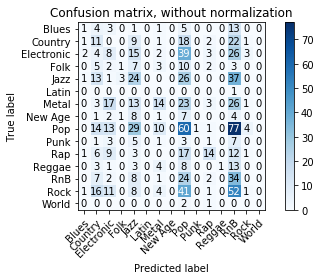

In [54]:
ax = plot_confusion_matrix(total_labels, total_preds, classes=np.array(list(LABEL_TO_INDEX.keys())))
plt.savefig('/data/AGE_DATA/glove.png', dpi=600, transparent=True)

Confusion matrix, without normalization
[[ 0 11  2  0  5  0  2  0 10  0  0  0 14  0  0]
 [ 2  8  3  0  3  0  2  0 19  0  0  0  8  1  0]
 [ 1  7 11  1 15  0  3  0 29  0  2  0 27  4  0]
 [ 0  3  0  2  3  0  2  0  7  0  1  0  5  0  0]
 [ 0  9  5  0 27  0  1  0 30  0  2  0 39  4  0]
 [ 0  0  0  0  1  0  0  0  1  0  0  0  1  0  0]
 [ 0  4  7  1  6  0  9  0 18  0  0  0  9  2  0]
 [ 0  1  1  0  2  0  0  0  1  0  1  0  2  0  0]
 [ 0 14 11  0 10  0  4  0 52  0  3  0 63  2  0]
 [ 0  1  1  0  1  0  0  0  5  0  1  0  1  0  0]
 [ 0  4 11  2  3  0  1  0 16  0 11  0 23  3  0]
 [ 2  5  5  0  5  0  3  0 12  0  0  0 24  0  0]
 [ 1  4  7  0  8  0  2  0 39  0  4  0 49  1  0]
 [ 1 19 12  1 24  0  8  0 62  0  5  0 49  5  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  1  0  0]]


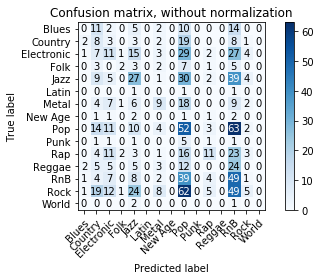

In [60]:
ax = plot_confusion_matrix(test_labels, test_preds, classes=np.array(list(LABEL_TO_INDEX.keys())))
plt.savefig('/data/AGE_DATA/test.png', dpi=600, transparent=True)

# Load preds